#### OPENCLASSROOMS - Parcours Data Scientist  
## Projet 5: Segmentez des clients d'un site e-commerce  
Etudiant: Eric Wendling  
Mentor: Julien Heiduk  
Date: 07/04/2020

**TABLE DES MATIERES**

**1) RFM**  
**2) Clustering**

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Partie 2: Segmentation RFM et Clustering

## Initialisation

### Import des librairies

In [2]:
import pandas as pd
print('Pandas version:',pd.__version__)
pd.options.mode.chained_assignment = None

#import numpy as np
import numpy as np; np.random.seed(0)
print('Numpy version:',np.__version__)

#import matplotlib.style
#import matplotlib as mpl
#mpl.style.use('ggplot')

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
print('Matplotlib version:',matplotlib.__version__)

import seaborn as sns; sns.set()
#import seaborn as sns
sns.set(style="darkgrid")
print('Seaborn version:',sns.__version__)

from IPython.display import Image, HTML
from sklearn.metrics.pairwise import linear_kernel

import tqdm
import time
from time import strftime, gmtime
import sys

from pprint import pprint

import squarify

import random

from IPython.display import Markdown

import pickle
from joblib import dump, load

# gestion des messages d'erreur (https://docs.python.org/fr/3/library/warnings.html)

import sys   
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

Pandas version: 1.0.3
Numpy version: 1.18.3
Matplotlib version: 3.2.1
Seaborn version: 0.10.1


### Fonctions

La fonction ci-dessous permet de mesurer le temps de traitement d'une opération et donne la durée totale des traitements mesurés.

Nous l'utiliserons particulièrement pour mesurer les temps de traitements des différents classifieurs testés.

In [3]:
list_elapsed = []
list_elapsed_mem = [] # Mémorisation d'un résultat
list_ope = []

def time_calc(ope='dernière operation',elapsed_mem='',print_all=0):
    
    elapsed = round((time.time() - t),2)
    
    if ope != 'dernière operation':
        print('Durée de l\'opération %r:' %ope, round(elapsed,2),'s')
    else:
        print('Durée de l\'opération:', round(elapsed,2),'s')
    
    list_elapsed.extend([elapsed])
    list_elapsed_mem.extend([elapsed_mem])
    list_ope.extend([ope])
    tot_duration = sum(list_elapsed)
    df_time = pd.DataFrame({'Opération': list_ope, 'Durée': list_elapsed, 'Temps réel': list_elapsed_mem})

    print('Durée totale de traitement:',strftime('%H', gmtime(tot_duration)),'h',
          strftime('%M', gmtime(tot_duration)),'m',strftime('%S', gmtime(tot_duration)),'s')
    
    if print_all == 1:
        print('')
        print('Durée des opérations')
        print(len('Durée des opérations')*'-')
        print(df_time)   

In [4]:
# Démarrage du compteur
t = time.time()

La fonction suivante donne des informations statistiques sur les taux de remplissage d'une colonne ou d'une ligne.

In [5]:
def stats(df_ref,axis_ref,var_select='p_val',critical_level=0):    
    """Statistiques descriptives des colonnes ou des lignes"""
    
    df = pd.DataFrame(df_ref.notnull().sum(axis=axis_ref), columns = ["nb_val"])
    # On définit un index
    df = df.reset_index()
    # On ajoute une variable: le pourcentage de remplissage
    df['p_val'] = df['nb_val'] * 100 / df_ref.shape[axis_ref]    
    # On identifie les colonnes (ou lignes) dont le taux est supérieur ou égal au seuil
    df = df[(df[var_select] >= critical_level)]
    df = df.sort_values(by = var_select, ascending = False)
    df = df.round(1)
    print(df[['nb_val','p_val']].describe())
    print('')
    if axis_ref == 0:
        print('50% des variables ont un taux de remplissage inférieur à',df['p_val'].median(),'%')
    else:
        print('50% des lignes ont un taux de remplissage inférieur à',df['p_val'].median(),'%')
    df['p_val'].plot(kind='box', figsize=(3,4), color="black")

La fonction suivante montre les taux de remplissage d'un ensemble de variables.

In [6]:
def fill_rate(df,v_min=0,v_max=1,n=5):    
    """Taux de remplissage des variables"""
    
    f_rate = 'Taux de remplissage (%)'
    
    df_fill_rate = df.notnull().mean(axis=0)
    df_fill_rate = pd.DataFrame(df_fill_rate, columns = [f_rate])
    df_fill_rate = df_fill_rate[(df_fill_rate[f_rate] >= v_min) & (df_fill_rate[f_rate] <= v_max)]
    df_fill_rate = df_fill_rate.sort_values(by = f_rate, ascending=True)
    df_fill_rate = round(df_fill_rate * 100,2)
    
    print('')
    print('Affichage des %r premières variables triées par taux croissant:' % n)
    print('')
    print(df_fill_rate.head(n))
    
    plt.figure(figsize=(5,n/3))
    df_fill_rate[f_rate].head(n).plot.barh()
    plt.title("Taux de remplissage par variable")
    plt.show()

La fonction ci-dessous permet d'identifier les valeurs abberantes (outliers) d'une variable.

In [7]:
def val_out(df_ref,var_01,var_01_max='',var_01_min=0):
    """Fonction d'identification de valeurs abberantes"""
    
    df = df_ref.copy()
    df = df[[var_01]]
    
    if var_01_max != '':
        df = df[(df[var_01] >= var_01_min) & (df[var_01] <= var_01_max)]
    else:
        df = df
    
    print(df.describe())  
    df.plot(kind='box', figsize=(3,4), color="black")

In [8]:
# On créé la liste des valeurs uniques de la variable cls_var

def data_boxplot(df,cls_var,plot_format=0):
    
    if plot_format == 0:
    
        fig, axs = plt.subplots(3,1)
        fig.subplots_adjust(left=0.08, right=1.5, bottom=0.05, top=3, hspace=0.4, wspace=0.3)
    
    elif plot_format == 1:
        
        fig, axs = plt.subplots(1,3)
        fig.subplots_adjust(left=0.08, right=2, bottom=2.2, top=3, hspace=0.4, wspace=0.3)
    
    df_ = df.sort_values(cls_var)
    list_cls_var = df_[cls_var].dropna().unique().tolist()

    ### RECENCY

    data = []

    # Pour chaque valeur de cls_var
    for i in list_cls_var:    
        qdata = df[df[cls_var] == i]['recency'].tolist()
        data.append(qdata)

    axs[0].boxplot(data)
    axs[0].set_title('recency')
    axs[0].set_xticklabels(list_cls_var)

    ### FREQUENCY

    data = []

    for i in list_cls_var:    
        qdata = df[df[cls_var] == i]['frequency'].tolist()
        data.append(qdata)

    axs[1].boxplot(data)
    axs[1].set_title('frequency')
    axs[1].set_xticklabels(list_cls_var)

    ### MONETARY

    data = []

    for i in list_cls_var:    
        qdata = df[df[cls_var] == i]['monetary'].tolist()
        data.append(qdata)

    axs[2].boxplot(data)
    axs[2].set_title('monetary')
    axs[2].set_xticklabels(list_cls_var)

    plt.show()

In [9]:
# On créé la liste des valeurs uniques de la variable cls_var

def data_boxplot_2(df,cls_var,var_1,var_2,var_3,plot_format=0):
    
    if plot_format == 0:
    
        fig, axs = plt.subplots(3,1)
        fig.subplots_adjust(left=0.08, right=1.5, bottom=0.05, top=3, hspace=0.4, wspace=0.3)
    
    elif plot_format == 1:
        
        fig, axs = plt.subplots(1,3)
        fig.subplots_adjust(left=0.08, right=2, bottom=2.2, top=3, hspace=0.4, wspace=0.3)
    
    df_ = df.sort_values(cls_var)
    list_cls_var = df_[cls_var].dropna().unique().tolist()

    ### RECENCY

    data = []

    # Pour chaque valeur de cls_var
    for i in list_cls_var:    
        qdata = df[df[cls_var] == i][var_1].tolist()
        data.append(qdata)

    axs[0].boxplot(data)
    axs[0].set_title(var_1)
    axs[0].set_xticklabels(list_cls_var)    

    ### FREQUENCY

    data = []

    for i in list_cls_var:    
        qdata = df[df[cls_var] == i][var_2].tolist()
        data.append(qdata)

    axs[1].boxplot(data)
    axs[1].set_title(var_2)
    axs[1].set_xticklabels(list_cls_var)

    ### MONETARY

    data = []

    for i in list_cls_var:    
        qdata = df[df[cls_var] == i][var_3].tolist()
        data.append(qdata)

    axs[2].boxplot(data)
    axs[2].set_title(var_3)
    axs[2].set_xticklabels(list_cls_var)    
        
    plt.show()

In [10]:
list_df_rfm = ['customer_unique_id','start','end','duration','older',
               'recency','frequency','frequency_2','prod_nb_avg','monetary','price_total']

def df_rfm_q(customer_unique_id='8d50f5eadf50201ccdcedfb9e2ac8455'):
    df_rfm_result = df_rfm[df_rfm['customer_unique_id'] == customer_unique_id][list_df_rfm]
    
    return df_rfm_result 

La fonction suivante permet d'écrire un titre sous-ligné.

In [11]:
def title(title):
    print('')
    print(title)
    print(len(title)*'-')    

In [12]:
def bip():
    import winsound
    frequency = 440  # max 2500 Hertz
    duration = 400  # max 1000 ms
    winsound.Beep(frequency, duration)

#### Données stockées

In [13]:
#%store

In [14]:
time_calc('Initialisation')
t = time.time()

Durée de l'opération 'Initialisation': 0.19 s
Durée totale de traitement: 00 h 00 m 00 s


## RFM

### Variables RFM

On récupère, depuis le store, plusieurs dataframes et liste produits durant l'analyse:

+ ***df***
+ ***df1***
+ **list_rfm** (liste des noms de variables RFM)

In [15]:
%store -r df
df.shape

(112650, 100)

In [16]:
%store -r df1
df1.shape

(95420, 14)

In [17]:
%store -r list_rfm
list_rfm

[('purchase_date', 'min'),
 ('purchase_date', 'max'),
 ('order_id', 'nunique'),
 ('product_id', 'count'),
 ('price_total', 'mean'),
 ('price_total', 'sum'),
 ('price_per_cust', 'first'),
 ('prod_nb_avg', 'first'),
 ('score_mean_per_ord', 'mean'),
 ('score_mean_per_cust', 'first'),
 ('same_loc', 'sum'),
 ('customer_u_zip_code_prefix', 'first'),
 'nb_prod_diff',
 'nb_pay_type_diff']

In [18]:
df1.head(2)

,"(purchase_date, min)","(purchase_date, max)","(order_id, nunique)","(product_id, count)","(price_total, mean)","(price_total, sum)","(price_per_cust, first)","(prod_nb_avg, first)","(score_mean_per_ord, mean)","(score_mean_per_cust, first)","(same_loc, sum)","(customer_u_zip_code_prefix, first)",nb_prod_diff,nb_pay_type_diff
customer_unique_id,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,2018-05-10,1,1,141.90,141.90,141.90,1.0,5.0,5.0,0.0,7787,1,1
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,2018-05-07,1,1,27.19,27.19,27.19,1.0,4.0,4.0,0.0,6053,1,1


In [19]:
# On écarte les variables qui ne nous intéressent pas
list_rfm.remove(('score_mean_per_ord', 'mean'))
list_rfm.remove(('customer_u_zip_code_prefix', 'first'))
# On ajoute la variable 'customer_unique_id' dans la liste RFM
list_rfm.append('customer_unique_id')
list_rfm

[('purchase_date', 'min'),
 ('purchase_date', 'max'),
 ('order_id', 'nunique'),
 ('product_id', 'count'),
 ('price_total', 'mean'),
 ('price_total', 'sum'),
 ('price_per_cust', 'first'),
 ('prod_nb_avg', 'first'),
 ('score_mean_per_cust', 'first'),
 ('same_loc', 'sum'),
 'nb_prod_diff',
 'nb_pay_type_diff',
 'customer_unique_id']

In [20]:
df1.reset_index(inplace=True)
df1.head(2)

,customer_unique_id,"(purchase_date, min)","(purchase_date, max)","(order_id, nunique)","(product_id, count)","(price_total, mean)","(price_total, sum)","(price_per_cust, first)","(prod_nb_avg, first)","(score_mean_per_ord, mean)","(score_mean_per_cust, first)","(same_loc, sum)","(customer_u_zip_code_prefix, first)",nb_prod_diff,nb_pay_type_diff
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,2018-05-10,1,1,141.90,141.90,141.90,1.0,5.0,5.0,0.0,7787,1,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,2018-05-07,1,1,27.19,27.19,27.19,1.0,4.0,4.0,0.0,6053,1,1


On définit le dataframe ***df_rfm*** sur la base de ***df1*** et de la liste des variables RFM.

In [21]:
df_rfm = df1[list_rfm]
df_rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95420 entries, 0 to 95419
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   (purchase_date, min)          95420 non-null  datetime64[ns]
 1   (purchase_date, max)          95420 non-null  datetime64[ns]
 2   (order_id, nunique)           95420 non-null  int64         
 3   (product_id, count)           95420 non-null  int64         
 4   (price_total, mean)           95420 non-null  float64       
 5   (price_total, sum)            95420 non-null  float64       
 6   (price_per_cust, first)       95420 non-null  float64       
 7   (prod_nb_avg, first)          95420 non-null  float64       
 8   (score_mean_per_cust, first)  95420 non-null  float64       
 9   (same_loc, sum)               95420 non-null  float64       
 10  nb_prod_diff                  95420 non-null  int64         
 11  nb_pay_type_diff            

In [22]:
df_rfm.sort_values(('order_id', 'nunique'), ascending=False).head()

,"(purchase_date, min)","(purchase_date, max)","(order_id, nunique)","(product_id, count)","(price_total, mean)","(price_total, sum)","(price_per_cust, first)","(prod_nb_avg, first)","(score_mean_per_cust, first)","(same_loc, sum)",nb_prod_diff,nb_pay_type_diff,customer_unique_id
52597,2017-05-15,2018-08-20,16,16,56.377500,902.04,56.377500,1.000000,4.764706,0.0,4,1,8d50f5eadf50201ccdcedfb9e2ac8455
23302,2017-09-18,2018-02-27,9,14,83.762143,1172.67,130.296667,1.555556,2.777778,0.0,5,1,3e43e6105506432c953e165fb2acf44c
10281,2017-11-13,2018-02-14,7,9,106.556667,959.01,137.001429,1.285714,5.000000,0.0,5,3,1b6c7548a2a1f9037c1fd3ddfed95f33
37532,2017-09-19,2018-06-28,7,9,84.314444,758.83,108.404286,1.285714,5.000000,0.0,1,1,6469f99c1f9dfae7733b25662e7f1782
75560,2017-10-09,2018-06-01,7,12,93.560000,1122.72,160.388571,1.714286,5.000000,0.0,4,2,ca77025e7201e3b30c44b472ff346268


#### Nombre de jours entre la première et la dernière date d'achat par client
+ **'duration'**

In [23]:
df_rfm['duration_'] = df_rfm['purchase_date', 'max'] - df_rfm['purchase_date', 'min']
df_rfm['duration'] = df_rfm['duration_'] / np.timedelta64(1, 'D')
df_rfm['duration'] = df_rfm['duration'] + 1
del df_rfm['duration_']
df_rfm.sort_values('duration', ascending = False).head()

,"(purchase_date, min)","(purchase_date, max)","(order_id, nunique)","(product_id, count)","(price_total, mean)","(price_total, sum)","(price_per_cust, first)","(prod_nb_avg, first)","(score_mean_per_cust, first)","(same_loc, sum)",nb_prod_diff,nb_pay_type_diff,customer_unique_id,duration
19031,2016-10-03,2018-06-28,3,3,45.7200,137.16,45.720,1.0,4.666667,0.0,2,3,32ea3bdedab835c3aa6cb68ce66565ef,634.0
76403,2016-10-06,2018-06-07,2,2,103.7550,207.51,103.755,1.0,5.000000,0.0,2,1,ccafc1c3f270410521c3c6f3b249870f,610.0
80964,2017-01-18,2018-08-24,2,4,39.6275,158.51,79.255,2.0,4.500000,0.0,2,2,d8f3c4f441a9b59a29f977df16724f38,584.0
55465,2016-10-05,2018-05-09,2,2,93.5850,187.17,93.585,1.0,5.000000,0.0,2,1,94e5ea5a8c1bf546db2739673060c43f,582.0
50627,2016-10-08,2018-05-04,2,2,261.5600,523.12,261.560,1.0,3.500000,0.0,2,1,87b3f231705783eb2217e25851c0a45d,574.0


##### Date la plus récente

In [24]:
purchase_date_max = df_rfm[[('purchase_date', 'max')]].max()
purchase_date_max

(purchase_date, max)   2018-09-03
dtype: datetime64[ns]

##### Date la plus ancienne

In [25]:
purchase_date_min = df_rfm[[('purchase_date', 'min')]].min()
purchase_date_min

(purchase_date, min)   2016-09-04
dtype: datetime64[ns]

#### Nombre de jours depuis la date d'achat la plus ancienne par client
+ **'older'**

In [26]:
### Option 2: pour inverser les valeurs dans les graphes
###df_rfm['older_'] = df_rfm['purchase_date', 'min'] - df_rfm['purchase_date', 'min'].min()
df_rfm['older_'] = df_rfm['purchase_date', 'max'].max() - df_rfm['purchase_date', 'min']
df_rfm['older'] = df_rfm['older_'] / np.timedelta64(1, 'D')
del df_rfm['older_']
df_rfm.sort_values('older', ascending = False).head()

,"(purchase_date, min)","(purchase_date, max)","(order_id, nunique)","(product_id, count)","(price_total, mean)","(price_total, sum)","(price_per_cust, first)","(prod_nb_avg, first)","(score_mean_per_cust, first)","(same_loc, sum)",nb_prod_diff,nb_pay_type_diff,customer_unique_id,duration,older
68611,2016-09-04,2016-09-04,1,2,68.115,136.23,136.23,2.0,1.0,0.0,1,1,b7d76e111c89f7ebf14761390f0f7d17,1.0,729.0
27050,2016-09-05,2016-09-05,1,1,75.060,75.06,75.06,1.0,1.0,0.0,1,1,4854e9b3feff728c13ee5fc7d1547e92,1.0,728.0
48972,2016-09-15,2016-09-15,1,3,47.820,143.46,143.46,3.0,1.0,0.0,1,0,830d5b7aaa3b6f1e9ad63703bec97d23,1.0,718.0
5480,2016-10-02,2016-10-02,1,1,109.340,109.34,109.34,1.0,1.0,0.0,1,1,0eb1ee9dba87f5b36b4613a65074337c,1.0,701.0
50535,2016-10-03,2016-10-03,1,1,40.950,40.95,40.95,1.0,5.0,0.0,1,1,87776adb449c551e74c13fc34f036105,1.0,700.0


#### Nombre de jours depuis la date d'achat la plus récente par client
+ **'recency'**

In [27]:
### Option 2: pour inverser les valeurs dans les graphes
###df_rfm['recency_'] = df_rfm['purchase_date', 'max'] - df_rfm['purchase_date', 'min'].min() 

df_rfm['recency_'] = df_rfm['purchase_date', 'max'].max() - df_rfm['purchase_date', 'max']

df_rfm['recency'] = df_rfm['recency_'] / np.timedelta64(1, 'D') # Nombre de jour
###df_rfm['recency'] = df_rfm['recency'] / 365 # Nombre d'années
del df_rfm['recency_']
df_rfm.sort_values('recency', ascending = False).head()

,"(purchase_date, min)","(purchase_date, max)","(order_id, nunique)","(product_id, count)","(price_total, mean)","(price_total, sum)","(price_per_cust, first)","(prod_nb_avg, first)","(score_mean_per_cust, first)","(same_loc, sum)",nb_prod_diff,nb_pay_type_diff,customer_unique_id,duration,older,recency
68611,2016-09-04,2016-09-04,1,2,68.115,136.23,136.23,2.0,1.0,0.0,1,1,b7d76e111c89f7ebf14761390f0f7d17,1.0,729.0,729.0
27050,2016-09-05,2016-09-05,1,1,75.060,75.06,75.06,1.0,1.0,0.0,1,1,4854e9b3feff728c13ee5fc7d1547e92,1.0,728.0,728.0
48972,2016-09-15,2016-09-15,1,3,47.820,143.46,143.46,3.0,1.0,0.0,1,0,830d5b7aaa3b6f1e9ad63703bec97d23,1.0,718.0,718.0
5480,2016-10-02,2016-10-02,1,1,109.340,109.34,109.34,1.0,1.0,0.0,1,1,0eb1ee9dba87f5b36b4613a65074337c,1.0,701.0,701.0
68959,2016-10-03,2016-10-03,1,1,35.610,35.61,35.61,1.0,1.0,0.0,1,1,b8b8726af116a5cfb35b0315ecef9172,1.0,700.0,700.0


#### Fréquence d'achats par client
+ **'frequency'**

In [28]:
frequency_opt = 0

if frequency_opt == 0:
    df_rfm['frequency'] = df_rfm[('order_id', 'nunique')]
    df_rfm['frequency_2'] = df_rfm[('product_id', 'count')]
    
elif frequency_opt == 1:
    df_rfm['frequency'] = df_rfm[('product_id', 'count')]
    df_rfm['frequency_2'] = df_rfm[('order_id', 'nunique')]

df_rfm['frequency'] = df_rfm['frequency'].replace(np.inf,1)
df_rfm['frequency_2'] = df_rfm['frequency_2'].replace(np.inf,1)

del df_rfm[('order_id', 'nunique')]

df_rfm.sort_values('frequency', ascending = False).head()

,"(purchase_date, min)","(purchase_date, max)","(product_id, count)","(price_total, mean)","(price_total, sum)","(price_per_cust, first)","(prod_nb_avg, first)","(score_mean_per_cust, first)","(same_loc, sum)",nb_prod_diff,nb_pay_type_diff,customer_unique_id,duration,older,recency,frequency,frequency_2
52597,2017-05-15,2018-08-20,16,56.377500,902.04,56.377500,1.000000,4.764706,0.0,4,1,8d50f5eadf50201ccdcedfb9e2ac8455,463.0,476.0,14.0,16,16
23302,2017-09-18,2018-02-27,14,83.762143,1172.67,130.296667,1.555556,2.777778,0.0,5,1,3e43e6105506432c953e165fb2acf44c,163.0,350.0,188.0,9,14
10281,2017-11-13,2018-02-14,9,106.556667,959.01,137.001429,1.285714,5.000000,0.0,5,3,1b6c7548a2a1f9037c1fd3ddfed95f33,94.0,294.0,201.0,7,9
37532,2017-09-19,2018-06-28,9,84.314444,758.83,108.404286,1.285714,5.000000,0.0,1,1,6469f99c1f9dfae7733b25662e7f1782,283.0,349.0,67.0,7,9
75560,2017-10-09,2018-06-01,12,93.560000,1122.72,160.388571,1.714286,5.000000,0.0,4,2,ca77025e7201e3b30c44b472ff346268,236.0,329.0,94.0,7,12


#### Montants par client
+ **'monetary'**

In [29]:
# Si on choisit le nombre de commandes comme frequence, alors le montant par client (monetary)
# est égale au panier moyen, c'est-à-dire la moyenne des montants par commande
# Le panier moyen a déjà été calculé, il s'agit de la variable ('price_per_cust','first')
if frequency_opt == 0:
    df_rfm['monetary'] = df_rfm[('price_per_cust','first')]

# Si on choisit le nombre de produits comme frequence, alors le montant par client (monetary)
# est égale à la moyenne des prix par produit qui correspond à la variable ('price_total','mean')
elif frequency_opt == 1:
    df_rfm['monetary'] = df_rfm[('price_total','mean')]

# On peut conserver la variable ('price_total','mean') pour une utilisation éventuelle lors du clustering
###del df_rfm[('price_total','mean')]
del df_rfm[('price_per_cust','first')]

df_rfm.sort_values('monetary', ascending = False).head()

,"(purchase_date, min)","(purchase_date, max)","(product_id, count)","(price_total, mean)","(price_total, sum)","(prod_nb_avg, first)","(score_mean_per_cust, first)","(same_loc, sum)",nb_prod_diff,nb_pay_type_diff,customer_unique_id,duration,older,recency,frequency,frequency_2,monetary
3799,2017-09-29,2017-09-29,8,1708.01,13664.08,8.0,1.0,0.0,1,1,0a0a92112bd4c708ca5fde585afaa872,1.0,339.0,339.0,1,8,13664.08
44139,2018-07-15,2018-07-15,4,1818.72,7274.88,4.0,1.0,0.0,1,1,763c8b1c9c68a0229c42c9fc6f662b93,1.0,50.0,50.0,1,4,7274.88
82230,2017-02-12,2017-02-12,1,6929.31,6929.31,1.0,5.0,0.0,1,1,dc4802a71eae9be1dd28f5d788ceb526,1.0,568.0,568.0,1,1,6929.31
26015,2018-07-25,2018-07-25,1,6922.21,6922.21,1.0,1.0,0.0,1,1,459bef486812aa25204be022145caa62,1.0,40.0,40.0,1,1,6922.21
95131,2017-05-24,2017-05-24,1,6726.66,6726.66,1.0,5.0,0.0,1,1,ff4159b92c40ebe40454e3e6a7c35ed6,1.0,467.0,467.0,1,1,6726.66


#### Pourcentage de produits livrés à la même localisation que le vendeur
+ **'same_loc'**

In [30]:
df_rfm['same_loc_'] = df_rfm[('same_loc','sum')] / df_rfm[('product_id','count')]
del df_rfm[('same_loc','sum')]
df_rfm = df_rfm.rename(columns={'same_loc_': 'same_loc'}, inplace = False)
del df_rfm[('product_id', 'count')]

df_rfm.sort_values('same_loc', ascending = False).head()

,"(purchase_date, min)","(purchase_date, max)","(price_total, mean)","(price_total, sum)","(prod_nb_avg, first)","(score_mean_per_cust, first)",nb_prod_diff,nb_pay_type_diff,customer_unique_id,duration,older,recency,frequency,frequency_2,monetary,same_loc
83189,2018-08-06,2018-08-06,133.51,133.51,1.0,1.0,1,1,dedcaadfb4f32c9a0e477f198645aaa3,1.0,28.0,28.0,1,1,133.51,1.0
4573,2018-04-20,2018-04-20,62.25,62.25,1.0,1.0,1,1,0c184b7e23f30243d8957a97ce6af3f8,1.0,136.0,136.0,1,1,62.25,1.0
4978,2018-04-04,2018-04-04,391.47,391.47,1.0,5.0,1,1,0d4cf36ed65cd1aba4a30a3bea1b19d4,1.0,152.0,152.0,1,1,391.47,1.0
80458,2018-04-12,2018-04-12,28.24,28.24,1.0,5.0,1,1,d78ba2a6390559b14c16814f00f5142d,1.0,144.0,144.0,1,1,28.24,1.0
53566,2018-08-13,2018-08-13,111.71,223.42,2.0,2.0,1,1,8fdef5ce67c95465166d77d756ad3fd9,1.0,21.0,21.0,1,2,223.42,1.0


           same_loc
count  95420.000000
mean       0.000241
std        0.015524
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000


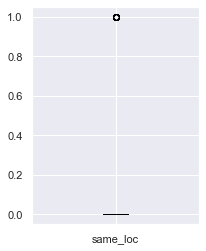

In [31]:
val_out(df_rfm,'same_loc')

#### Notation par client
+ **'score'**

In [32]:
df_rfm['score'] = df_rfm[('score_mean_per_cust', 'first')]
del df_rfm[('score_mean_per_cust', 'first')]
df_rfm.sort_values('score', ascending = False).head()

,"(purchase_date, min)","(purchase_date, max)","(price_total, mean)","(price_total, sum)","(prod_nb_avg, first)",nb_prod_diff,nb_pay_type_diff,customer_unique_id,duration,older,recency,frequency,frequency_2,monetary,same_loc,score
0,2018-05-10,2018-05-10,141.90,141.90,1.0,1,1,0000366f3b9a7992bf8c76cfdf3221e2,1.0,116.0,116.0,1,1,141.90,0.0,5.0
54858,2018-08-21,2018-08-21,76.10,76.10,1.0,1,1,934660a0b1796ee464265323e071ecea,1.0,13.0,13.0,1,1,76.10,0.0,5.0
54838,2018-07-23,2018-07-23,120.68,120.68,1.0,1,1,9339ade05031453f881ef7db13a8da39,1.0,42.0,42.0,1,1,120.68,0.0,5.0
54839,2018-06-07,2018-06-07,68.33,68.33,1.0,1,1,9339c5dcdb8ec30292a29b9a93b370ed,1.0,88.0,88.0,1,1,68.33,0.0,5.0
54840,2018-08-20,2018-08-20,150.89,150.89,1.0,1,1,933a3c344289b11dc67567fbe01a7eb4,1.0,14.0,14.0,1,1,150.89,0.0,5.0


On renomme les colonnes de ***df_rfm***.

In [33]:
df_rfm.columns = ['start','end','price_mean','price_total','prod_nb_avg','nb_prod_diff','nb_pay_type_diff','customer_unique_id','duration','older','recency','frequency','frequency_2','monetary','same_loc','score']

On arrange les colonnes de ***df_rfm***.

In [34]:
df_rfm = df_rfm[['customer_unique_id','start','end','older','recency','duration','frequency','frequency_2','prod_nb_avg','nb_prod_diff','nb_pay_type_diff','monetary','price_mean','price_total','same_loc','score']]

In [35]:
df_rfm = df_rfm.set_index('customer_unique_id')

In [36]:
df_rfm.sort_values('frequency', ascending = False).head()

,start,end,older,recency,duration,frequency,frequency_2,prod_nb_avg,nb_prod_diff,nb_pay_type_diff,monetary,price_mean,price_total,same_loc,score
customer_unique_id,,,,,,,,,,,,,,,
8d50f5eadf50201ccdcedfb9e2ac8455,2017-05-15,2018-08-20,476.0,14.0,463.0,16,16,1.000000,4,1,56.377500,56.377500,902.04,0.0,4.764706
3e43e6105506432c953e165fb2acf44c,2017-09-18,2018-02-27,350.0,188.0,163.0,9,14,1.555556,5,1,130.296667,83.762143,1172.67,0.0,2.777778
1b6c7548a2a1f9037c1fd3ddfed95f33,2017-11-13,2018-02-14,294.0,201.0,94.0,7,9,1.285714,5,3,137.001429,106.556667,959.01,0.0,5.000000
6469f99c1f9dfae7733b25662e7f1782,2017-09-19,2018-06-28,349.0,67.0,283.0,7,9,1.285714,1,1,108.404286,84.314444,758.83,0.0,5.000000
ca77025e7201e3b30c44b472ff346268,2017-10-09,2018-06-01,329.0,94.0,236.0,7,12,1.714286,4,2,160.388571,93.560000,1122.72,0.0,5.000000


In [37]:
df_rfm.shape

(95420, 15)

In [38]:
time_calc('Variables RFM')
t = time.time()

Durée de l'opération 'Variables RFM': 1.45 s
Durée totale de traitement: 00 h 00 m 01 s


### Filtrage des clients

In [39]:
rows_filter_ = 1

In [40]:
list_cust_uid_to_rem = [
                        '0a0a92112bd4c708ca5fde585afaa872',
                        '8d50f5eadf50201ccdcedfb9e2ac8455'
                       ]


if rows_filter_ == 1:
    df_rfm = df_rfm.drop(list_cust_uid_to_rem)

df_rfm.shape

(95418, 15)

In [41]:
time_calc('Filtrage des individus (clients)')
t = time.time()

Durée de l'opération 'Filtrage des individus (clients)': 0.11 s
Durée totale de traitement: 00 h 00 m 01 s


### Distributions RFM

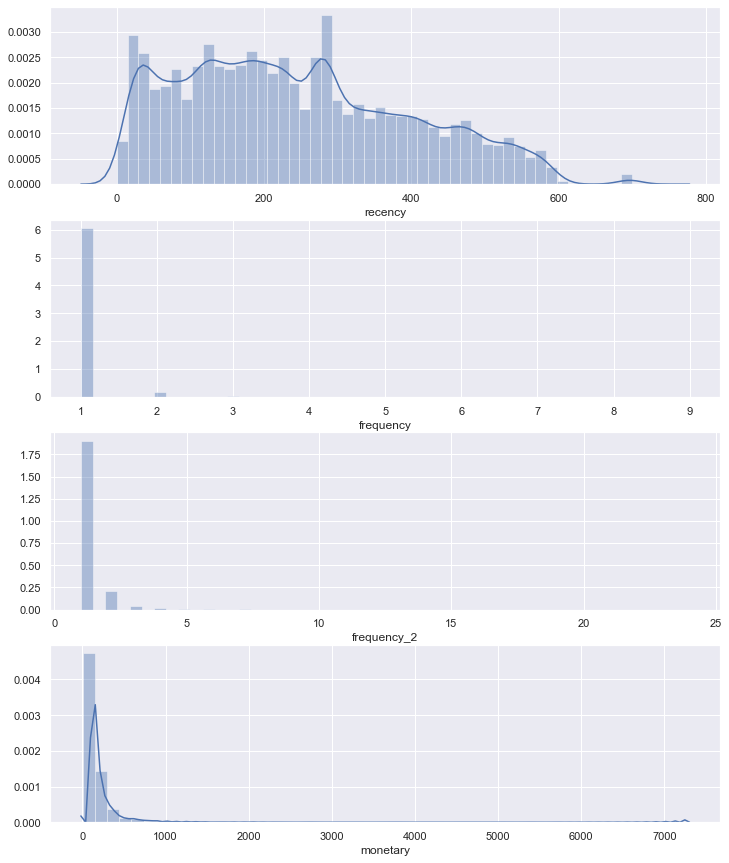

In [42]:
# Distribution RFM
plt.figure(figsize=(12,15))

# Distribution R
plt.subplot(4,1,1)
sns.distplot(df_rfm['recency'])

# Distribution F
plt.subplot(4,1,2)
sns.distplot(df_rfm['frequency'])

# Distribution F2
plt.subplot(4,1,3)
sns.distplot(df_rfm['frequency_2'])

# Distribution M
plt.subplot(4,1,4)
sns.distplot(df_rfm['monetary'])
plt.show()

### Statistiques RFM

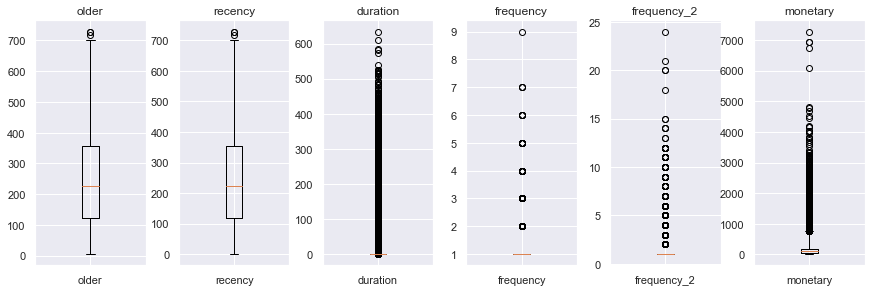

In [43]:
fig, axs = plt.subplots(1, 6)
fig.subplots_adjust(left=0.08, right=2, bottom=0.05, top=0.9, hspace=0.4, wspace=0.3)

###########
### RFM ###
###########

X_std = df_rfm

# older
older = X_std['older'].tolist()
data = [older]

axs[0].boxplot(data)
axs[0].set_title('older')
axs[0].set_xticklabels(['older'])

# recency
recency = X_std['recency'].tolist()
data = [recency]

axs[1].boxplot(data)
axs[1].set_title('recency')
axs[1].set_xticklabels(['recency'])

# duration
duration = X_std['duration'].tolist()
data = [duration]

axs[2].boxplot(data)
axs[2].set_title('duration')
axs[2].set_xticklabels(['duration'])

# frequency
frequency = X_std['frequency'].tolist()

data = [frequency]

axs[3].boxplot(data)
axs[3].set_title('frequency')
axs[3].set_xticklabels(['frequency'])

# frequency_2
frequency_2 = X_std['frequency_2'].tolist()

data = [frequency_2]

axs[4].boxplot(data)
axs[4].set_title('frequency_2')
axs[4].set_xticklabels(['frequency_2'])

# monetary
monetary = X_std['monetary'].tolist()

data = [monetary]

axs[5].boxplot(data, whis = 5)
axs[5].set_title('monetary')
axs[5].set_xticklabels(['monetary'])

plt.show()

In [44]:
df_rfm[['older','recency','duration','frequency','frequency_2','monetary']].describe()

,older,recency,duration,frequency,frequency_2,monetary
count,95418.000000,95418.000000,95418.000000,95418.000000,95418.000000,95418.000000
mean,246.181465,243.502861,3.678604,1.033862,1.180343,160.904352
std,153.655917,153.160341,25.219539,0.205605,0.619208,216.831271
min,5.000000,0.000000,1.000000,1.000000,1.000000,9.590000
25%,122.000000,119.000000,1.000000,1.000000,1.000000,62.410000
50%,227.000000,224.000000,1.000000,1.000000,1.000000,105.770000
75%,356.000000,353.000000,1.000000,1.000000,1.000000,177.118750
max,729.000000,729.000000,634.000000,9.000000,24.000000,7274.880000


In [45]:
df_rfm.reset_index(inplace=True)

Comme on peut le voir sur la distribution RFM, une majorité de clients ont réalisé une seule commande ou ont acheté un seul produit.

In [46]:
# Nombre de clients par nombre de commandes réalisées
df_rfm[['customer_unique_id','frequency']].groupby('frequency').count()

,customer_unique_id
frequency,
1,92506
2,2673
3,192
4,29
5,9
6,5
7,3
9,1


In [47]:
order_freq_1 = df_rfm[['customer_unique_id','frequency']].groupby('frequency').count().loc[1,'customer_unique_id']

In [48]:
# Nombre de clients par nombre de produits achetés
df_rfm[['customer_unique_id','frequency_2']].groupby('frequency_2').count()

,customer_unique_id
frequency_2,
1,83551
2,8996
3,1672
4,632
5,254
6,198
7,46
8,15
9,11


In [49]:
prod_freq_1 = df_rfm[['customer_unique_id','frequency_2']].groupby('frequency_2').count().loc[1,'customer_unique_id']

In [50]:
df_rfm = df_rfm.set_index('customer_unique_id')

In [51]:
order_freq_1p = df_rfm[df_rfm['frequency'] == 1][['frequency','start']].groupby('frequency').count().loc[1, 'start'] / df_rfm.shape[0] * 100
order_freq_1p = round(order_freq_1p)
order_freq_1p

97.0

In [52]:
prod_freq_1p = df_rfm[df_rfm['frequency_2'] == 1][['frequency_2','start']].groupby('frequency_2').count().loc[1, 'start'] / df_rfm.shape[0] * 100
prod_freq_1p = round(prod_freq_1p)
prod_freq_1p

88.0

In [53]:
Markdown("""
>**{order_freq_1}** clients ont réalisé une seule commande (fréquence = 1) ce qui représente **{order_freq_1p}%** de l'ensemble des clients.
>
>**{prod_freq_1}** clients ont acheté un seul produit (fréquence_2 = 1) ce qui représente **{prod_freq_1p}%** de l'ensemble des clients.
""".format(order_freq_1=order_freq_1,order_freq_1p=order_freq_1p,prod_freq_1=prod_freq_1,prod_freq_1p=prod_freq_1p))


>**92506** clients ont réalisé une seule commande (fréquence = 1) ce qui représente **97.0%** de l'ensemble des clients.
>
>**83551** clients ont acheté un seul produit (fréquence_2 = 1) ce qui représente **88.0%** de l'ensemble des clients.


In [54]:
df_rfm.shape

(95418, 15)

In [55]:
time_calc('Statistiques - RFM')
t = time.time()

Durée de l'opération 'Statistiques - RFM': 2.9 s
Durée totale de traitement: 00 h 00 m 04 s


### Segmentation RFM

#### Classification des données RFM

In [56]:
# Répartition des données en différentes classes par variable rfm

nb_bins = 5

cl_r = pd.qcut(df_rfm['recency'], 5, labels = range(nb_bins, 0, -1)) # range de 5 à 1
cl_f = pd.cut(df_rfm['frequency'], bins = nb_bins, labels = range(1, nb_bins+1)) # range de 1 à 5
cl_m = pd.qcut(df_rfm['monetary'], 5, labels = range(1, nb_bins+1)) # range de 1 à 5
 
# Création des colonnes R, F, P dans df_rfm 
df_rfm = df_rfm.assign(R = cl_r.values, F = cl_f.values, M = cl_m.values)

##### Répartition des clients par classe ('R', 'F', 'M')

In [57]:
df_cl_r = pd.DataFrame(cl_r).reset_index().groupby(['recency']).count()
df_cl_f = pd.DataFrame(cl_f).reset_index().groupby(['frequency']).count()
df_cl_m = pd.DataFrame(cl_m).reset_index().groupby(['monetary']).count()

df_cl_rfm = df_cl_r.sort_index(axis = 0, ascending = False).merge(df_cl_f, left_index = True,
                                                                  right_index = True).merge(df_cl_m, left_index = True,
                                                                                            right_index = True).reset_index()

title('Nombre de clients par classe')
df_cl_rfm.columns = ['Class','R','F','M']
df_cl_rfm


Nombre de clients par classe
----------------------------


,Class,R,F,M
0,1,18947,95179,19140
1,2,19147,221,19027
2,3,19112,9,19090
3,4,18995,8,19077
4,5,19217,1,19084


##### Concaténation des variables 'R', 'F', 'M'

In [58]:
df_rfm['frequency'] = np.float64(df_rfm['frequency'])
df_rfm['frequency_2'] = np.float64(df_rfm['frequency_2'])

df_rfm['R'] = df_rfm['R'].astype('str')
df_rfm['F'] = df_rfm['F'].astype('str')
df_rfm['M'] = df_rfm['M'].astype('str')

df_rfm['RFM'] = df_rfm['R'] + df_rfm['F'] + df_rfm['M']

print(df_rfm[['recency','frequency','monetary','R','F','M','RFM']].head())

                                  recency  frequency  monetary  R  F  M  RFM
customer_unique_id                                                          
0000366f3b9a7992bf8c76cfdf3221e2    116.0        1.0    141.90  4  1  4  414
0000b849f77a49e4a4ce2b2a4ca5be3f    119.0        1.0     27.19  4  1  1  411
0000f46a3911fa3c0805444483337064    542.0        1.0     86.22  1  1  3  113
0000f6ccb0745a6a4b88665a16c9f078    326.0        1.0     43.62  2  1  1  211
0004aac84e0df4da2b147fca70cf8255    293.0        1.0    196.89  2  1  4  214


#### Scores RFM

In [59]:
# Nombre de valeurs uniques RFM
rfm_count_unique = df_rfm.groupby('RFM')['RFM'].nunique()
print(rfm_count_unique.sum())

64


On obtient un nombre de valeurs uniques RFM trop grand pour l'analyse.

> On se propose alors de transformer les valeurs RFM en un **score** correspondant à la somme des valeurs R, F et M.

In [60]:
df_rfm['R'] = df_rfm['R'].astype('int')
df_rfm['F'] = df_rfm['F'].astype('int')
df_rfm['M'] = df_rfm['M'].astype('int')

df_rfm['rfm_score'] = df_rfm[['R','F','M']].sum(axis=1)

print(df_rfm[['recency','frequency','monetary','RFM','rfm_score']].head())

                                  recency  frequency  monetary  RFM  rfm_score
customer_unique_id                                                            
0000366f3b9a7992bf8c76cfdf3221e2    116.0        1.0    141.90  414          9
0000b849f77a49e4a4ce2b2a4ca5be3f    119.0        1.0     27.19  411          6
0000f46a3911fa3c0805444483337064    542.0        1.0     86.22  113          5
0000f6ccb0745a6a4b88665a16c9f078    326.0        1.0     43.62  211          4
0004aac84e0df4da2b147fca70cf8255    293.0        1.0    196.89  214          7


In [61]:
rfm_score_labels = df_rfm.sort_values('rfm_score')['rfm_score'].unique().tolist()
rfm_score_labels

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [62]:
Markdown("""
On obtient **{rfm_score_unique}** valeurs différentes de **'rfm_score'** donc un regroupement des individus en **{rfm_score_unique}** classes.

A ce stade, plusieurs options sont possibles suivant la stratégie de l'entreprise.
>**<font color=#F54620>Option 1</font>**
>
>On peut exploiter les **Scores RFM** et élaborer des stratégies commerciales sur la base des **{rfm_score_unique}** classes de clients et des statistiques de **'recency'**, **'frequency'** et **'monetary'** par classe.
""".format(rfm_score_unique=len(rfm_score_labels)))


On obtient **11** valeurs différentes de **'rfm_score'** donc un regroupement des individus en **11** classes.

A ce stade, plusieurs options sont possibles suivant la stratégie de l'entreprise.
>**<font color=#F54620>Option 1</font>**
>
>On peut exploiter les **Scores RFM** et élaborer des stratégies commerciales sur la base des **11** classes de clients et des statistiques de **'recency'**, **'frequency'** et **'monetary'** par classe.


#### Statistiques Scores RFM

In [63]:
df_rfm.groupby('rfm_score').agg({'duration': ['mean','median','min','max'],
                                 'recency': ['mean','median','min','max'],
                                 'frequency': ['mean','median','min','max'],
                                 'monetary': ['mean','median','min','max','count']}).round(1)

duration                      recency                       \
              mean median    min    max    mean median    min    max   
rfm_score                                                              
3              1.3    1.0    1.0  167.0   482.3  476.0  390.0  700.0   
4              1.7    1.0    1.0  271.0   402.4  394.0  274.0  728.0   
5              2.1    1.0    1.0  348.0   339.1  316.0  183.0  701.0   
6              2.4    1.0    1.0  399.0   289.5  272.0   99.0  729.0   
7              3.4    1.0    1.0  484.0   245.3  227.0    5.0  699.0   
8              4.8    1.0    1.0  634.0   186.3  186.0    5.0  489.0   
9              5.1    1.0    1.0  610.0   138.2  140.0    5.0  375.0   
10             5.7    1.0    1.0  574.0    95.6   97.0    0.0  251.0   
11             6.9    1.0    1.0  538.0    52.8   49.0    5.0  222.0   
12           220.3  209.0    2.0  483.0    65.9   47.0   19.0  188.0   
13           320.2  313.0  236.0  419.0    69.2   84.0   11.0   98.0   

          frequency                  monetary                               
               mean median  min  max     mean median    min     max  count  
rfm_score                                                                   
3               1.0    1.0  1.0  2.0     39.6   40.0   12.3    55.0   3993  
4               1.0    1.0  1.0  4.0     55.5   56.1   10.1    85.8   7567  
5               1.0    1.0  1.0  3.0     71.1   68.1   13.8   129.1  11834  
6               1.0    1.0  1.0  6.0     92.7   85.1   12.9   202.5  14621  
7               1.0    1.0  1.0  4.0    162.7  106.2    9.6  6929.3  18816  
8               1.0    1.0  1.0  5.0    194.7  131.6   29.4  6081.5  15383  
9               1.0    1.0  1.0  5.0    217.9  158.9   58.5  3826.8  11425  
10              1.0    1.0  1.0  5.0    296.5  200.4   88.4  4175.3   7819  
11              1.0    1.0  1.0  7.0    433.1  301.8   90.1  7274.9   3939  
12              4.0    3.0  3.0  9.0    342.1  260.9  108.4  1164.0     17  
13              6.0    6.0  5.0  7.0    197.1  166.3  137.7   318.2      4

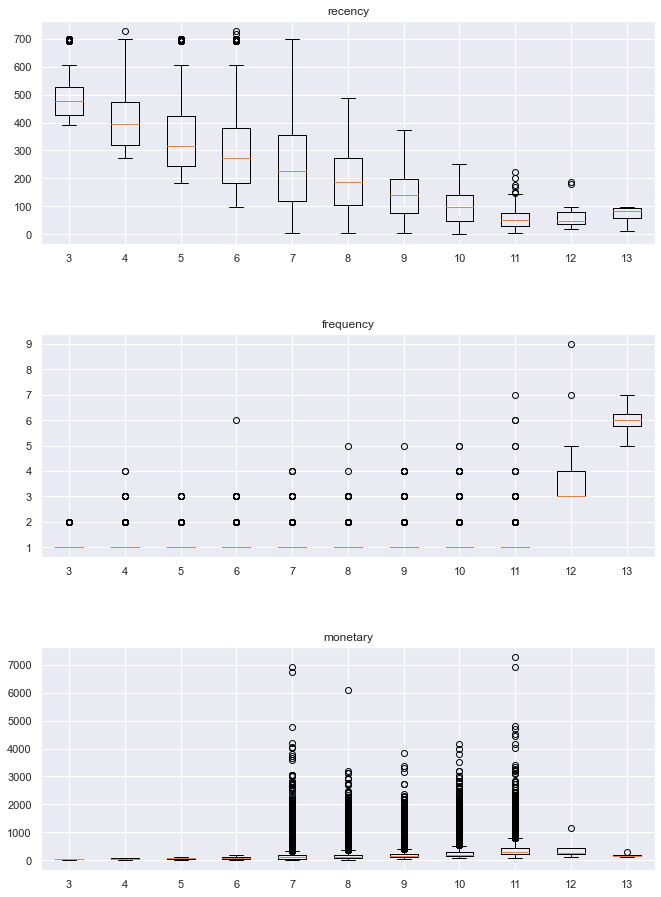

In [64]:
data_boxplot(df_rfm,'rfm_score')

>**<font color=#F54620>Option 2</font>**
>
>On peut se donner un nombre maximum de groupes de client (sur la base des classes ***Scores RFM***) en fonction de contraintes économique et logistique de l'entreprise.

#### Segments RFM

In [65]:
Markdown("""
>On se propose de regrouper les **{rfm_score_unique}** classes Scores RFM en **5 classes** définies par des **Segments**.

On se base sur les statistiques suivantes pour expliciter au mieux les caractéristiques des **Segments**.
""".format(rfm_score_unique=len(rfm_score_labels)))


>On se propose de regrouper les **11** classes Scores RFM en **5 classes** définies par des **Segments**.

On se base sur les statistiques suivantes pour expliciter au mieux les caractéristiques des **Segments**.


In [66]:
# Moyenne des variables R, F, M par score
df_rfm_score = df_rfm.groupby('rfm_score').agg({'R': ['mean','median','min', 'max'],
                                                'F': ['mean','median','min', 'max'],
                                                'M': ['mean','median','min','max','count']}).round(1)
df_rfm_score

R                   F                   M                      
          mean median min max mean median min max mean median min max  count
rfm_score                                                                   
3          1.0      1   1   1  1.0      1   1   1  1.0      1   1   1   3993
4          1.5      1   1   2  1.0      1   1   2  1.5      2   1   2   7567
5          2.0      2   1   3  1.0      1   1   2  2.0      2   1   3  11834
6          2.5      3   1   4  1.0      1   1   4  2.5      2   1   4  14621
7          3.0      3   1   5  1.0      1   1   2  3.0      3   1   5  18816
8          3.5      3   1   5  1.0      1   1   3  3.5      4   1   5  15383
9          4.0      4   2   5  1.0      1   1   3  4.0      4   2   5  11425
10         4.5      5   3   5  1.0      1   1   3  4.5      4   3   5   7819
11         5.0      5   3   5  1.0      1   1   4  5.0      5   3   5   3939
12         4.8      5   3   5  2.4      2   2   5  4.8      5   3   5     17
13         5.0      5   5   5  3.8      4   3   4  4.2      4   4   5      4

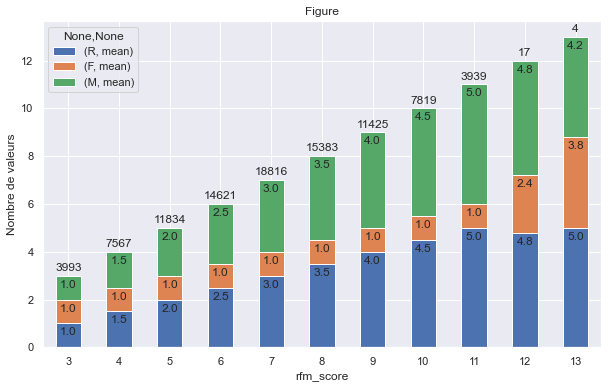

In [67]:
fig = df_rfm_score[[('R', 'mean'),('F', 'mean'),('M', 'mean')]].plot.bar(stacked=True, figsize=(10,6), rot=0)

df_rfm_score_2 = df_rfm_score[[('R', 'mean'),('F', 'mean'),('M', 'mean')]].reset_index()

for a,b in zip(df_rfm_score_2['rfm_score'],df_rfm_score[('R', 'mean')]):
    plt.text(a-3, b-0.5, str(b), fontsize=12, horizontalalignment='center')
    
for a,b,c in zip(df_rfm_score_2['rfm_score'],df_rfm_score[('R', 'mean')],df_rfm_score[('F', 'mean')]):
    plt.text(a-3, b+c-0.5, str(c), fontsize=12, horizontalalignment='center')
    
for a,b,c,d in zip(df_rfm_score_2['rfm_score'],df_rfm_score[('R', 'mean')],df_rfm_score[('F', 'mean')],df_rfm_score[('M', 'mean')]):
    plt.text(a-3, b+c+d-0.5, str(d), fontsize=12, horizontalalignment='center')
    
for a,b,c,d,e in zip(df_rfm_score_2['rfm_score'],df_rfm_score[('R', 'mean')],df_rfm_score[('F', 'mean')],df_rfm_score[('M', 'mean')],df_rfm_score[('M', 'count')]):
    plt.text(a-3, b+c+d+0.2, str(e),fontsize=12, horizontalalignment='center')

fig.set_title('Figure')
fig.set_ylabel('Nombre de valeurs')

plt.show()

In [68]:
list_segment = []
list_segment_name = []

for i in df_rfm['rfm_score'].values.tolist():
        if (i >= 12):
            list_segment_name.append('Très récent - Récurrent - Grand CA')
            list_segment.append(0)
        elif (i >= 9) and (i <= 11):
            list_segment_name.append('Très récent - Occasionnel - Grand CA')
            list_segment.append(1)
        elif (i >= 7) and (i <= 8):
            list_segment_name.append('Récent - Occasionnel - Moyen CA')
            list_segment.append(2)
        elif (i >= 5) and (i <= 6):
            list_segment_name.append('Ancien - Occasionnel - Moyen CA')
            list_segment.append(3)
        else:
            list_segment_name.append('Ancien - Occasionnel - Petit CA')
            list_segment.append(4)

In [69]:
df_rfm = df_rfm.assign(segment = list_segment)
df_rfm = df_rfm.assign(segment_name = list_segment_name)

In [70]:
df_rfm.shape

(95418, 22)

#### Statistiques Segments RFM

Nous avons maintenant regroupé les clients en **5 Segments** dont les principales variables présentent les statistiques suivantes.

In [71]:
df_rfm_segment = df_rfm.groupby('segment').agg({'recency': ['mean','median','min','max'],
                                                'duration': ['mean','median','min','max'],
                                                'start': 'min',
                                                'end': 'max',
                                                'frequency': ['mean','median','min','max'],
                                                'monetary': ['mean','median','min','max','count'],
                                                'segment_name': 'first'}).round(1)

df_rfm_segment['cust_count'] = df_rfm_segment[('monetary', 'count')]
del df_rfm_segment[('monetary', 'count')]

df_rfm_segment[['recency','frequency','monetary','cust_count','segment_name']]

recency                      frequency                  monetary  \
           mean median    min    max      mean median  min  max     mean   
segment                                                                    
0          66.6   48.0   11.0  188.0       4.4    4.0  3.0  9.0    314.5   
1         109.3   97.0    0.0  375.0       1.0    1.0  1.0  7.0    281.0   
2         218.8  206.0    5.0  699.0       1.0    1.0  1.0  5.0    177.1   
3         311.7  285.0   99.0  729.0       1.0    1.0  1.0  6.0     83.0   
4         430.0  431.0  274.0  728.0       1.0    1.0  1.0  4.0     50.0   

                              cust_count                          segment_name  
        median    min     max                                            first  
segment                                                                         
0        260.1  108.4  1164.0         21    Très récent - Récurrent - Grand CA  
1        199.3   58.5  7274.9      23183  Très récent - Occasionnel - Grand CA  
2        117.5    9.6  6929.3      34199       Récent - Occasionnel - Moyen CA  
3         75.1   12.9   202.5      26455       Ancien - Occasionnel - Moyen CA  
4         47.6   10.1    85.8      11560       Ancien - Occasionnel - Petit CA

Le regroupement que nous avons opéré conduit à 5 segments dont la répartition des individus est cohérente exceptée pour un groupe qui contient très peu d'individus.

**Traitement sans filtrage**

>Lors du traitement sans filtrage, **2 clients** constituent à eux seuls un groupe.

Ce sont les **2 seuls clients** qui totalisent un score de **12** mais l'un grâce à sa **récence** et sa **fréquence** et l'autre grâce à sa **récence** et son **montant**.

>Ceci montre les limites de la répartition par **Scores RFM**

**Traitement avec filtrage**

On considère les **2 clients** identifiés lors du traitement sans filtrage comme des ***outliers***.

>D'un point de vue de la stratégie commerciale, nous recommandons de les traiter individuellement.

>Nous réalisons donc les études de partionnement en écartant ces 2 clients (cf. <a href="#fil_ind">Filtrage des individus</a>)

In [72]:
df_rfm[['recency','frequency','monetary','R','F','M','rfm_score','segment_name']].sort_values('rfm_score', ascending = False).head()

,recency,frequency,monetary,R,F,M,rfm_score,segment_name
customer_unique_id,,,,,,,,
dc813062e0fc23409cd255f7f53c7074,11.0,6.0,172.270000,5,4,4,13,Très récent - Récurrent - Grand CA
63cfc61cee11cbe306bff5857d00bfe4,98.0,6.0,137.720000,5,4,4,13,Très récent - Récurrent - Grand CA
ca77025e7201e3b30c44b472ff346268,94.0,7.0,160.388571,5,4,4,13,Très récent - Récurrent - Grand CA
fe81bb32c243a86b2f86fbf053fe6140,74.0,5.0,318.152000,5,3,5,13,Très récent - Récurrent - Grand CA
7849336c1b7785f258ffef06aedbd216,41.0,3.0,207.520000,5,2,5,12,Très récent - Récurrent - Grand CA


In [73]:
# On souhaite concaténer les segments et le nombre d'individus par groupe avec les noms de segments
df_rfm_segment.reset_index(inplace=True)
# On transforme les variables utiles en str
df_rfm_segment[('segment', )] = df_rfm_segment[('segment', )].astype('str')
df_rfm_segment[('cust_count', )] = df_rfm_segment[('cust_count', )].astype('str')
# Concaténation
df_rfm_segment['segment_n'] = '[' + df_rfm_segment[('segment', )] + '] ' + df_rfm_segment[('segment_name', 'first')] + ' (' + df_rfm_segment[('cust_count', )] + ')'

del df_rfm_segment[('segment_name', 'first')]
df_rfm_segment[('cust_count', )] = df_rfm_segment[('cust_count', )].astype('int64')

df_rfm_segment.rename(columns={'segment_n': 'segment_name'}, inplace = True)

list_segment = df_rfm_segment.reset_index()[('segment')].tolist()
list_segment_name = df_rfm_segment['segment_name'].tolist()

df_rfm_segment.set_index('segment', inplace=True)

print(list_segment)
list_segment_name

['0', '1', '2', '3', '4']


['[0] Très récent - Récurrent - Grand CA (21)',
 '[1] Très récent - Occasionnel - Grand CA (23183)',
 '[2] Récent - Occasionnel - Moyen CA (34199)',
 '[3] Ancien - Occasionnel - Moyen CA (26455)',
 '[4] Ancien - Occasionnel - Petit CA (11560)']

In [74]:
df_rfm_segment[['recency','frequency','monetary','cust_count','segment_name']]

recency                      frequency                  monetary  \
           mean median    min    max      mean median  min  max     mean   
segment                                                                    
0          66.6   48.0   11.0  188.0       4.4    4.0  3.0  9.0    314.5   
1         109.3   97.0    0.0  375.0       1.0    1.0  1.0  7.0    281.0   
2         218.8  206.0    5.0  699.0       1.0    1.0  1.0  5.0    177.1   
3         311.7  285.0   99.0  729.0       1.0    1.0  1.0  6.0     83.0   
4         430.0  431.0  274.0  728.0       1.0    1.0  1.0  4.0     50.0   

                              cust_count  \
        median    min     max              
segment                                    
0        260.1  108.4  1164.0         21   
1        199.3   58.5  7274.9      23183   
2        117.5    9.6  6929.3      34199   
3         75.1   12.9   202.5      26455   
4         47.6   10.1    85.8      11560   

                                             segment_name  
                                                           
segment                                                    
0             [0] Très récent - Récurrent - Grand CA (21)  
1        [1] Très récent - Occasionnel - Grand CA (23183)  
2             [2] Récent - Occasionnel - Moyen CA (34199)  
3             [3] Ancien - Occasionnel - Moyen CA (26455)  
4             [4] Ancien - Occasionnel - Petit CA (11560)

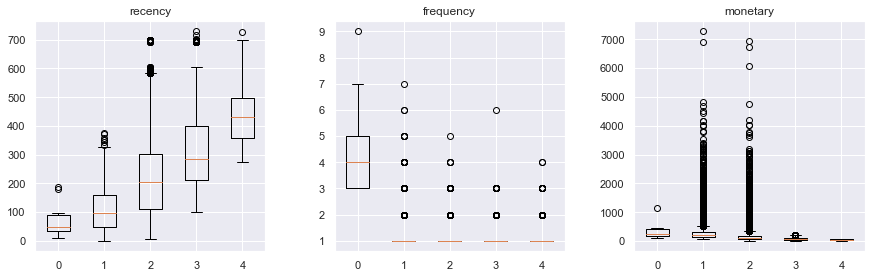

In [75]:
data_boxplot(df_rfm,'segment',1)

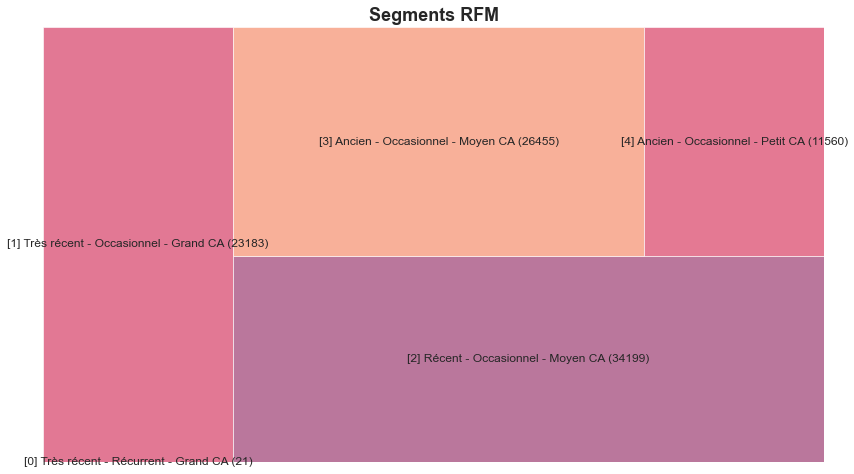

In [76]:
# Création du graphique
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 8)

squarify.plot(sizes=df_rfm_segment['cust_count'], 
              label=list_segment_name,
              alpha=.6)

plt.title('Segments RFM',fontsize=18,fontweight='bold')
plt.axis('off')
plt.show()

>**<font color=#F54620>Option 3</font>**
>
>On peut baser la segmentation sur une stratégie marketing définie.
>
>Cette approche permet de minimiser le regroupement d'individus avec des caractéristiques RFM opposées (segmentation Scores RFM).

In [77]:
df_rfm.shape

(95418, 22)

In [78]:
time_calc('Segmentation - RFM')
t = time.time()

Durée de l'opération 'Segmentation - RFM': 3.99 s
Durée totale de traitement: 00 h 00 m 08 s


### Segmentation stratégique

In [79]:
df_RFM = df_rfm[['R','F','M','RFM','rfm_score']]
df_RFM_2 = df_RFM.groupby(['rfm_score','RFM']).agg(lambda x:x.value_counts().index[0])
df_RFM_2

R  F  M
rfm_score RFM         
3         111  1  1  1
4         112  1  1  2
          121  1  2  1
          211  2  1  1
5         113  1  1  3
...           .. .. ..
12        525  5  2  5
          534  5  3  4
          543  5  4  3
13        535  5  3  5
          544  5  4  4

[64 rows x 3 columns]

Ce sont donc les directives marketing qui imposent la segmentation selon des règles d'affaires.

**Exemple**

Nombre de groupes: 8

La segmentation des clients doit aboutir à 8 groupes.

Chaque groupe possède des règles spécifiques.



##### Top clients N1 - clients récents / commandes récurrentes / grand CA

In [80]:
segment_name = 'Top clients N1 - clients récents / commandes récurrentes / grand CA'

df_seg_1 = df_RFM_2[(df_RFM_2['R'] >= 4)
                  & (df_RFM_2['F'] != 1)
                  & (df_RFM_2['M'] >= 4)]

list_seg = []
list_seg_name = []
for i in df_seg_1['R']:
    list_seg.append(0)
    list_seg_name.append(segment_name)

df_seg_1 = df_seg_1.assign(segment = list_seg)
df_seg_1 = df_seg_1.assign(segment_name = list_seg_name)
df_seg_1 = df_seg_1.reset_index()[['RFM','segment','segment_name']]

##### Top clients N2 - clients récents / commandes ponctuelles / grand CA

In [81]:
segment_name = 'Top clients N2 - clients récents / commandes ponctuelles / grand CA'

df_seg_2 = df_RFM_2[(df_RFM_2['R'] >= 4)
                  & (df_RFM_2['F'] == 1)
                  & (df_RFM_2['M'] >= 4)]

list_seg = []
list_seg_name = []
for i in df_seg_2['R']:
    list_seg.append(1)
    list_seg_name.append(segment_name)

df_seg_2 = df_seg_2.assign(segment = list_seg)
df_seg_2 = df_seg_2.assign(segment_name = list_seg_name)
df_seg_2 = df_seg_2.reset_index()[['RFM','segment','segment_name']]

##### Bons clients N1 - clients moins récents / commandes récurrentes / moyen à grand CA

In [82]:
segment_name = 'Bons clients N1 - clients moins récents / commandes récurrentes / moyen à grand CA'

df_seg_3 = df_RFM_2[(df_RFM_2['R'] >= 2) & (df_RFM_2['R'] <= 3)
                  & (df_RFM_2['F'] != 1)
                  & (df_RFM_2['M'] >= 2) & (df_RFM_2['M'] <= 5)]

list_seg = []
list_seg_name = []
for i in df_seg_3['R']:
    list_seg.append(2)
    list_seg_name.append(segment_name)

df_seg_3 = df_seg_3.assign(segment = list_seg)
df_seg_3 = df_seg_3.assign(segment_name = list_seg_name)
df_seg_3 = df_seg_3.reset_index()[['RFM','segment','segment_name']]

##### Bons clients N2 - clients moins récents / commandes ponctuelles / moyen à grand CA

In [83]:
segment_name = 'Bons clients N2 - clients moins récents / commandes ponctuelles / moyen à grand CA'

df_seg_4 = df_RFM_2[(df_RFM_2['R'] >= 2) & (df_RFM_2['R'] <= 3)
                  & (df_RFM_2['F'] == 1)
                  & (df_RFM_2['M'] >= 2) & (df_RFM_2['M'] <= 5)]

list_seg = []
list_seg_name = []
for i in df_seg_4['R']:
    list_seg.append(3)
    list_seg_name.append(segment_name)

df_seg_4 = df_seg_4.assign(segment = list_seg)
df_seg_4 = df_seg_4.assign(segment_name = list_seg_name)
df_seg_4 = df_seg_4.reset_index()[['RFM','segment','segment_name']]

##### Opportunité commerciale 1 - anciens clients / moyen à grand CA

In [84]:
segment_name = 'Opportunité commerciale 1 - anciens clients / moyen à grand CA'

df_seg_5 = df_RFM_2[(df_RFM_2['R'] == 1) 
                  & (df_RFM_2['M'] >= 2)]

list_seg = []
list_seg_name = []
for i in df_seg_5['R']:
    list_seg.append(4)
    list_seg_name.append(segment_name)

df_seg_5 = df_seg_5.assign(segment = list_seg)
df_seg_5 = df_seg_5.assign(segment_name = list_seg_name)
df_seg_5 = df_seg_5.reset_index()[['RFM','segment','segment_name']]

##### Opportunité commerciale 2 - clients récents / commandes récurrentes / petit à moyen CA

In [85]:
segment_name = 'Opportunité commerciale 2 - clients récents / commandes récurrentes / petit à moyen CA'

df_seg_6 = df_RFM_2[(df_RFM_2['R'] >= 4) 
                  & (df_RFM_2['F'] >= 2)
                  & (df_RFM_2['M'] <= 3)]

list_seg = []
list_seg_name = []
for i in df_seg_6['R']:
    list_seg.append(5)
    list_seg_name.append(segment_name)

df_seg_6 = df_seg_6.assign(segment = list_seg)
df_seg_6 = df_seg_6.assign(segment_name = list_seg_name)
df_seg_6 = df_seg_6.reset_index()[['RFM','segment','segment_name']]

##### Opportunité commerciale 3 - clients récents / commandes ponctuelles / petit à moyen CA

In [86]:
segment_name = 'Opportunité commerciale 3 - clients récents / commandes ponctuelles / petit à moyen CA'

df_seg_7 = df_RFM_2[(df_RFM_2['R'] >= 4) 
                  & (df_RFM_2['F'] == 1)
                  & (df_RFM_2['M'] <= 3)]

list_seg = []
list_seg_name = []
for i in df_seg_7['R']:
    list_seg.append(6)
    list_seg_name.append(segment_name)

df_seg_7 = df_seg_7.assign(segment = list_seg)
df_seg_7 = df_seg_7.assign(segment_name = list_seg_name)
df_seg_7 = df_seg_7.reset_index()[['RFM','segment','segment_name']]

##### Opportunité commerciale 3 - petit CA

In [87]:
segment_name = 'Opportunité commerciale 3 - petit CA'

df_seg_8 = df_RFM_2[(df_RFM_2['R'] <= 3) 
                  #& (df_RFM_2['F'] <= 2)
                  & (df_RFM_2['M'] == 1)]

list_seg = []
list_seg_name = []
for i in df_seg_8['R']:
    list_seg.append(7)
    list_seg_name.append(segment_name)

df_seg_8 = df_seg_8.assign(segment = list_seg)
df_seg_8 = df_seg_8.assign(segment_name = list_seg_name)
df_seg_8 = df_seg_8.reset_index()[['RFM','segment','segment_name']]

In [88]:
df_seg = pd.concat([df_seg_1,df_seg_2,df_seg_3,df_seg_4,df_seg_5,df_seg_6,df_seg_7,df_seg_8])
df_seg = df_seg.sort_values('RFM')
df_seg.reset_index(inplace=True)
del df_seg['index']
df_seg.head()

,RFM,segment,segment_name
0,111,7,Opportunité commerciale 3 - petit CA
1,112,4,Opportunité commerciale 1 - anciens clients / ...
2,113,4,Opportunité commerciale 1 - anciens clients / ...
3,114,4,Opportunité commerciale 1 - anciens clients / ...
4,115,4,Opportunité commerciale 1 - anciens clients / ...


On vérifie que chaque valeur de ***'RFM'*** soit associé à une **unique** valeur de ***'segment'***.

In [89]:
df_seg.duplicated(subset=['RFM']).sum()

0

In [90]:
df_seg_dup = pd.DataFrame(df_seg.duplicated(subset=['RFM']))
df_seg_dup = df_seg_dup.merge(df_seg, left_index = True, right_index = True)
df_seg_dup = df_seg_dup[df_seg_dup[0] == True]
df_seg_dup.merge(df_seg, left_on = 'RFM', right_on = 'RFM').sort_values(['RFM','segment_y'])[['RFM','segment_y','segment_name_y']]

,RFM,segment_y,segment_name_y


On vérifie qu'un segment a bien été associé à chaque valeur possible de ***'RFM'***.

In [91]:
df_RFM_3 = df_RFM_2.reset_index()[['RFM']].merge(df_seg, left_on = 'RFM', right_on = 'RFM', how = 'left').sort_values('segment')

In [92]:
# df_RFM_3 est le résultat de la fusion de df_RFM_2 avec df_seg avec une contrainte à gauche
# Si un individu de df_RFM_2 n'a pas de correspondance dans df_seg, la valeur de 'segment' dans df_RFM_3 sera nulle
# On vérifie donc que df_RFM_3 ne contient pas de valeur nulle
df_RFM_3.isna().sum()

RFM             0
segment         0
segment_name    0
dtype: int64

In [93]:
df_RFM_3[df_RFM_3['segment'].isna()]

,RFM,segment,segment_name


In [94]:
df_RFM_3['segment'].fillna(9, inplace=True)

In [95]:
df_RFM_3['segment_name'].fillna('Autre', inplace=True)

In [96]:
df_RFM_3[df_RFM_3['segment'].isna()]

,RFM,segment,segment_name


In [97]:
df_rfm.shape

(95418, 22)

On fusionne le dataframe ***df_rfm*** avec le dataframe ***df_RFM_3*** afin d'ajouter la variable **'segment'** à ***df_rfm***.

In [98]:
df_rfm.reset_index(inplace=True)
df_rfm = df_rfm.merge(df_RFM_3, left_on = 'RFM', right_on = 'RFM', how = 'left')

In [99]:
df_rfm[['recency','frequency','monetary','segment_x','segment_name_x','segment_y','segment_name_y']].head()

,recency,frequency,monetary,segment_x,segment_name_x,segment_y,segment_name_y
0,116.0,1.0,141.90,1,Très récent - Occasionnel - Grand CA,1,Top clients N2 - clients récents / commandes p...
1,119.0,1.0,27.19,3,Ancien - Occasionnel - Moyen CA,6,Opportunité commerciale 3 - clients récents / ...
2,542.0,1.0,86.22,3,Ancien - Occasionnel - Moyen CA,4,Opportunité commerciale 1 - anciens clients / ...
3,326.0,1.0,43.62,4,Ancien - Occasionnel - Petit CA,7,Opportunité commerciale 3 - petit CA
4,293.0,1.0,196.89,2,Récent - Occasionnel - Moyen CA,3,Bons clients N2 - clients moins récents / comm...


In [100]:
df_rfm.shape

(95418, 25)

##### Statistiques Segmentation stratégique

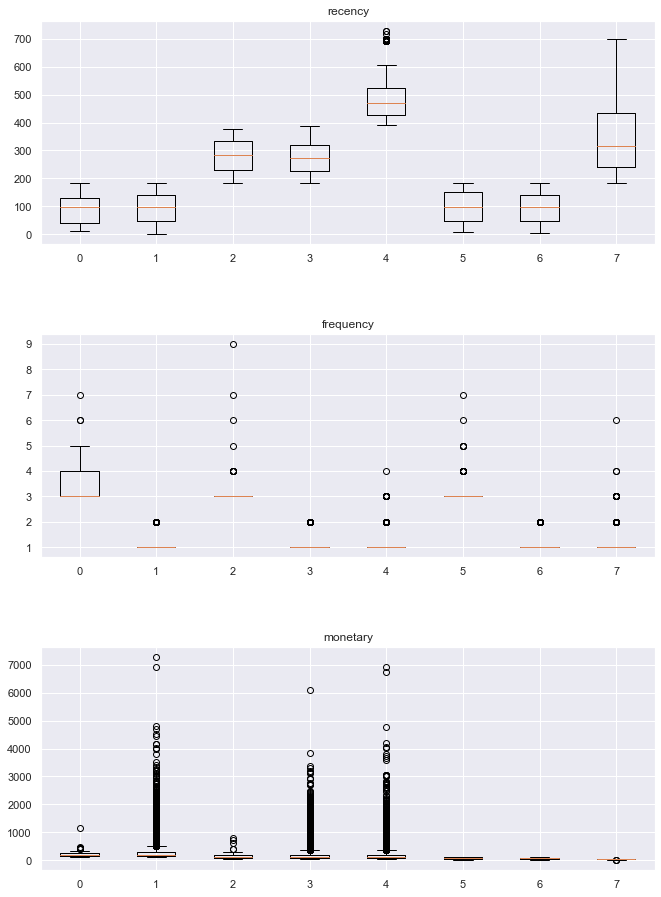

In [101]:
data_boxplot(df_rfm, 'segment_y')

In [102]:
time_calc('Segmentation stratégique - RFM')
t = time.time()

Durée de l'opération 'Segmentation stratégique - RFM': 1.75 s
Durée totale de traitement: 00 h 00 m 10 s


### Données RFM et Segments

***df_rfm*** contient maintenant l'ensemble des informations relatives à la segmentation RFM pour les 2 méthodes utilisées:
+ Segmentation RFM statistique (segment_x)
+ Segmentation RFM stratégique (segment_y)

In [103]:
df_rfm[['recency','frequency','monetary','RFM','rfm_score','segment_x','segment_name_x','segment_y','segment_name_y']].head(2)

,recency,frequency,monetary,RFM,rfm_score,segment_x,segment_name_x,segment_y,segment_name_y
0,116.0,1.0,141.90,414,9,1,Très récent - Occasionnel - Grand CA,1,Top clients N2 - clients récents / commandes p...
1,119.0,1.0,27.19,411,6,3,Ancien - Occasionnel - Moyen CA,6,Opportunité commerciale 3 - clients récents / ...


On se propose d'extraire les variables textuelles (noms de segments) de ***df_rfm*** afin de l'alléger.

Pour cela on créé 2 dataframes contenant les valeurs uniques de noms de segments avec leur code de segments respectifs associés.

Ce code restant présent dans le dataframe principal, on pourra récupérer les noms de segments par jointure si nécessaire.

In [104]:
df_segment_x_group = df_rfm.groupby('segment_x').first()[['segment_name_x']]
df_segment_y_group = df_rfm.groupby('segment_y').first()[['segment_name_y']]

In [105]:
df_segment_x_group

,segment_name_x
segment_x,
0,Très récent - Récurrent - Grand CA
1,Très récent - Occasionnel - Grand CA
2,Récent - Occasionnel - Moyen CA
3,Ancien - Occasionnel - Moyen CA
4,Ancien - Occasionnel - Petit CA


In [106]:
df_segment_y_group

,segment_name_y
segment_y,
0,Top clients N1 - clients récents / commandes r...
1,Top clients N2 - clients récents / commandes p...
2,Bons clients N1 - clients moins récents / comm...
3,Bons clients N2 - clients moins récents / comm...
4,Opportunité commerciale 1 - anciens clients / ...
5,Opportunité commerciale 2 - clients récents / ...
6,Opportunité commerciale 3 - clients récents / ...
7,Opportunité commerciale 3 - petit CA


In [107]:
# On supprime les variables textuelles contenant les noms de segments
del df_rfm['segment_name_x']
del df_rfm['segment_name_y']

In [108]:
display_graph = 0

if display_graph == 1:
    
    title('title 1')

    df_rfm_graph_01 = df_rfm[['recency','older','frequency','score','monetary']]
    # Affichage des diagrammes de dispersion
    sns.pairplot(df_rfm_graph_01, height=3)
    plt.show()

In [109]:
df_rfm.head(2)

,customer_unique_id,start,end,older,recency,duration,frequency,frequency_2,prod_nb_avg,nb_prod_diff,...,price_total,same_loc,score,R,F,M,RFM,rfm_score,segment_x,segment_y
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,2018-05-10,116.0,116.0,1.0,1.0,1.0,1.0,1,...,141.90,0.0,5.0,4,1,4,414,9,1,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,2018-05-07,119.0,119.0,1.0,1.0,1.0,1.0,1,...,27.19,0.0,4.0,4,1,1,411,6,3,6


In [110]:
time_calc('Jeu de données final - RFM')
t = time.time()

Durée de l'opération 'Jeu de données final - RFM': 0.28 s
Durée totale de traitement: 00 h 00 m 10 s


## Clustering

### Initialisation

#### Paramètres

Les paramètres suivants suivant permettent d'activer/désactiver un process spécifique.

Cela concerne principalement les process longs que l'on veut pouvoir outrepasser lors de procédures d'analyse.

In [111]:
# k-means - Distortion par nombre de clusters
disto_1 = 0
# k-means - Calcul du coefficient de silhouette
silh_1 = 0
silh_2 = 0
# k-means - Evaluation de la stabilité (méthode 1)
stab_1 = 0
# k-means - Evaluation de la stabilité (méthode 2)
stab_2 = 1

# Détermination des personas
perso_ = 1

# k-modes - Nombre de clusters
kmod_cost_ = 0
# k-modes - Clustering
kmod_ = 0

# k-prototypes - Nombre de clusters
kpro_cost_ = 0
# k-prototypes - Clustering
kpro_ = 0

# DBSCAN - Clustering
dbs_ = 0

#### Jeux de données

Nous avons 3 jeux de données à disposition:
+ Le dataframe ***df_rfm*** qui contient les données RFM relatives aux clients
+ Le dataframe ***df_cat*** qui contient les catégories de produits achetés par les clients, sous forme normalisée
+ Le dataframe ***df_pay_type*** qui contient les types de paiements effectués par les clients, sous forme normalisée

Les classifieurs comme **K-Means** et **DBSCAN** ne permettent pas de traiter les variables catégorielles.
> Nous utiliserons alors les variables RFM.

Les classifieurs **K-Modes** et **K-Prototypes** permettent de traiter les données numériques et les données catégorielles.
> Nous utiliserons alors les variables RFM + les variables catégorielles.

##### Données RFM

In [112]:
df_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95418 entries, 0 to 95417
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customer_unique_id  95418 non-null  object        
 1   start               95418 non-null  datetime64[ns]
 2   end                 95418 non-null  datetime64[ns]
 3   older               95418 non-null  float64       
 4   recency             95418 non-null  float64       
 5   duration            95418 non-null  float64       
 6   frequency           95418 non-null  float64       
 7   frequency_2         95418 non-null  float64       
 8   prod_nb_avg         95418 non-null  float64       
 9   nb_prod_diff        95418 non-null  int64         
 10  nb_pay_type_diff    95418 non-null  int64         
 11  monetary            95418 non-null  float64       
 12  price_mean          95418 non-null  float64       
 13  price_total         95418 non-null  float64   

##### Catégories de produits

On récupère le dataframe ***df_cat*** depuis le store.

In [113]:
%store -r df_cat
df_cat.shape

(95420, 74)

On fusionne ***df_cat*** avec ***df_rfm*** afin d'écarter les clients non traités (suites aux diverses opérations de features engineering et au filtrage le cas échéant).

In [114]:
df_cat = df_cat.reset_index().merge(df_rfm[['customer_unique_id']],
                                    left_on = 'customer_unique_id', right_on = 'customer_unique_id',
                                    how = 'inner').set_index('customer_unique_id')
df_cat.shape

(95418, 74)

In [115]:
df_cat.iloc[0:2,0:6]

,x0_agro_industry_and_commerce,x0_air_conditioning,x0_art,x0_arts_and_craftmanship,x0_audio,x0_auto
customer_unique_id,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,0.0,0.0,0.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,0.0,0.0,0.0,0.0


On fait des copies de ***df_cat*** avec et sans **'customer_unique_id'** comme index pour usage ultérieur

In [116]:
df_cat_0 = df_cat.copy() # avec 'customer_unique_id' comme index
df_cat_1 = df_cat.reset_index().copy() # sans 'customer_unique_id' comme index

On calcule le nombre de produits achetés par catégorie.

**Niveau Lignes de commandes**

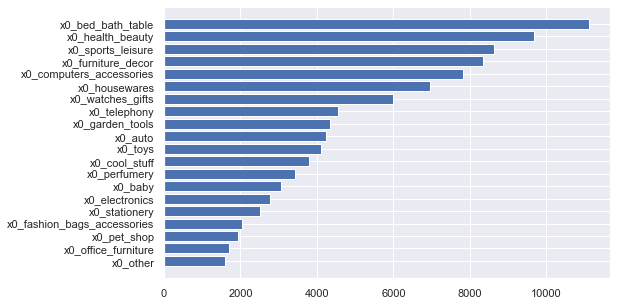

In [117]:
df_prod_qty = pd.DataFrame(df.iloc[:,26:200].sum(axis=0)).sort_values(0, ascending = True).reset_index().tail(20)

fig = plt.figure(figsize=(8, 5))
plt.barh(df_prod_qty['index'],df_prod_qty[0])
plt.show()

**Niveau Clients**

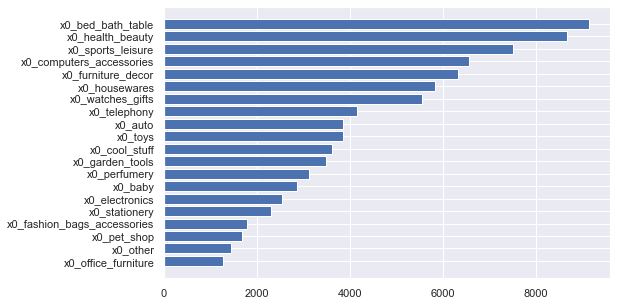

In [118]:
df_prod_qty = pd.DataFrame(df_cat.sum(axis=0)).sort_values(0, ascending = True).reset_index().tail(20)

fig = plt.figure(figsize=(8, 5))
plt.barh(df_prod_qty['index'],df_prod_qty[0])
plt.show()

##### Types de paiement

On récupère le dataframe ***df_pay_type*** depuis le store.

In [119]:
%store -r df_pay_type
df_pay_type.shape

(96096, 5)

On fusionne ***df_pay_type*** avec ***df_rfm*** afin d'écarter les clients non traités (suites aux diverses opérations de features engineering et au filtrage le cas échéant).

In [120]:
df_rfm_temp = df_rfm.set_index('customer_unique_id')
df_pay_type = df_pay_type.merge(df_rfm_temp['start'], left_index=True, right_index=True)
del df_pay_type['start']
df_pay_type.shape

(95418, 5)

In [121]:
df_pay_type.head(2)

,x0_boleto,x0_credit_card,x0_debit_card,x0_not_defined,x0_voucher
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,1.0,0.0,0.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,1.0,0.0,0.0,0.0


On fait des copies de ***df_pay_type*** avec et sans **'customer_unique_id'** comme index pour usage ultérieur

In [122]:
df_pay_type_0 = df_pay_type.copy() # avec 'customer_unique_id' comme index
df_pay_type_1 = df_pay_type.reset_index().copy() # sans 'customer_unique_id' comme index

#### Choix des variables

In [123]:
df_rfm.columns.tolist()

['customer_unique_id',
 'start',
 'end',
 'older',
 'recency',
 'duration',
 'frequency',
 'frequency_2',
 'prod_nb_avg',
 'nb_prod_diff',
 'nb_pay_type_diff',
 'monetary',
 'price_mean',
 'price_total',
 'same_loc',
 'score',
 'R',
 'F',
 'M',
 'RFM',
 'rfm_score',
 'segment_x',
 'segment_y']

In [124]:
# On choisit les variables numériques que l'on souhaite utiliser pour le clustering

list_var = ['customer_unique_id','recency','frequency','monetary','price_total']

### Variables numériques ###

# On définit le dataframe df_X à partir de df_rfm et de la liste des variables retenues
df_X = df_rfm[list_var]
# On définit 'customer_unique_id' en tant qu'index
df_X = df_X.set_index('customer_unique_id')
# Le dataframe df_X (variables numériques) sera utilisé avec K-Means et DBSCAN

In [125]:
df_X.head(1)

,recency,frequency,monetary,price_total
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,116.0,1.0,141.9,141.9


In [126]:
df_X.shape

(95418, 4)

In [127]:
time_calc('Initialisation - Clustering')
t = time.time()

Durée de l'opération 'Initialisation - Clustering': 1.54 s
Durée totale de traitement: 00 h 00 m 12 s


#### Standardisation des données

In [128]:
df_X.head(2)

,recency,frequency,monetary,price_total
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,116.0,1.0,141.90,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,119.0,1.0,27.19,27.19


In [129]:
from sklearn import preprocessing
X_std = preprocessing.scale(df_X)

In [130]:
X_std[:2]

array([[-0.83248397, -0.16469323, -0.08764627, -0.10706047],
       [-0.81289655, -0.16469323, -0.6166779 , -0.61895693]])

In [131]:
time_calc('Standardisation des données')
t = time.time()

Durée de l'opération 'Standardisation des données': 0.09 s
Durée totale de traitement: 00 h 00 m 12 s


#### Analyse en Composantes Principales

In [132]:
list_var

['customer_unique_id', 'recency', 'frequency', 'monetary', 'price_total']

In [133]:
X_std

array([[-0.83248397, -0.16469323, -0.08764627, -0.10706047],
       [-0.81289655, -0.16469323, -0.6166779 , -0.61895693],
       [ 1.94892947, -0.16469323, -0.34443714, -0.35553397],
       ...,
       [ 2.1513328 , -0.16469323, -0.22342076, -0.23843726],
       [-0.78025085, -0.16469323, -0.12551001, -0.14369781],
       [ 1.60288507, -0.16469323, -0.41204767, -0.42095461]])

In [135]:
from sklearn import decomposition
from sklearn.decomposition import PCA

n_c = len(list_var)-1

pca = decomposition.PCA(n_components = n_c) # Nombre de composantes = nombre de variables
X = pca.fit_transform(X_std)

var_cum = pca.explained_variance_ratio_.cumsum().max()
print('Nombre de dimensions:',n_c)
print('Variances expliquées cumulées:', round(var_cum,2))

Nombre de dimensions: 4
Variances expliquées cumulées: 1.0


In [136]:
df_X_pc = pd.DataFrame(X)

df_X_c_1 = df_X_pc.merge(df_cat_1, left_index=True, right_index=True)
del df_X_c_1['customer_unique_id']
X_c_1 = np.array(df_X_c_1)

df_X_c_2 = df_X_pc.merge(df_pay_type_1, left_index=True, right_index=True)
del df_X_c_2['customer_unique_id']
X_c_2 = np.array(df_X_c_2)

In [137]:
X_c_1.shape

(95418, 78)

In [138]:
X_c_2.shape

(95418, 9)

In [139]:
pd.DataFrame(X_c_1)

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
0,-0.147301,0.459438,-0.711698,0.001430,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.880860,0.493238,-0.657278,0.010559,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.515194,-1.424178,1.332942,0.006830,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-0.781569,-0.439944,0.321021,0.009725,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.199385,-0.355355,0.110485,-0.002539,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95413,12.155446,-1.837049,0.211505,-0.150925,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95414,-0.518021,-0.192755,0.026203,0.006333,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95415,-0.348274,-1.573720,1.471126,0.004815,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95416,-0.200020,0.427015,-0.670793,0.002101,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [140]:
pd.DataFrame(X_c_2)

,0,1,2,3,4,5,6,7,8
0,-0.147301,0.459438,-0.711698,0.001430,0.0,1.0,0.0,0.0,0.0
1,-0.880860,0.493238,-0.657278,0.010559,0.0,1.0,0.0,0.0,0.0
2,-0.515194,-1.424178,1.332942,0.006830,0.0,1.0,0.0,0.0,0.0
3,-0.781569,-0.439944,0.321021,0.009725,0.0,1.0,0.0,0.0,0.0
4,0.199385,-0.355355,0.110485,-0.002539,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
95413,12.155446,-1.837049,0.211505,-0.150925,0.0,1.0,0.0,0.0,0.0
95414,-0.518021,-0.192755,0.026203,0.006333,0.0,1.0,0.0,0.0,0.0
95415,-0.348274,-1.573720,1.471126,0.004815,0.0,1.0,0.0,0.0,0.0
95416,-0.200020,0.427015,-0.670793,0.002101,0.0,1.0,0.0,0.0,0.0


In [141]:
time_calc('Analyse en Composantes Principales')
t = time.time()

Durée de l'opération 'Analyse en Composantes Principales': 4.2 s
Durée totale de traitement: 00 h 00 m 16 s


#### Paramètres graphiques

In [142]:
dic_colors = {'c_index': [0,1,2,3,4,5,6,7,8,9,10,11,12,-1],
              'c_values': ['#E91E63','#1976D2','#FF9800',
                           '#00CC00','#00FFFF','#AF7AC5',
                           '#FFEB3B','#00FF00','#008080',
                           '#FF00FF','#FF0033','#800000',
                           '#808000','#C0C0C0'],
              'c_names': ['fuchsia','bleu','orange',
                          'vert','bleu (aqua)','violet',
                          'jaune','vert (lime)','turquoise',
                          'fuchsia (2)','rouge','marron',
                          'olive','gris']}

df_colors = pd.DataFrame(dic_colors)

In [143]:
def labels_colors(data_): 
    
    df_labels = pd.DataFrame(data_)
    df_labels = df_labels.reset_index()
    
    df_labels_colors = df_labels.merge(df_colors, left_on = 0, right_on = 'c_index', how = 'inner').sort_values('index')
    df_labels_colors = df_labels_colors[['index','c_values']]
    df_labels_colors = df_labels_colors.set_index('index')
    data_labels_colors = np.array(df_labels_colors['c_values'])
    
    return data_labels_colors

In [144]:
time_calc('Paramètres graphiques')
t = time.time()

Durée de l'opération 'Paramètres graphiques': 0.9 s
Durée totale de traitement: 00 h 00 m 17 s


### K-Means

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [145]:
from sklearn import cluster, metrics

#### Nombre optimal de clusters K-Means

##### Mesure de la distorsion

**Technique 1**

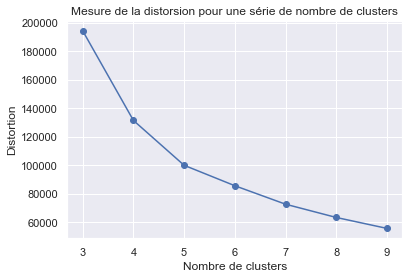

In [146]:
# Calcul de la distorsion pour une série de nombre de clusters
fig = plt.figure(figsize=(6, 4))

if disto_1 == 1:

    distortions = []

    for num_clusters in range(3, 10):

        kmea = cluster.KMeans(n_clusters=num_clusters,
                              init='random',
                              n_init=10,
                              max_iter=300,
                              tol=1e-04,
                              random_state=42)
        
        kmea.fit(X)
        
        distortions.append(kmea.inertia_)
        
    with open('km_elbow', 'wb') as fp:
        pickle.dump(distortions, fp)
    
elif disto_1 == 0:
    
    with open ('km_elbow', 'rb') as fp:
        distortions = pickle.load(fp)


plt.plot(range(3, 10), distortions, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Distortion')
plt.title('Mesure de la distorsion pour une série de nombre de clusters')
plt.show()

In [147]:
time_calc('Mesure distortions (1) - k-means','33.26')
t = time.time()

Durée de l'opération 'Mesure distortions (1) - k-means': 2.04 s
Durée totale de traitement: 00 h 00 m 19 s


**Technique 2**

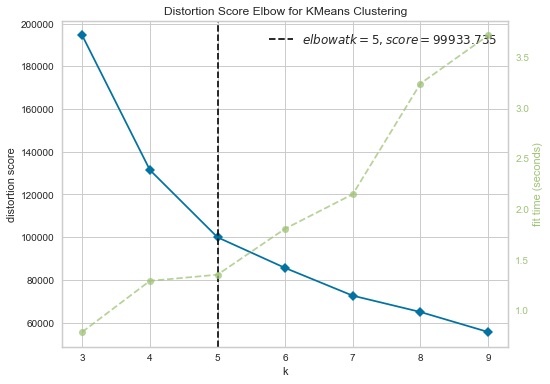

In [148]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

fig = plt.figure(figsize=(8, 6))

visualizer = KElbowVisualizer(KMeans(), k=(3,10))

visualizer.fit(X)
visualizer.show()
plt.show()

In [149]:
time_calc('Mesure distortions (2) - k-means')
t = time.time()

Durée de l'opération 'Mesure distortions (2) - k-means': 15.73 s
Durée totale de traitement: 00 h 00 m 35 s


##### Mesure de la variance inter-groupes et intra-groupe

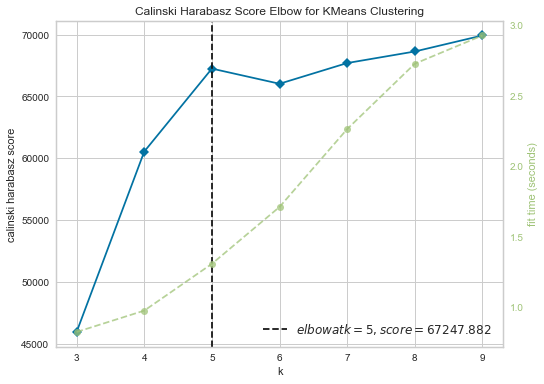

In [150]:
fig = plt.figure(figsize=(8, 6))

visualizer = KElbowVisualizer(KMeans(), metric='calinski_harabasz', k=(3,10))

visualizer.fit(X)
visualizer.show()
plt.show()

In [151]:
time_calc('Variances groupes (calinski_harabasz) - k-means')
t = time.time()

Durée de l'opération 'Variances groupes (calinski_harabasz) - k-means': 13.55 s
Durée totale de traitement: 00 h 00 m 48 s


##### Coefficient de silhouette

**Technique 1**

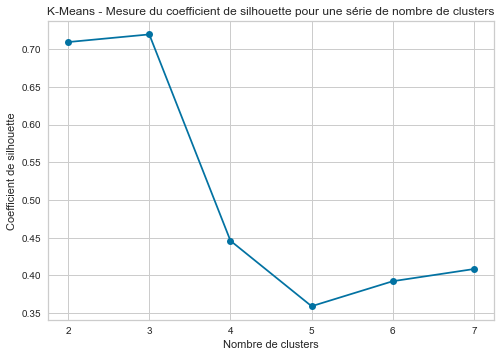

In [152]:
if silh_1 == 1:   
    
    silhouettes = []
    
    for num_clusters in range(2, 8):
        
        kmea = cluster.KMeans(n_clusters=num_clusters,
                              init='random',
                              n_init=10,
                              max_iter=300,
                              tol=1e-04,                              
                              random_state=42)
        kmea.fit(X)
        
        silh = metrics.silhouette_score(X, kmea.labels_)
        print('Nombre de clusters:',num_clusters,' - Coefficient de silhouette:',silh)
        silhouettes.append(silh)
        
    with open('km_silh', 'wb') as fp:
        pickle.dump(silhouettes, fp)
        
elif silh_1 == 0:
    
    with open ('km_silh', 'rb') as fp:
        silhouettes = pickle.load(fp)

plt.plot(range(2, 8), silhouettes, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Coefficient de silhouette')
plt.title('K-Means - Mesure du coefficient de silhouette pour une série de nombre de clusters')
plt.show()

In [153]:
time_calc('Coefficient de silhouette (1) - k-means', '688.20')
t = time.time()

Durée de l'opération 'Coefficient de silhouette (1) - k-means': 0.38 s
Durée totale de traitement: 00 h 00 m 49 s


**Technique 2**

In [154]:
if silh_2 == 1:
    
    fig = plt.figure(figsize=(8, 6))

    visualizer = KElbowVisualizer(KMeans(), metric='silhouette', k=(3,10))

    visualizer.fit(X)
    visualizer.show()
    plt.show()

In [155]:
time_calc('Coefficient de silhouette (2) - k-means','821.33 s')
t = time.time()

Durée de l'opération 'Coefficient de silhouette (2) - k-means': 0.03 s
Durée totale de traitement: 00 h 00 m 49 s


In [156]:
plt.style.use('ggplot')

#### Stabilité (1)

In [157]:
if stab_1 == 1:
    
    list_nb_clusters = [3,4,5,6]
    list_rd_state = [random.randint(0,500) for i in range(10)]
    # Choix du taux de dispersion
    scat_rate = 'ptp'

    # L'objectif est de lancer le process pour des k-means avec différents nombre de clusters et des random sate différents
    # On commence par itérer sur le nombre de clusters
    for nb_clusters in list_nb_clusters:

        # Les listes suivantes sont destinées à recevoir les différentes valeurs (moyennes) des variables pour chaque random state 
        list_rec_m_main = []
        list_fre_m_main = []
        list_mon_m_main = []
        list_mon_c_main = []    

        title = 'Nombre de clusters:'
        print(title, nb_clusters)
        print(len(title)*'-')
        print('')

        # Pour un nombre de clusters donné, on itère sur le random state
        # Autrement dit, on lance le process pour chaque random state
        # et on stocke les valeurs (moyennes et count) des variables considérées
        for rd_state in list_rd_state:

            list_rec_m = []
            list_fre_m = []
            list_mon_m = []
            list_mon_c = []

            # On lance le process
            kmea = cluster.KMeans(n_clusters=nb_clusters, n_init=10, random_state = rd_state).fit(X)
            # On créé un dataframe (1 variable) avec les valeurs de clustering (groupes)
            df_kmea = pd.DataFrame(kmea.labels_)
            # On ajoute les groupes au dataframe df_rfm
            df_rfm = df_rfm.assign(KM_group = df_kmea[0].values)
            # On produit les statistiques utiles (moyennes et count) par groupe
            df_KM_group_stats = df_rfm[['recency','frequency','monetary',
                                        'KM_group']].groupby('KM_group').agg({'recency': 'mean',
                                                                              'frequency': 'mean',
                                                                              'monetary': ['mean',
                                                                                           'count']}).sort_values(('monetary',
                                                                                                                   'count'))

            df_KM_group_stats_copy = df_KM_group_stats.copy()
            #df_KM_group_stats = preprocessing.scale(df_KM_group_stats)
            #df_KM_group_stats = pd.DataFrame(df_KM_group_stats)
            #df_KM_group_stats.columns = ['recency std','frequency std','monetary std','count std']     

            # Pour chaque groupe, on stocke les statistiques
            for i in range(0,nb_clusters):

                list_rec_m.append(df_KM_group_stats.iloc[i,0])            
                list_fre_m.append(df_KM_group_stats.iloc[i,1])           
                list_mon_m.append(df_KM_group_stats.iloc[i,2])           
                list_mon_c.append(df_KM_group_stats.iloc[i,3])

            # Une fois tous les random state testés, les listes suivantes contiendront
            # les valeurs statistiques des variables considérées, par groupe et par random state
            list_rec_m_main.append(list_rec_m)
            list_fre_m_main.append(list_fre_m)
            list_mon_m_main.append(list_mon_m)
            list_mon_c_main.append(list_mon_c)

        # L'objectif est maintenant d'évaluer la dispersion des valeurs des variables pour chaque groupe
        # Si la dispersion est importante pour un groupe, cela veut dire que les individus sont différents
        # pour ce groupe suivant le random state
        # A priori, si un groupe présente une grande dispersion, un deuxième groupe au minimum devrait
        # également présenter une dispersion plus ou moins importante

        # On transforme les listes en dataframe
        df_rec = pd.DataFrame(list_rec_m_main)
        df_fre = pd.DataFrame(list_fre_m_main)
        df_mon = pd.DataFrame(list_mon_m_main)
        df_mon_c = pd.DataFrame(list_mon_c_main)

        # On calcule un taux de dispersion sur les dataframes relatifs aux variables considérées
        # Le taux de dispersion peut être soit l'écart-type soit l'amplitude divisée par la moyenne

        # Cas où scat_rate = 'std' (écart-type)
        df_rec_std = pd.DataFrame(df_rec.std())
        df_fre_std = pd.DataFrame(df_fre.std())
        df_mon_std = pd.DataFrame(df_mon.std())
        df_mon_c_std = pd.DataFrame(df_mon_c.std())

        # Cas où scat_rate = 'ptp' (amplitude)       
        df_rec_ptp = pd.DataFrame(np.array(df_rec).ptp(axis=0) / df_rec.mean()) * 1000
        df_fre_ptp = pd.DataFrame(np.array(df_fre).ptp(axis=0) / df_fre.mean()) * 1000
        df_mon_ptp = pd.DataFrame(np.array(df_mon).ptp(axis=0) / df_mon.mean()) * 1000
        df_mon_c_ptp = pd.DataFrame(np.array(df_mon_c).ptp(axis=0) / df_mon_c.mean()) * 1000

        # On fusionne les dataframes
        # On obtient donc un dataframe avec en colonne les variables
        # et en lignes les groupes
        # Les valeurs représentent le taux de dispersion de la forme statistique (moyenne et count) des variables
        # dans chaque groupe pour le lancement du process avec plusieurs random state
        if scat_rate == 'std':            
            df_1 = df_rec_std.merge(df_fre_std, left_index=True, right_index=True)
            df_2 = df_1.merge(df_mon_std, left_index=True, right_index=True)
            df_3a = df_2.merge(df_mon_c_std, left_index=True, right_index=True)
            df_3a.columns = ['recency std','frequency std','monetary std','count std']

        elif scat_rate == 'ptp':
            df_1 = df_rec_ptp.merge(df_fre_ptp, left_index=True, right_index=True)
            df_2 = df_1.merge(df_mon_ptp, left_index=True, right_index=True)
            df_3a = df_2.merge(df_mon_c_ptp, left_index=True, right_index=True)
            df_3a.columns = ['recency ptp','frequency ptp','monetary ptp','count ptp']


        ###############
        ### Heatmap ###
        ###############

        # On récupère ici les taux de dispersion pour les représenter graphiquement dans une heatmap
        # Les taux de dispersion croissent avec la nuance de couleur (clair au foncé)
        title = 'Taux de dispersion pour l\'ensemble des variables'
        print(title)
        print(len(title)*'-')
        print('')
        print(df_3a.round(3)) 

        if scat_rate == 'std':
            df_4 = df_3a[['recency std','monetary std']]
        elif scat_rate == 'ptp':
            df_4 = df_3a[['recency ptp','monetary ptp','count ptp']]

        ax = sns.heatmap(df_4, cmap="YlGnBu")

        plt.show()
        print('')


        ################  
        ### Boxplots ###
        ################            

        # On récupère ici les valeurs originales des variables par groupe
        # afin de créer des boxplot qui permettront une analyse plus fine
        # des formes statistiques par variable et par groupe
        df_1 = df_rec.merge(df_fre, left_index=True, right_index=True)
        df_2 = df_1.merge(df_mon, left_index=True, right_index=True)
        df_3 = df_2.merge(df_mon_c, left_index=True, right_index=True)

        boxplots_ = 0
        if boxplots_ == 1:
            fig, axs = plt.subplots(4,nb_clusters)
            fig.subplots_adjust(left=0.08, right=2, bottom=0.05, top=3, hspace=0.4, wspace=0.3)

            for nbc in range(0,nb_clusters):

                label = np.str(nbc)
                axs[0,nbc].boxplot(np.array(df_3.iloc[:,nbc:nbc+1]))
                axs[0,nbc].set_title('recency')
                axs[0,nbc].set_xticklabels(label)

                axs[1,nbc].boxplot(np.array(df_3.iloc[:,nbc+nb_clusters:nbc+nb_clusters+1]))
                axs[1,nbc].set_title('frequency')
                axs[1,nbc].set_xticklabels(label)

                axs[2,nbc].boxplot(np.array(df_3.iloc[:,nbc+(2*nb_clusters):nbc+(2*nb_clusters)+1]))
                axs[2,nbc].set_title('monetary')
                axs[2,nbc].set_xticklabels(label)

                axs[3,nbc].boxplot(np.array(df_3.iloc[:,nbc+(3*nb_clusters):nbc+(3*nb_clusters)+1]))
                axs[3,nbc].set_title('count')
                axs[3,nbc].set_xticklabels(label)

            plt.show()
            print('')

    # Affichage des résultats intermédiaires du dernier test    
    details_ = 0
    if details_ == 1:   
        title = 'Dernier random state testé:'
        print(title, rd_state)
        print(len(title)*'-')
        print('')

        title = 'Statistiques (pour le dernier random state testé)'
        print(title)
        print(len(title)*'-')
        print('')
        print(df_KM_group_stats_copy)
        print('')

        title = 'Valeurs de count par groupe pour plusieurs process avec des random state différents'
        print(title)
        print(len(title)*'-')
        print('')
        print(df_mon_c)
        print('')

        title = 'On calcule le taux de dispersion de la variable count pour chaque groupe'
        print(title)
        print(len(title)*'-')
        print('')
        print(df_mon_c_ptp)  
        print('')
    
    del df_rfm['KM_group']

In [158]:
time_calc('Stabilité (1) - k-means','92.92')
t = time.time()

Durée de l'opération 'Stabilité (1) - k-means': 0.08 s
Durée totale de traitement: 00 h 00 m 49 s


In [159]:
import matplotlib.patches as mpatches

def data_c_plot(cls_1, cls_2, cls_cent_1 = 0, cls_cent_2 = 0):

    fig = plt.figure(figsize=(14, 6))

    # cls_1
    ax = fig.add_subplot(121)
    ax.scatter(X[:,0], X[:,1], c=labels_colors(cls_1), s=15)
    
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    
    if cls_cent_1 != 0:
        # Affichage des centroïdes
        ax.scatter(cls_cent_1.cluster_centers_[:,0], cls_cent_1.cluster_centers_[:,1], c='white', s=15)

    # Construction de la légende
    df_group_colors = pd.DataFrame(cls_1).set_index(0).merge(df_colors.set_index('c_index'),
                      left_index = True, right_index = True, 
                      how = 'inner').reset_index().groupby('index').first().reset_index().reset_index()

    list_legend = []
    for i in df_group_colors['level_0']:
        list_legend.append(mpatches.Patch(color = df_group_colors['c_values'][i], label = df_group_colors['index'][i]))
    plt.legend(handles=list_legend)

    # cls_2
    ax = fig.add_subplot(122)
    ax.scatter(X[:,0], X[:,1], c=labels_colors(cls_2), s=15)
    
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')

    if cls_cent_2 != 0:
        # Affichage des centroïdes
        ax.scatter(cls_cent_2.cluster_centers_[:,0], cls_cent_2.cluster_centers_[:,1], c='white', s=15)
        
    # Construction de la légende
    df_group_colors = pd.DataFrame(cls_2).set_index(0).merge(df_colors.set_index('c_index'),
                      left_index = True, right_index = True, 
                      how = 'inner').reset_index().groupby('index').first().reset_index().reset_index()

    list_legend = []
    for i in df_group_colors['level_0']:
        list_legend.append(mpatches.Patch(color = df_group_colors['c_values'][i], label = df_group_colors['index'][i]))
    plt.legend(handles=list_legend)

    plt.show()

In [160]:
import matplotlib.patches as mpatches

def data_c_plot_2(cls_1, cls_2, cls_3, cls_cent_1 = 0, cls_cent_2 = 0, cls_cent_3 = 0):

    fig = plt.figure(figsize=(14, 4))

    # cls_1
    ax = fig.add_subplot(131)
    ax.scatter(X[:,0], X[:,1], c=labels_colors(cls_1), s=5)
    
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    
    if cls_cent_1 != 0:
        # Affichage des centroïdes
        ax.scatter(cls_cent_1.cluster_centers_[:,0], cls_cent_1.cluster_centers_[:,1], c='white', s=10)

    # Construction de la légende
    df_group_colors = pd.DataFrame(cls_1).set_index(0).merge(df_colors.set_index('c_index'),
                      left_index = True, right_index = True, 
                      how = 'inner').reset_index().groupby('index').first().reset_index().reset_index()

    list_legend = []
    for i in df_group_colors['level_0']:
        list_legend.append(mpatches.Patch(color = df_group_colors['c_values'][i], label = df_group_colors['index'][i]))
    plt.legend(handles=list_legend)

    # cls_2
    ax = fig.add_subplot(132)
    ax.scatter(X[:,0], X[:,1], c=labels_colors(cls_2), s=5)
    
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')

    if cls_cent_2 != 0:
        # Affichage des centroïdes
        ax.scatter(cls_cent_2.cluster_centers_[:,0], cls_cent_2.cluster_centers_[:,1], c='white', s=10)
        
    # Construction de la légende
    df_group_colors = pd.DataFrame(cls_2).set_index(0).merge(df_colors.set_index('c_index'),
                      left_index = True, right_index = True, 
                      how = 'inner').reset_index().groupby('index').first().reset_index().reset_index()

    list_legend = []
    for i in df_group_colors['level_0']:
        list_legend.append(mpatches.Patch(color = df_group_colors['c_values'][i], label = df_group_colors['index'][i]))
    plt.legend(handles=list_legend)
    
    # cls_3
    ax = fig.add_subplot(133)
    ax.scatter(X[:,0], X[:,1], c=labels_colors(cls_3), s=5)
    
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')

    if cls_cent_3 != 0:
        # Affichage des centroïdes
        ax.scatter(cls_cent_3.cluster_centers_[:,0], cls_cent_3.cluster_centers_[:,1], c='white', s=10)
        
    # Construction de la légende
    df_group_colors = pd.DataFrame(cls_3).set_index(0).merge(df_colors.set_index('c_index'),
                      left_index = True, right_index = True, 
                      how = 'inner').reset_index().groupby('index').first().reset_index().reset_index()

    list_legend = []
    for i in df_group_colors['level_0']:
        list_legend.append(mpatches.Patch(color = df_group_colors['c_values'][i], label = df_group_colors['index'][i]))
    plt.legend(handles=list_legend)

    plt.show()

#### Stabilité (2)

Random state: 449


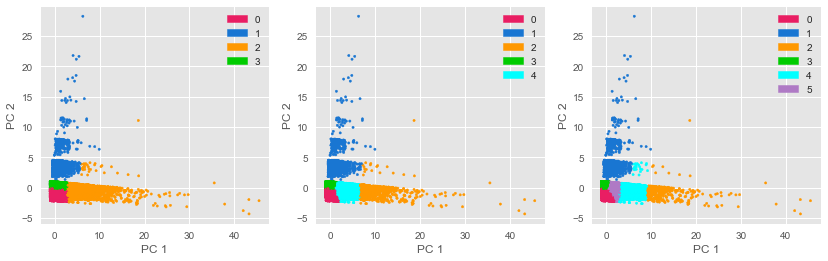

Random state: 166


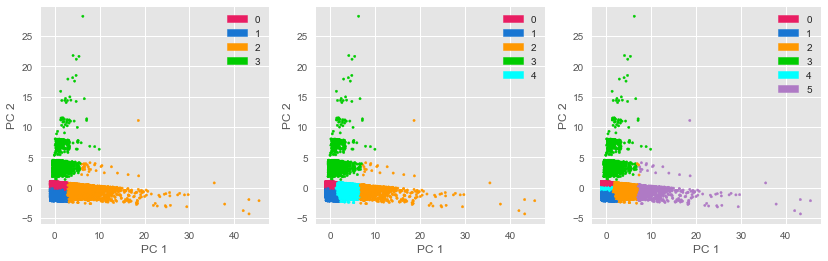

Random state: 42


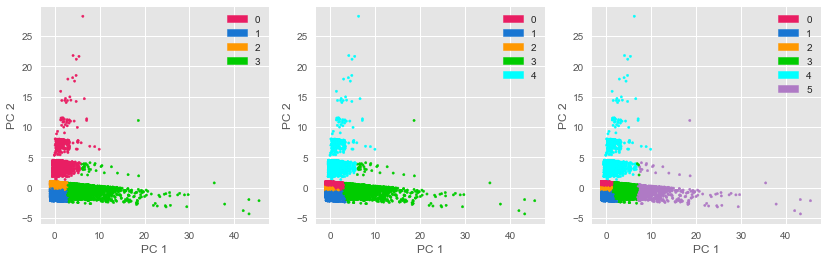

Random state: 39


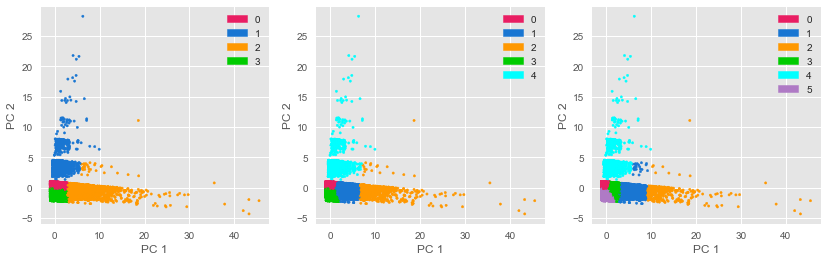

In [161]:
if stab_2 == 1:
    
    list_rd_state = [random.randint(0,500) for i in range(2)]
    list_rd_state.append(42) # pattern 1
    list_rd_state.append(39) # pattern 2

    for rd_state in list_rd_state:

        print('Random state:',rd_state)

        kmea4 = cluster.KMeans(n_clusters=4, n_init=1, random_state = rd_state).fit(X)
        kmea4_l = kmea4.labels_

        kmea5 = cluster.KMeans(n_clusters=5, n_init=1, random_state = rd_state).fit(X)
        kmea5_l = kmea5.labels_
        
        kmea6 = cluster.KMeans(n_clusters=6, n_init=1, random_state = rd_state).fit(X)
        kmea6_l = kmea6.labels_

        data_c_plot_2(kmea4_l, kmea5_l, kmea6_l)

In [162]:
time_calc('Stabilité (2) - k-means','167.87')
t = time.time()

Durée de l'opération 'Stabilité (2) - k-means': 34.4 s
Durée totale de traitement: 00 h 01 m 23 s


#### Clustering K-Means

Choix du random state.

In [163]:
random_state_ = 42

##### k-means (3 clusters)

In [164]:
kmea3 = cluster.KMeans(n_clusters=3, n_init=1, random_state=random_state_).fit(X)
kmea3_l = kmea3.labels_
pprint(kmea3.get_params())

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 3,
 'n_init': 1,
 'n_jobs': 'deprecated',
 'precompute_distances': 'deprecated',
 'random_state': 42,
 'tol': 0.0001,
 'verbose': 0}


In [165]:
time_calc('Clustering - k-means (3 cls)','1.47')
t = time.time()

Durée de l'opération 'Clustering - k-means (3 cls)': 0.2 s
Durée totale de traitement: 00 h 01 m 23 s


##### k-means (4 clusters)

In [166]:
kmea4 = cluster.KMeans(n_clusters=4, n_init=1, random_state=random_state_).fit(X)
kmea4_l = kmea4.labels_
pprint(kmea4.get_params())

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 4,
 'n_init': 1,
 'n_jobs': 'deprecated',
 'precompute_distances': 'deprecated',
 'random_state': 42,
 'tol': 0.0001,
 'verbose': 0}


In [167]:
time_calc('Clustering - k-means (4 cls)','2.5')
t = time.time()

Durée de l'opération 'Clustering - k-means (4 cls)': 0.25 s
Durée totale de traitement: 00 h 01 m 24 s


##### k-means (5 clusters)

In [168]:
kmea5 = cluster.KMeans(n_clusters=5, n_init=1, random_state=random_state_).fit(X)
kmea5_l = kmea5.labels_
pprint(kmea5.get_params())

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 5,
 'n_init': 1,
 'n_jobs': 'deprecated',
 'precompute_distances': 'deprecated',
 'random_state': 42,
 'tol': 0.0001,
 'verbose': 0}


In [169]:
time_calc('Clustering - k-means (5 cls)', '2.67')
t = time.time()

Durée de l'opération 'Clustering - k-means (5 cls)': 0.19 s
Durée totale de traitement: 00 h 01 m 24 s


##### k-means (6 clusters)

In [170]:
kmea6 = cluster.KMeans(n_clusters=6, n_init=1, random_state=random_state_).fit(X)
kmea6_l = kmea6.labels_
pprint(kmea6.get_params())

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 6,
 'n_init': 1,
 'n_jobs': 'deprecated',
 'precompute_distances': 'deprecated',
 'random_state': 42,
 'tol': 0.0001,
 'verbose': 0}


In [171]:
time_calc('Clustering - k-means (6 cls)','3.49')
t = time.time()

Durée de l'opération 'Clustering - k-means (6 cls)': 0.22 s
Durée totale de traitement: 00 h 01 m 24 s


##### k-means (7 clusters)

In [172]:
kmea7 = cluster.KMeans(n_clusters=7, n_init=1, random_state=random_state_).fit(X)
kmea7_l = kmea7.labels_
pprint(kmea6.get_params())

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 6,
 'n_init': 1,
 'n_jobs': 'deprecated',
 'precompute_distances': 'deprecated',
 'random_state': 42,
 'tol': 0.0001,
 'verbose': 0}


In [173]:
time_calc('Clustering - k-means (7 cls)', '3.67')
t = time.time()

Durée de l'opération 'Clustering - k-means (7 cls)': 0.25 s
Durée totale de traitement: 00 h 01 m 24 s


On rajoute les variables ***'KM_group'*** au dataframe ***df_rfm***.

In [174]:
df_kmea3 = pd.DataFrame(kmea3.labels_)
print('Groupes k-means (3):',df_kmea3[0].dropna().unique())
df_rfm = df_rfm.assign(KM_group_3 = df_kmea3[0].values)

Groupes k-means (3): [2 1 0]


In [175]:
df_kmea4 = pd.DataFrame(kmea4.labels_)
print('Groupes k-means (4):',df_kmea4[0].dropna().unique())
df_rfm = df_rfm.assign(KM_group_4 = df_kmea4[0].values)

Groupes k-means (4): [2 1 0 3]


In [176]:
df_kmea5 = pd.DataFrame(kmea5.labels_)
print('Groupes k-means (5):',df_kmea5[0].dropna().unique())
df_rfm = df_rfm.assign(KM_group_5 = df_kmea5[0].values)

Groupes k-means (5): [0 1 2 4 3]


In [177]:
df_kmea6 = pd.DataFrame(kmea6.labels_)
print('Groupes k-means (6):',df_kmea6[0].dropna().unique())
df_rfm = df_rfm.assign(KM_group_6 = df_kmea6[0].values)

Groupes k-means (6): [0 1 2 3 4 5]


In [178]:
df_kmea7 = pd.DataFrame(kmea7.labels_)
print('Groupes k-means (7):',df_kmea7[0].dropna().unique())
df_rfm = df_rfm.assign(KM_group_7 = df_kmea6[0].values)

Groupes k-means (7): [0 1 2 6 4 3 5]


#### Statistiques K-Means

La fonction suivante produit des statistiques par groupe.

In [179]:
def k_stats(K_group_,K_fit_):

    df_K_group_stats = df_rfm[['recency','frequency','monetary',
                                K_group_]].groupby(K_group_).agg({'recency': 'mean',
                                                                  'frequency': 'mean',
                                                                  'monetary': ['mean','count']})

    df_K_group_colors = pd.DataFrame(K_fit_.labels_).set_index(0).merge(df_colors.set_index('c_index'),
                                left_index = True, right_index = True,
                                how = 'inner').reset_index().rename(columns={'index': K_group_}).groupby(K_group_).first()

    df_K_group_c_stats = df_K_group_colors.merge(df_K_group_stats, left_index = True, right_index = True, how = 'inner')
    df_K_group_c_stats = df_K_group_c_stats.round(2)
    
    df_K_group_c_stats.columns = ['code couleur','couleur','recency_mean','frequency_mean','monetary_mean','Nombre de clients']

    df_K_group_c_stats.to_excel(K_group_ + '_c_stats.xlsx')

    return df_K_group_c_stats

La fonction suivante produit une heatmap avec les catégories sur l'axe des abscisses et les groupes sur l'axes des ordonnées.

On représente le pourcentage de catégories par groupe, c'est-à-dire le nombre de fois qu'une catégorie appartient à un groupe divisé par le nombre de clients du groupe.

Les catégories dépendent des choix initiaux:
+ Catégories de produits achetés par les clients
+ Types de paiement

In [180]:
def group_cat_heatmap(K_group_,K_fit_,nb_cust_=0):
    

    df_K_group_stats = df_rfm[['recency','frequency','monetary',
                                K_group_]].groupby(K_group_).agg({'recency': 'mean',
                                                                  'frequency': 'mean',
                                                                  'monetary': ['mean','count']})

    df_K_group_colors = pd.DataFrame(K_fit_.labels_).set_index(0).merge(df_colors.set_index('c_index'),
                                left_index = True, right_index = True,
                                how = 'inner').reset_index().rename(columns={'index': K_group_}).groupby(K_group_).first()

    df_K_group_c_stats = df_K_group_colors.merge(df_K_group_stats, left_index = True, right_index = True, how = 'inner')
    df_K_group_c_stats = df_K_group_c_stats.round(2)
    
    df_K_group_c_stats.columns = ['code couleur','couleur','recency','frequency','monetary','Nombre de clients']
    
    

    # grl pour groups/labels c'est-à-dire les catégories explicites contenues dans les groupes
    df_k_grl = df_rfm[['customer_unique_id',
                       K_group_]].merge(df_cat_1, left_on = 'customer_unique_id', right_on = 'customer_unique_id')

    # Tableau groupes/labels (catégories)
    df_k_grl_ = df_k_grl.groupby(K_group_).sum()
    gl_ = np.array(df_k_grl_)

    # Nombre de clients par groupe
    gc_ = np.array(df_K_group_c_stats[['Nombre de clients']]) # attention, récupération du dernier
                                                                 # df_K_group_c_stats_sh produit

    # On divise chaque valeur du tableau groupes/labels (catégories)
    # par le nombre de clients des groupes respectifs
    data = pd.DataFrame(100 * gl_ / gc_)

    # On renomme les colonnes (catégories)
    data.columns = df_k_grl_.columns.values.tolist()

    fig = plt.figure(figsize=(20, 2))
    ax = fig.add_subplot()
    ax = sns.heatmap(data, cmap="YlGnBu", robust = True)
    
    if nb_cust_ == 1:
        return df_K_group_c_stats[['Nombre de clients']]

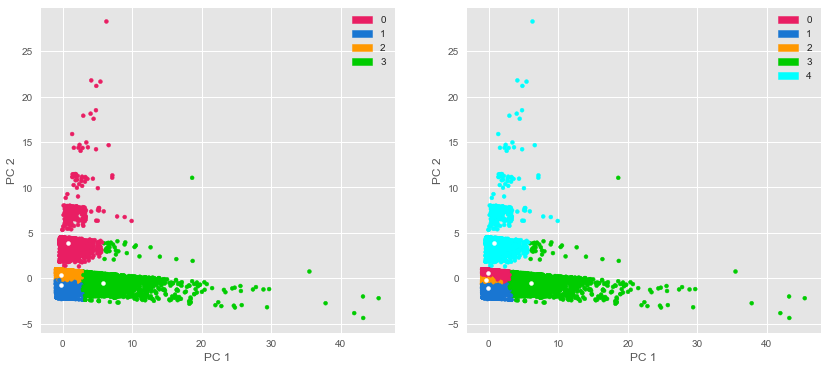

In [181]:
data_c_plot(kmea4_l,kmea5_l,kmea4,kmea5)

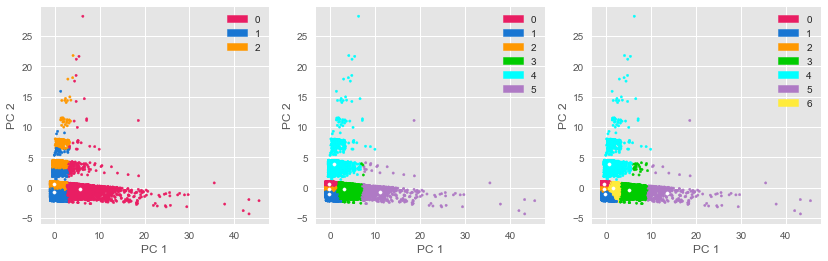

In [182]:
data_c_plot_2(kmea3_l,kmea6_l,kmea7_l,kmea3,kmea6,kmea7)

In [183]:
k_stats('KM_group_5',kmea5)

,code couleur,couleur,recency_mean,frequency_mean,monetary_mean,Nombre de clients
KM_group_5,,,,,,
0,#E91E63,fuchsia,93.48,1.00,153.10,34060
1,#1976D2,bleu,458.53,1.00,141.12,22282
2,#FF9800,orange,253.97,1.00,106.81,33447
3,#00CC00,vert,250.17,1.01,1101.52,2749
4,#00FFFF,bleu (aqua),226.16,2.11,136.73,2880


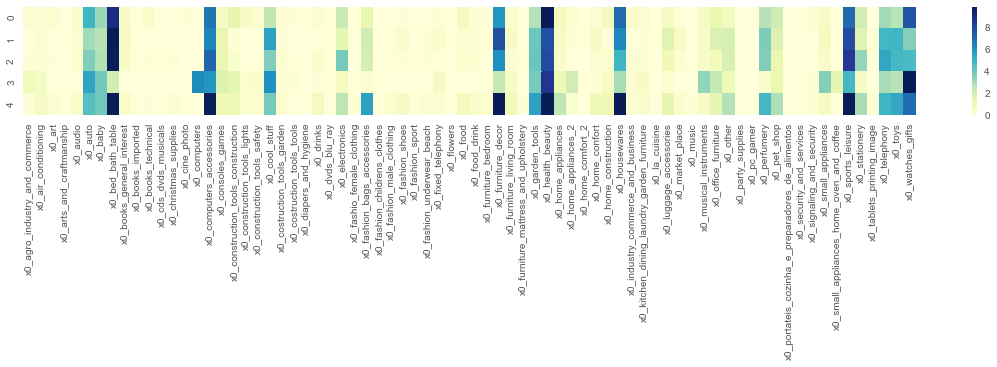

In [184]:
group_cat_heatmap('KM_group_5',kmea5)

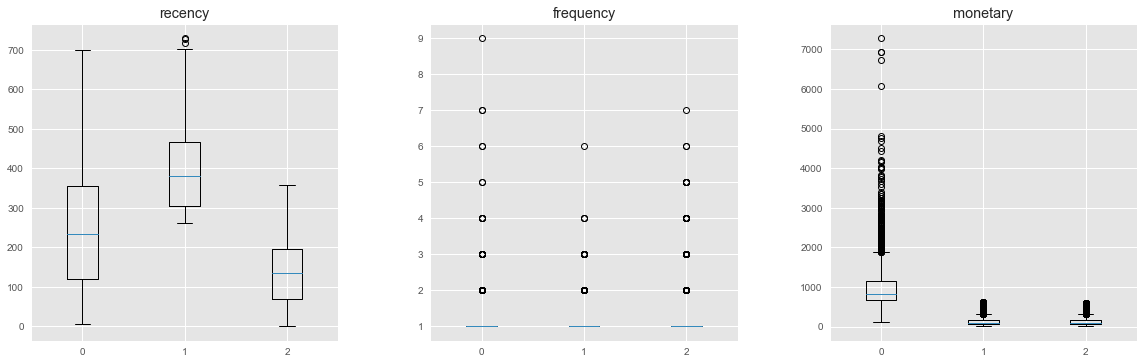

In [185]:
data_boxplot(df_rfm,'KM_group_3',1)

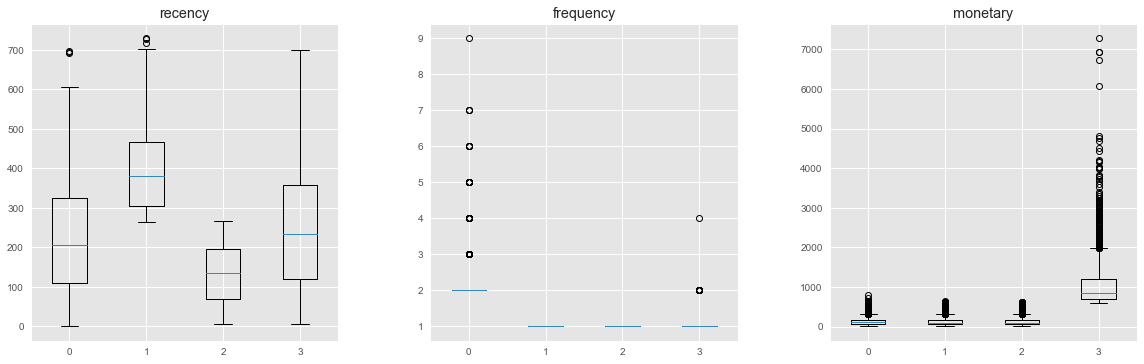

In [186]:
data_boxplot(df_rfm,'KM_group_4',1)

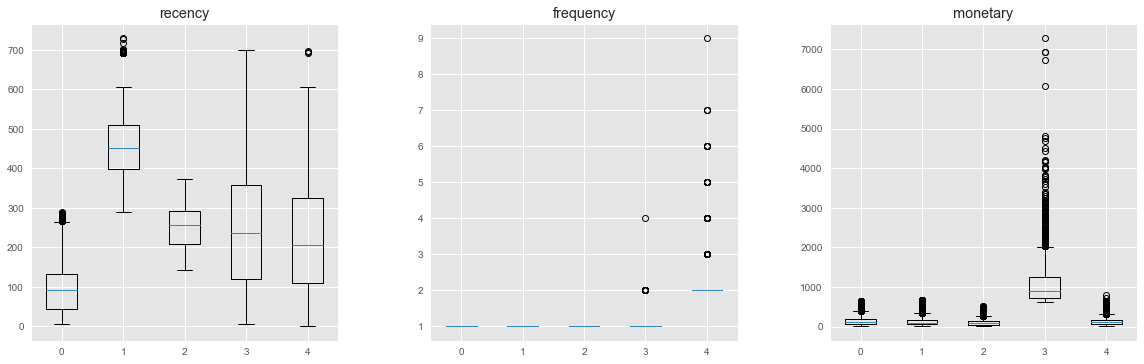

In [187]:
data_boxplot(df_rfm,'KM_group_5',1)

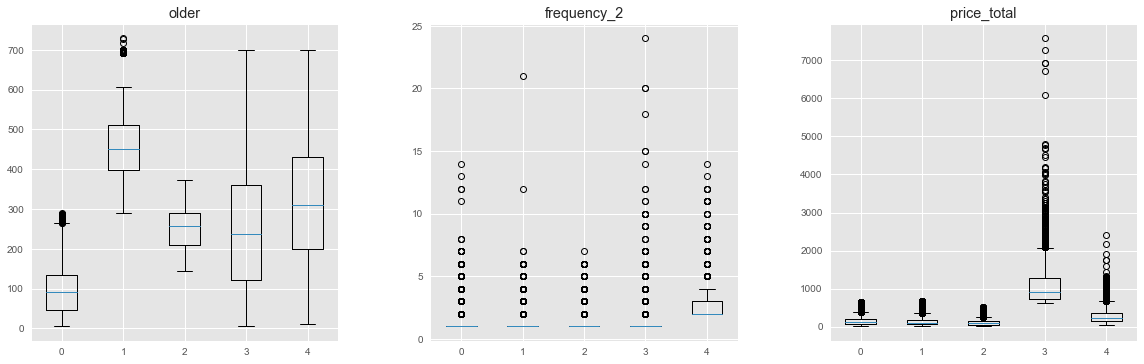

In [188]:
data_boxplot_2(df_rfm,'KM_group_5','older','frequency_2','price_total',1)

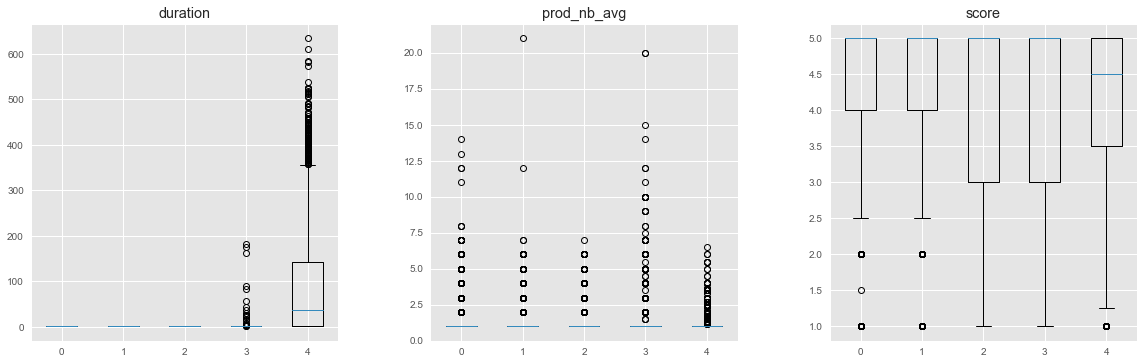

In [189]:
data_boxplot_2(df_rfm,'KM_group_5','duration','prod_nb_avg','score',1)

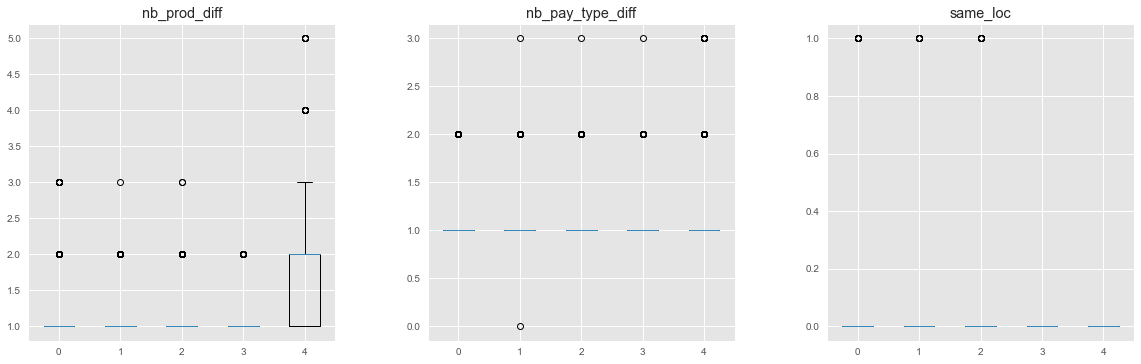

In [190]:
data_boxplot_2(df_rfm,'KM_group_5','nb_prod_diff','nb_pay_type_diff','same_loc',1)

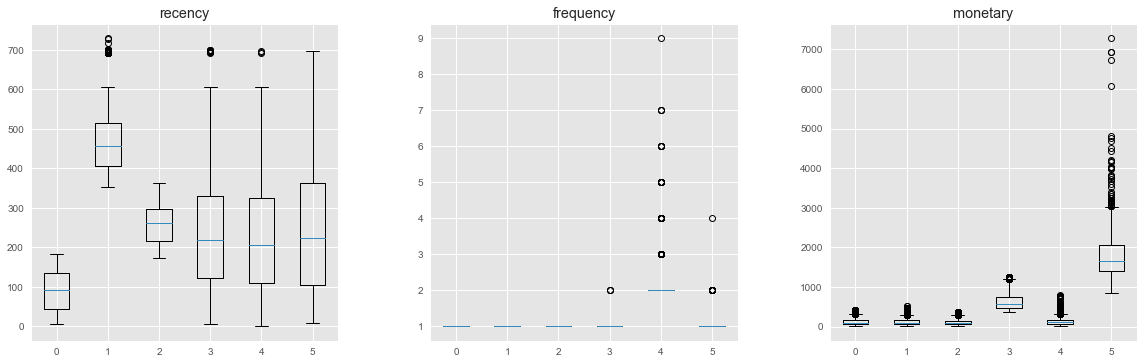

In [191]:
data_boxplot(df_rfm,'KM_group_6',1)

In [192]:
def var_mean_heatmap(k_group_):

    df_K_group_stats_std = df_rfm[['recency','duration','frequency','frequency_2',
                                       'monetary','price_total','price_mean','prod_nb_avg','nb_prod_diff','rfm_score',
                                       k_group_]].groupby(k_group_).agg({'recency': 'mean',
                                                                         'duration': 'mean',
                                                                         'frequency': 'mean',
                                                                         'frequency_2': 'mean',
                                                                         'monetary': ['mean','count'],
                                                                         'price_total': ['mean','count'],
                                                                         'price_mean': 'mean',
                                                                         'prod_nb_avg': 'mean',
                                                                         'nb_prod_diff': 'mean',
                                                                         'rfm_score': 'mean'})

    data = df_K_group_stats_std[[('recency', 'mean'),('duration', 'mean'),('frequency', 'mean'),('frequency_2', 'mean'),
                                 ('monetary', 'mean'),('price_total', 'mean'),('price_mean', 'mean'),('prod_nb_avg', 'mean'),('nb_prod_diff', 'mean'),
                                 ('rfm_score', 'mean')]]

    # Les valeurs de 'recency' ont un meilleur rfm_score quand elles sont petites et inversement
    # On inverse les valeurs de 'recency' afin d'être homogène avec les autres variables
    data[('recency', 'mean')] = 1 / (data[('recency', 'mean')] / 400)
    # On applique un coefficient aux variables pour homogénéiser les données
    data[('price_total', 'mean')] = data[('price_total', 'mean')] / 1000
    data[('price_mean', 'mean')] = data[('price_mean', 'mean')] / 1500
    data[('monetary', 'mean')] = data[('monetary', 'mean')] / 1500
    data[('duration', 'mean')] = data[('duration', 'mean')] / 70
    data[('frequency_2', 'mean')] = data[('frequency_2', 'mean')] / 2
    data[('prod_nb_avg', 'mean')] = data[('prod_nb_avg', 'mean')] / 2
    data[('nb_prod_diff', 'mean')] = data[('nb_prod_diff', 'mean')] / 2
    data[('rfm_score', 'mean')] = data[('rfm_score', 'mean')] / 10

    data.columns = [['recency','duration','frequency','frequency_2','monetary','price_total','price_mean',
                     'prod_nb_avg','nb_prod_diff','rfm_score']]

    ax = sns.heatmap(data.T, cmap="YlGnBu")
    #ax.imshow(data)
    #ax.invert_yaxis()
    ax.set_title('Moyennes des variables par groupe')

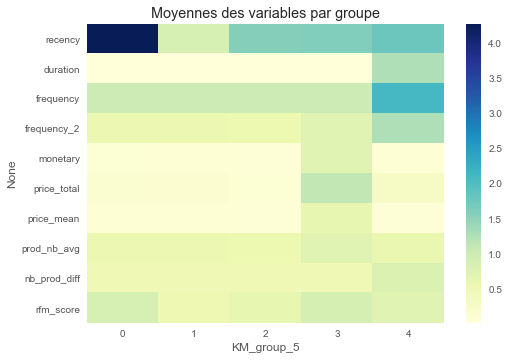

In [193]:
var_mean_heatmap('KM_group_5')

In [194]:
time_calc('Statistiques - k-means (5 cls)')
t = time.time()

Durée de l'opération 'Statistiques - k-means (5 cls)': 24.78 s
Durée totale de traitement: 00 h 01 m 49 s


#### Groupes explicites K-Means

In [195]:
df_KM_group_c_stats = pd.read_excel('KM_group_5_c_stats.xlsx')
df_KM_group_c_stats

,KM_group_5,code couleur,couleur,recency_mean,frequency_mean,monetary_mean,Nombre de clients
0,0,#E91E63,fuchsia,93.48,1.00,153.10,34060
1,1,#1976D2,bleu,458.53,1.00,141.12,22282
2,2,#FF9800,orange,253.97,1.00,106.81,33447
3,3,#00CC00,vert,250.17,1.01,1101.52,2749
4,4,#00FFFF,bleu (aqua),226.16,2.11,136.73,2880


On explicite les groupes.

In [196]:
list_KM_group_n = ['Ancien - Ponctuel - Petit CA',
                   'Très récent - Ponctuel - Petit CA',
                   'Récent - Récurrent - Moyen CA',
                   'Récent - Occasionnel - Très grand CA',
                   'Récent - Ponctuel - Grand CA']

In [197]:
KM_group_ = df_KM_group_c_stats.iloc[:,:1].columns.tolist()
df_KM_group_c_stats_n = df_KM_group_c_stats
df_KM_group_c_stats_n['KM_group_name'] = list_KM_group_n
df_KM_group_c_stats_n['KM_group_str'] = df_KM_group_c_stats_n[KM_group_].astype('str')
df_KM_group_c_stats_n['Nombre de clients_str'] = df_KM_group_c_stats_n['Nombre de clients'].astype('str')
df_KM_group_c_stats_n['KM_group_name'] = '[' + df_KM_group_c_stats_n['KM_group_str'] + '] ' + df_KM_group_c_stats_n['KM_group_name'] + ' (' + df_KM_group_c_stats_n['Nombre de clients_str'] + ')'
del df_KM_group_c_stats_n['KM_group_str']
del df_KM_group_c_stats_n['Nombre de clients_str']
df_KM_group_c_stats_n

,KM_group_5,code couleur,couleur,recency_mean,frequency_mean,monetary_mean,Nombre de clients,KM_group_name
0,0,#E91E63,fuchsia,93.48,1.00,153.10,34060,[0] Ancien - Ponctuel - Petit CA (34060)
1,1,#1976D2,bleu,458.53,1.00,141.12,22282,[1] Très récent - Ponctuel - Petit CA (22282)
2,2,#FF9800,orange,253.97,1.00,106.81,33447,[2] Récent - Récurrent - Moyen CA (33447)
3,3,#00CC00,vert,250.17,1.01,1101.52,2749,[3] Récent - Occasionnel - Très grand CA (2749)
4,4,#00FFFF,bleu (aqua),226.16,2.11,136.73,2880,[4] Récent - Ponctuel - Grand CA (2880)


In [198]:
time_calc('Groupes explicites - k-means (5 cls)')
t = time.time()

Durée de l'opération 'Groupes explicites - k-means (5 cls)': 0.11 s
Durée totale de traitement: 00 h 01 m 49 s


#### Identification des outliers

In [199]:
X_0 = -50
X_1 = 20

df_outlier_identif = pd.DataFrame(X[:,0:2])
df_outlier_identif = df_outlier_identif.merge(df_rfm, left_index = True, right_index = True)[['customer_unique_id',0,1,'R','F','M']]
df_outlier_identif[(df_outlier_identif[0] > X_0) & (df_outlier_identif[1] > X_1)]

,customer_unique_id,0,1,R,F,M
10280,1b6c7548a2a1f9037c1fd3ddfed95f33,4.822524,21.168603,3,4,4
23301,3e43e6105506432c953e165fb2acf44c,6.278498,28.257433,3,5,4
37531,6469f99c1f9dfae7733b25662e7f1782,4.101651,21.775934,5,4,3
75558,ca77025e7201e3b30c44b472ff346268,5.418098,21.641244,5,4,4


In [200]:
X_0 = 18
X_1 = 0

df_outlier_identif = pd.DataFrame(X[:,0:2])
df_outlier_identif = df_outlier_identif.merge(df_rfm, left_index = True, right_index = True)[['customer_unique_id',0,1,'R','F','M']]
df_outlier_identif[(df_outlier_identif[0] > X_0) & (df_outlier_identif[1] > X_1)]

,customer_unique_id,0,1,R,F,M
2014,055ec572ac7f3c7bdd04a183830ebe59,18.695065,1.919126,1,1,5
74750,c8460e4251689ba205045f3ea17884a1,18.619825,11.059791,5,2,5
81386,da122df9eeddfedc1dc1f5349a1a690c,35.495851,0.754065,1,1,5


In [201]:
df_outlier_identif[df_outlier_identif['customer_unique_id'] == 'fe81bb32c243a86b2f86fbf053fe6140']

,customer_unique_id,0,1,R,F,M
94861,fe81bb32c243a86b2f86fbf053fe6140,6.604371,14.650756,5,3,5


In [202]:
time_calc('Outliers - k-means (5 cls)')
t = time.time()

Durée de l'opération 'Outliers - k-means (5 cls)': 0.19 s
Durée totale de traitement: 00 h 01 m 49 s


#### Identification des personas

In [203]:
def data_boxplot_3(df,var_1,var_2,var_3,plot_format=1):
    
    if plot_format == 0:
    
        fig, axs = plt.subplots(3,1)
        fig.subplots_adjust(left=0.08, right=1.5, bottom=0.05, top=3, hspace=0.4, wspace=0.3)
    
    elif plot_format == 1:
        
        fig, axs = plt.subplots(1,3)
        fig.subplots_adjust(left=0.08, right=2, bottom=2.2, top=3, hspace=0.4, wspace=0.3)

    data = df[var_1]

    axs[0].boxplot(data)
    axs[0].set_title(var_1)
    axs[0].set_xticklabels(var_1)    

    data = df[var_2]

    axs[1].boxplot(data)
    axs[1].set_title(var_2)
    axs[1].set_xticklabels(var_2)
    
    data = df[var_3]

    axs[2].boxplot(data)
    axs[2].set_title(var_3)
    axs[2].set_xticklabels(var_3)    
        
    plt.show()

In [204]:
def cl_cent_perso(cs_, k_group = 'KM_group_5', nb_cust_ = 5, labels_ = 0, r_var_ = 0.5, export_ = 0):
    
    """Fonction d'identification des personas
    
       Les personas sont définis comme les clients les plus proches
       des centroïdes lors d'un clustering k-means
       
       Paramètres:
       - cs_ = centroïdes
       - k_group = nom de la variable de groupes
       - nb_cust_ = nombre de clients par groupe persona
       - labels_ = cluster
       - r_var_ = précision de l'encadrement des recherches"""

    results_number = 10**6
    r_ = 1
    
    while results_number > nb_cust_:     
                
        df_cs = pd.DataFrame(cs_ - np.abs(cs_ / r_)).merge(pd.DataFrame(cs_ + np.abs(cs_ / r_)),
                                                           left_index=True, right_index=True)

        X_0_inf = df_cs.loc[labels_,'0_x']
        X_0_sup = df_cs.loc[labels_,'0_y']
        X_1_inf = df_cs.loc[labels_,'1_x']
        X_1_sup = df_cs.loc[labels_,'1_y']
        X_2_inf = df_cs.loc[labels_,'2_x']
        X_2_sup = df_cs.loc[labels_,'2_y']

        df_perso = pd.DataFrame(X[:,0:3])
        df_perso = df_perso.merge(df_rfm, left_index = True, right_index = True)

        df_perso = df_perso.sort_values(1, ascending=False)

        df_perso = df_perso[(df_perso[0] > X_0_inf) & (df_perso[0] < X_0_sup)
                             & (df_perso[1] > X_1_inf) & (df_perso[1] < X_1_sup)
                             & (df_perso[2] > X_2_inf) & (df_perso[2] < X_2_sup)]

        results_number = df_perso.shape[0]
        
        r_ = r_ + r_var_     
        
        if export_ == 1:
            df_perso.to_excel('df_perso_' + str(labels_) + '.xlsx')

    df_perso = df_perso[['customer_unique_id',0,1,2,'recency','frequency','monetary','R','F','M',k_group]]  
    data_boxplot_3(df_perso,'recency','frequency','monetary')
        
    #print('r_ =', r_)
    #print('r_var =', r_var_)
    print('\nNombre de résultats:', results_number)
    
    print('\n',df_perso[['customer_unique_id','recency','frequency','monetary']].head())

In [205]:
perso_

1

### Persona 0

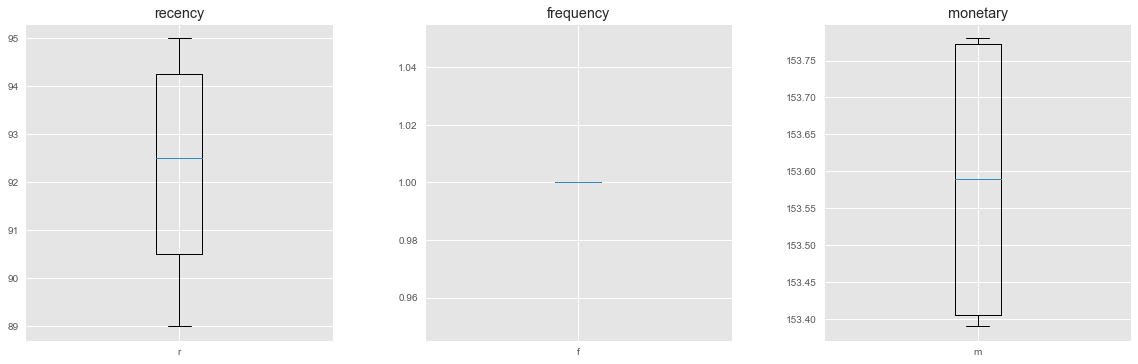


Nombre de résultats: 4

                      customer_unique_id  recency  frequency  monetary
27099  487a947b8681e2321b539300b74338d7     89.0        1.0    153.77
35681  5f55cf7eb7bec0007a9bbd2314103e00     91.0        1.0    153.41
5602   0f00ec227ecc76530782aa0fcb87f0e2     94.0        1.0    153.78
55476  94ed98d07905e2c34cc78f1683c84641     95.0        1.0    153.39


In [206]:
if perso_ == 1:
    cl_cent_perso(kmea5.cluster_centers_,'KM_group_5',5,0)

### Persona 1

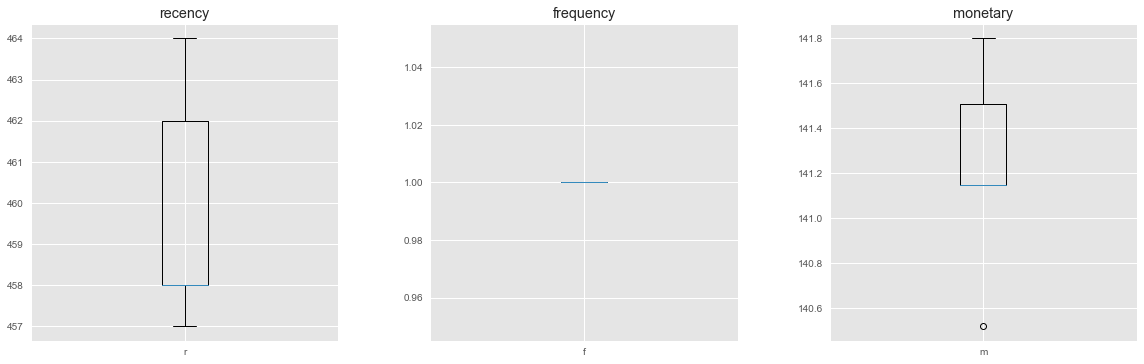


Nombre de résultats: 5

                      customer_unique_id  recency  frequency  monetary
19766  34d1f09eab8df30b699122c567f6ab32    457.0        1.0    141.15
59438  9f3b194c8a6491fd6af12b870cbb4674    458.0        1.0    141.15
74565  c7d52e92398362c2a379a234e140a992    458.0        1.0    141.80
24577  41c164545761474b81c42602c85b42cb    462.0        1.0    141.51
44230  767d7041157e4515032f24e3634ed01e    464.0        1.0    140.52


In [207]:
if perso_ == 1:
    cl_cent_perso(kmea5.cluster_centers_,'KM_group_5',5,1)

### Persona 2

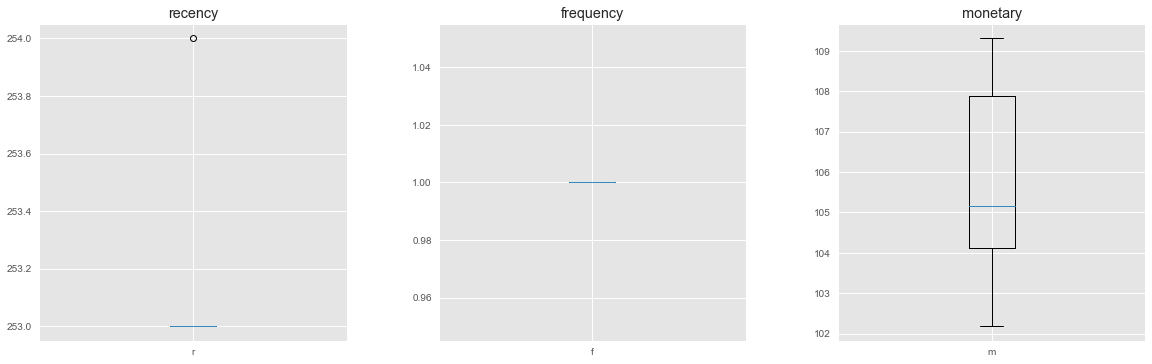


Nombre de résultats: 5

                      customer_unique_id  recency  frequency  monetary
65812  b0393dd04c5516902c42d133f56fcee2    253.0        1.0    102.18
84122  e16e99889e04b64fcd49b596afab2a33    253.0        1.0    104.12
89486  eff3fe4c7f245384022a2c4d7105e055    253.0        1.0    105.16
23624  3f17d7bca51f27e962ce6071a08434ed    253.0        1.0    107.89
6377   10f31bf1a6e4ca208d738fd5d453c9e6    254.0        1.0    109.31


In [208]:
if perso_ == 1:
    cl_cent_perso(kmea5.cluster_centers_,'KM_group_5',5,2)

### Persona 3

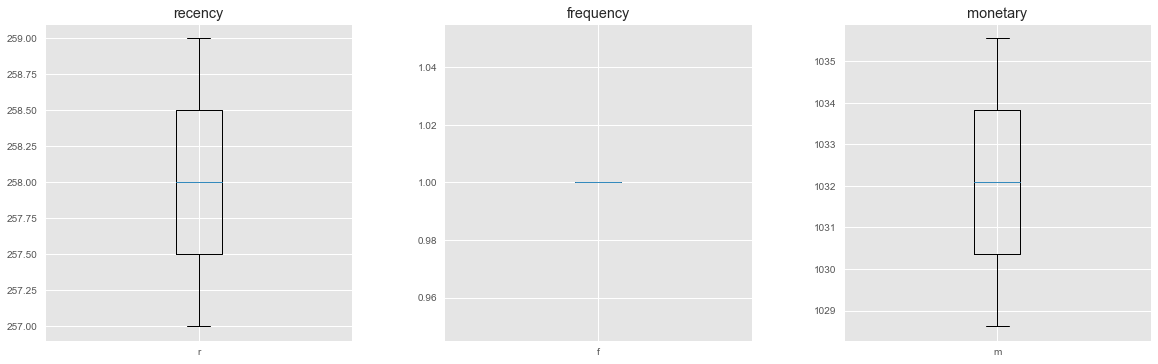


Nombre de résultats: 2

                      customer_unique_id  recency  frequency  monetary
44100  761fb886f61539123668aaa3b750033b    257.0        1.0   1035.55
16767  2cda0e652e045b89ae13987cd09a1327    259.0        1.0   1028.62


In [209]:
if perso_ == 1:
    cl_cent_perso(kmea5.cluster_centers_,'KM_group_5',5,3)
# Pour 1 résultat: kmea5.cluster_centers_,'KM_group_5',1,3,0.03

### Persona 4

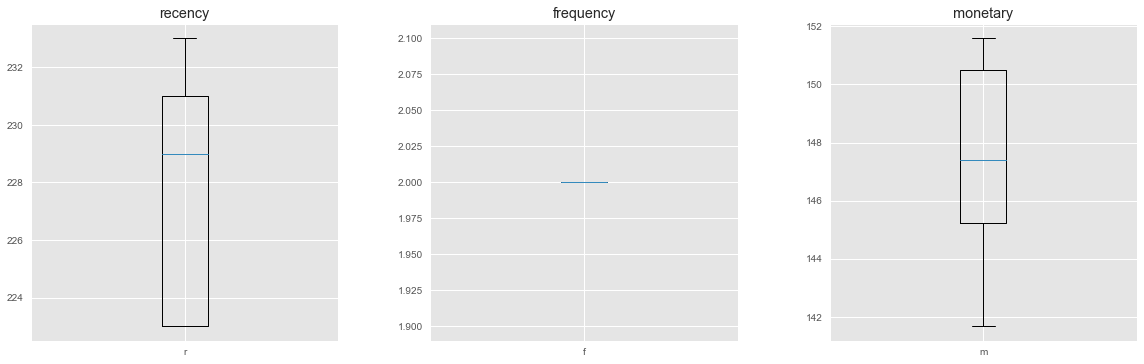


Nombre de résultats: 5

                      customer_unique_id  recency  frequency  monetary
55378  94ab38525c16d9d5ce977b3fe3405ab8    223.0        2.0   150.510
21885  3a73ce6fc3b392e1ca609b5548418c36    223.0        2.0   151.585
59500  9f6a13c93d886acbefe16ad39bbfb85c    229.0        2.0   141.670
54010  910ef561b28c67973b74ce21e0d252ea    231.0        2.0   147.405
42446  719b758d12e3c1f243c66bf47b488be1    233.0        2.0   145.215


In [210]:
if perso_ == 1:
    cl_cent_perso(kmea5.cluster_centers_,'KM_group_5',5,4)

On récupère les dataframes relatifs à chaque persona pour réaliser des statistiques.

In [211]:
df_perso_0 = pd.read_excel('df_perso_0.xlsx')
df_perso_1 = pd.read_excel('df_perso_1.xlsx')
df_perso_2 = pd.read_excel('df_perso_2.xlsx')
df_perso_3 = pd.read_excel('df_perso_3.xlsx')
df_perso_4 = pd.read_excel('df_perso_4.xlsx')

df_perso = pd.concat([df_perso_0, df_perso_1, df_perso_2, df_perso_3, df_perso_4])

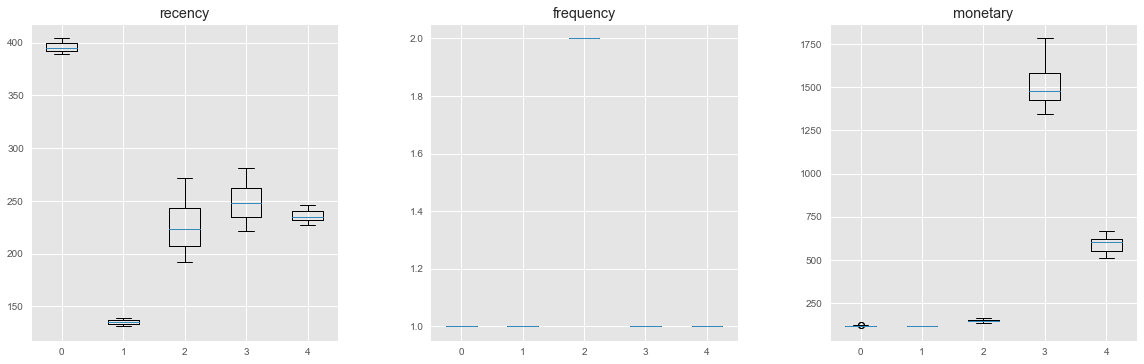

In [212]:
data_boxplot_2(df_perso,'KM_group_5','recency','frequency','monetary',1)

In [213]:
time_calc('Personas - k-means (5 cls)','85.27')
t = time.time()

Durée de l'opération 'Personas - k-means (5 cls)': 17.03 s
Durée totale de traitement: 00 h 02 m 06 s


#### Statistiques - RFM vs K-Means

##### Choix des segments

In [214]:
segments_rfm_choice = 0

if segments_rfm_choice == 0: # RFM statistique
    segment = 'segment_x'
    segment_name = 'segment_name_x'
    df_segment_group = df_segment_x_group
    
elif segments_rfm_choice == 1: # RFM stratégique
    segment = 'segment_y'
    segment_name = 'segment_name_y'
    df_segment_group = df_segment_y_group

In [215]:
segment_l = df_rfm[segment].values

In [216]:
labels_colors(segment_l)

array(['#1976D2', '#00CC00', '#00CC00', ..., '#00CC00', '#1976D2',
       '#00FFFF'], dtype=object)

On produit des statistiques par segment.

In [217]:
df_segment_stats = df_rfm[['recency','frequency','monetary',segment]].groupby(segment).agg({'recency': 'mean',
                                                                                                'frequency': 'mean',
                                                                                                'monetary': ['mean','count']})

df_segment_colors = df_segment_group.merge(df_colors.set_index('c_index'), left_index = True, right_index = True, how = 'inner')

df_segment_c_stats = df_segment_colors.merge(df_segment_stats, left_index = True, right_index = True, how = 'inner')
df_segment_c_stats = df_segment_c_stats.round(2)

df_segment_c_stats_n = df_segment_c_stats.reset_index()

df_segment_c_stats_n['index'] = df_segment_c_stats_n['index'].astype('str')
df_segment_c_stats_n['cust_count'] = df_segment_c_stats_n[('monetary', 'count')].astype('str')
df_segment_c_stats_n[segment_name] = '[' + df_segment_c_stats_n['index'] + '] ' + df_segment_c_stats_n[segment_name] + ' (' + df_segment_c_stats_n['cust_count'] + ')'
df_segment_c_stats_n.rename(columns={'index': 'segment'}, inplace = True)

df_segment_c_stats_n['segment'] = np.int64(df_segment_c_stats_n['segment'])
del df_segment_c_stats_n['cust_count']
#df_segment_c_stats_n.set_index('segment', inplace = True)

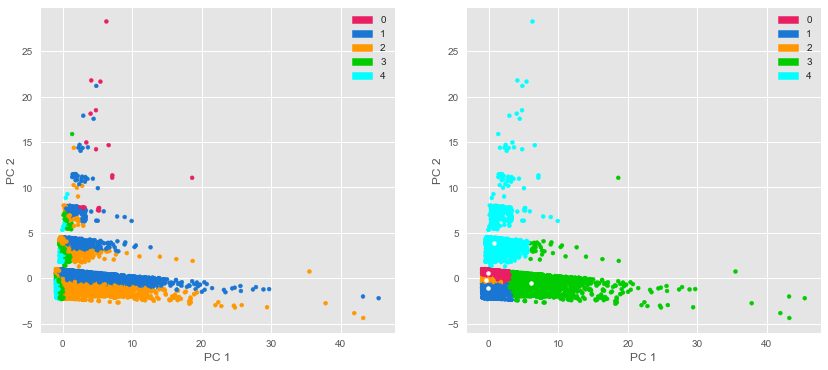

In [218]:
data_c_plot(segment_l,kmea5_l,0,kmea5)

In [219]:
df_segment_c_stats_n

,segment,segment_name_x,c_values,c_names,"(recency, mean)","(frequency, mean)","(monetary, mean)","(monetary, count)"
0,0,[0] Très récent - Récurrent - Grand CA (21),#E91E63,fuchsia,66.57,4.38,314.50,21
1,1,[1] Très récent - Occasionnel - Grand CA (23183),#1976D2,bleu,109.33,1.04,280.99,23183
2,2,[2] Récent - Occasionnel - Moyen CA (34199),#FF9800,orange,218.78,1.03,177.12,34199
3,3,[3] Ancien - Occasionnel - Moyen CA (26455),#00CC00,vert,311.70,1.03,83.04,26455
4,4,[4] Ancien - Occasionnel - Petit CA (11560),#00FFFF,bleu (aqua),429.99,1.02,50.01,11560


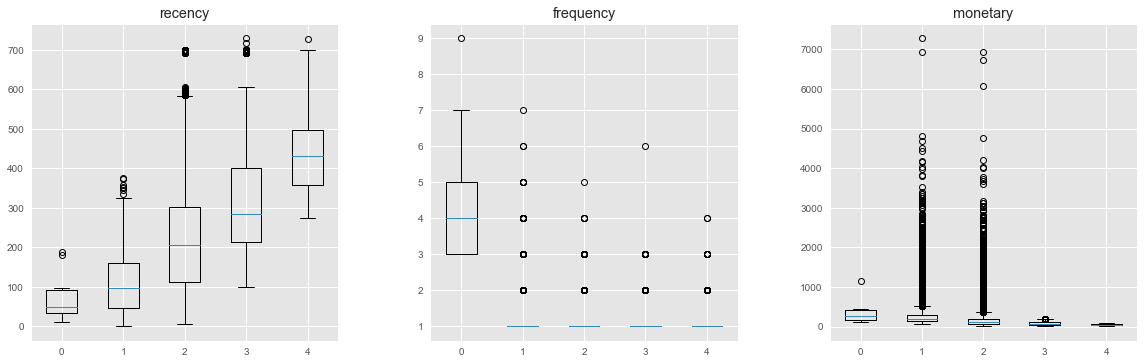

In [220]:
data_boxplot(df_rfm,segment,1)

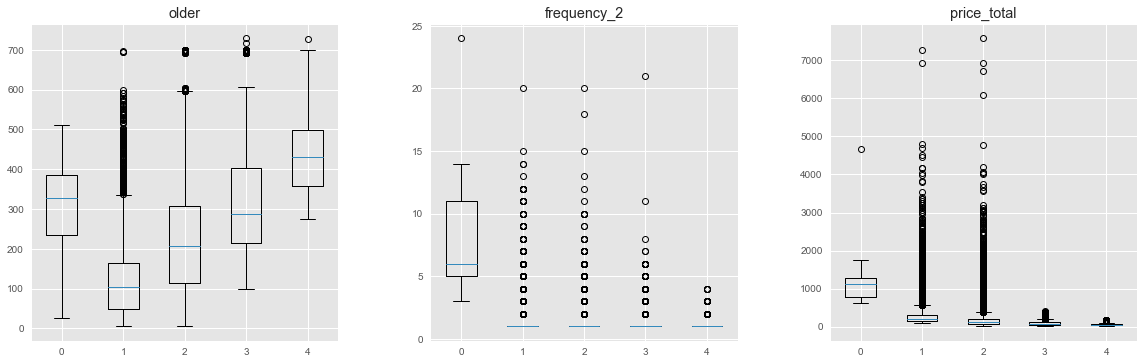

In [221]:
data_boxplot_2(df_rfm,segment,'older','frequency_2','price_total',1)

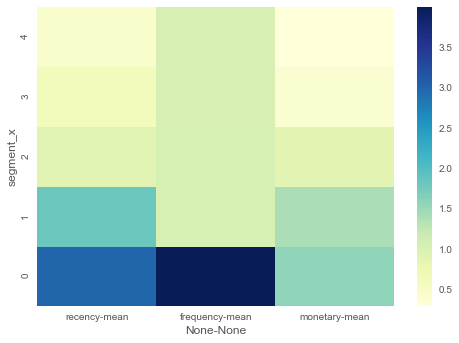

In [222]:
df_segment_stats_std = df_rfm[['recency','frequency','monetary',segment]].groupby(segment).agg({'recency': 'mean',
                                                                                                'frequency': 'mean',
                                                                                                'monetary': ['mean','count']})
data = df_segment_stats_std[[('recency', 'mean'),('frequency', 'mean'),('monetary', 'mean')]]

# Les valeurs de 'recency' ont un meilleur score quand elles sont petites et inversement
# On inverse les valeurs de 'recency' afin d'être homogène avec les autres variables
data[('recency', 'mean')] = 1 / (data[('recency', 'mean')] / 200)
data[('frequency', 'mean')] = data[('frequency', 'mean')]
data[('monetary', 'mean')] = data[('monetary', 'mean')] / 200

ax = sns.heatmap(data, cmap="YlGnBu", robust = True)
ax.invert_yaxis()

In [223]:
time_calc('Statistiques - RFM vs k-means')
t = time.time()

Durée de l'opération 'Statistiques - RFM vs k-means': 6.38 s
Durée totale de traitement: 00 h 02 m 13 s


### K-Modes

Nous nous intéressons ici aux **données catégorielles**. Ce type de données ne peut être traité avec K-Means qui regroupe des données **numériques** en fonction de la distance euclidienne.

L'alogrithme **K-Modes** permet de regrouper des variables catégorielles. Il définit des clusters en fonction du nombre de catégories correspondantes entre les points de données.

L'algorithme **K-Prototypes** combine **K-modes** et **K-means** et est capable de regrouper des données numériques / catégorielles mixtes.

https://pypi.org/project/kmodes/

In [224]:
from kmodes.kmodes import KModes

**K-Modes** permet de traiter ***uniquement*** les variables catégorielles.

On peut l'exploiter avec 2 jeux de données:

+ Catégories de produits (***df_cat***)
+ Types de paiement (***df_pay_type***)

In [225]:
df_cat.iloc[:2,0:6]

,x0_agro_industry_and_commerce,x0_air_conditioning,x0_art,x0_arts_and_craftmanship,x0_audio,x0_auto
customer_unique_id,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,0.0,0.0,0.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,0.0,0.0,0.0,0.0


In [226]:
df_pay_type.head(2)

,x0_boleto,x0_credit_card,x0_debit_card,x0_not_defined,x0_voucher
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,1.0,0.0,0.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,1.0,0.0,0.0,0.0


#### Nombre optimal de clusters K-Modes

In [227]:
#help(KModes)

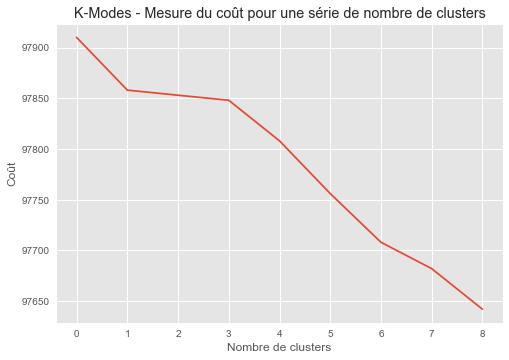

In [228]:
if kmod_cost_ == 1:
    
    cost = []
    
    for num_clusters in list(range(1,10)):
        
        kmod = KModes(n_clusters=num_clusters,
                      init='Cao',
                      n_init=1,
                      verbose=0,
                      random_state=random_state_) 
        
        kmod.fit_predict(df_cat)        
        cost.append(kmod.cost_)
        
    with open('kmod_cost', 'wb') as fp:
        pickle.dump(cost, fp)
        
elif kmod_cost_ == 0:
    
    with open ('kmod_cost', 'rb') as fp:
        cost = pickle.load(fp)
    
plt.plot(cost)
plt.xlabel('Nombre de clusters')
plt.ylabel('Coût')
plt.title('K-Modes - Mesure du coût pour une série de nombre de clusters')
plt.show()

In [229]:
time_calc('Nombre de clusters - k-modes','651.38')
t = time.time()

Durée de l'opération 'Nombre de clusters - k-modes': 0.41 s
Durée totale de traitement: 00 h 02 m 13 s


#### Clustering K-Modes

In [230]:
if kmod_ == 1:
    
    kmod = KModes(n_clusters=5,
                  init='Cao',
                  n_init=1,
                  verbose=0,
                  random_state=random_state_)
    
    kmod.fit_predict(df_cat)   
    dump(kmod, 'kmod.joblib') # On sauvegarde le modèle
    
elif kmod_ == 0:
    
    kmod = load('kmod.joblib') # On recharge le modèle

print('')
pprint(kmod.get_params())


{'cat_dissim': <function matching_dissim at 0x000002CF4A72CF78>,
 'init': 'Cao',
 'max_iter': 100,
 'n_clusters': 5,
 'n_init': 1,
 'n_jobs': 1,
 'random_state': 42,
 'verbose': 0}


In [231]:
# Etiquettes k-modes
kmod_l = kmod.labels_

# On ajoute les étiquettes k-modes à df_rfm
df_kmod = pd.DataFrame(kmod.labels_)
df_rfm = df_rfm.assign(KMO_group = df_kmod[0].values)

print('Groupes k-modes:',df_rfm.sort_values('KMO_group')['KMO_group'].unique().tolist())

Groupes k-modes: [0, 1, 2, 3, 4]


In [232]:
df_rfm[df_rfm['KMO_group'] == 0].head(2)

,customer_unique_id,start,end,older,recency,duration,frequency,frequency_2,prod_nb_avg,nb_prod_diff,...,RFM,rfm_score,segment_x,segment_y,KM_group_3,KM_group_4,KM_group_5,KM_group_6,KM_group_7,KMO_group
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,2018-05-10,116.0,116.0,1.0,1.0,1.0,1.0,1,...,414,9,1,1,2,2,0,0,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,2018-05-07,119.0,119.0,1.0,1.0,1.0,1.0,1,...,411,6,3,6,2,2,0,0,0,0


In [233]:
time_calc('Clustering - k-modes (5 cls)','71.37')
t = time.time()

Durée de l'opération 'Clustering - k-modes (5 cls)': 0.14 s
Durée totale de traitement: 00 h 02 m 13 s


#### Statistiques K-Modes

In [234]:
k_stats('KMO_group',kmod)

,code couleur,couleur,recency_mean,frequency_mean,monetary_mean,Nombre de clients
KMO_group,,,,,,
0,#E91E63,fuchsia,243.52,1.03,160.89,95352
1,#1976D2,bleu,208.15,1.85,175.52,26
2,#FF9800,orange,156.00,5.00,120.78,1
3,#00CC00,vert,153.00,5.00,90.23,1
4,#00FFFF,bleu (aqua),220.61,1.97,194.79,38


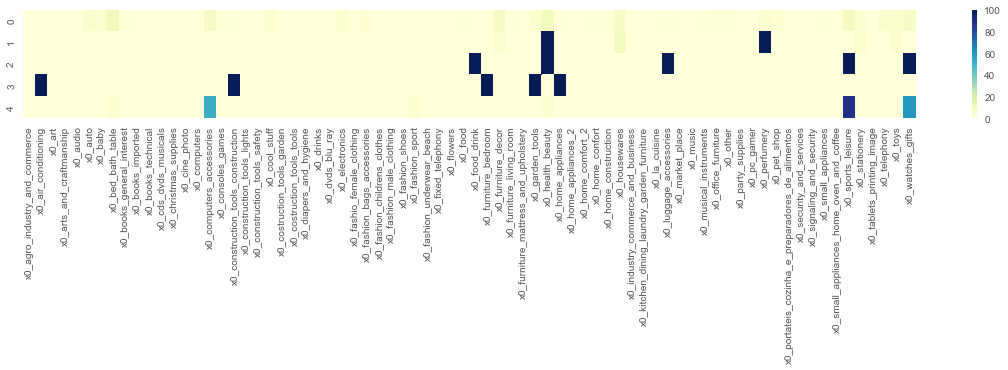

In [235]:
group_cat_heatmap('KMO_group',kmod)

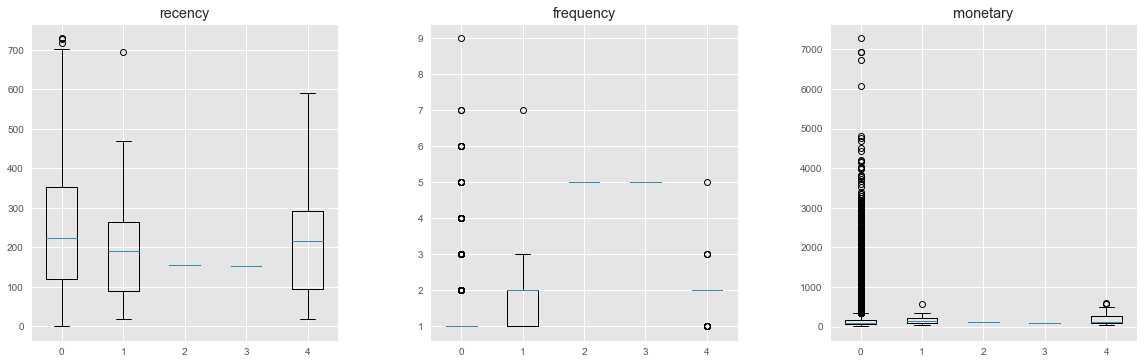

In [236]:
data_boxplot(df_rfm,'KMO_group',1)

In [237]:
time_calc('Statistiques - k-modes (5 cls)')
t = time.time()

Durée de l'opération 'Statistiques - k-modes (5 cls)': 5.38 s
Durée totale de traitement: 00 h 02 m 19 s


#### Groupes explicites K-Modes

In [238]:
# Clusters contient les groupes (lignes) et les valeurs de la variable catégorielle (colonnes)
# On nomme 'catégories' les valeurs de la variable catégorielle qu'il s'agisse de la variable
# 'Catégories de produit' ou de la variable 'Types de paiement' ou toute autre variable traitée
clusters = kmod.cluster_centroids_
pd.DataFrame(clusters)

,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [239]:
# Un mode correspond à une ligne
# Les catégories (colonnes) dont la valeur est 1 appartiennent au groupe décrit par le mode
# Exemple: ligne 3 (groupe 4)
pd.DataFrame(clusters).iloc[3:4,0:80]

,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [240]:
# Pour chaque mode (groupe)
for i in range(clusters.shape[0]):
    
    # On fait la somme des valeurs (de la ligne)
    # Si la somme est égale 0, le groupe ne contient aucune catégorie
    if sum(clusters[i,:]) == 0:
        print("\ncluster " + str(i) + ": ")
        print("no_cat")
    
    # Si la somme est non nulle, on identifie les noms de catégories dans df_cat
    # pour les catégories incluses dans le groupe
    else:
        print("\ncluster " + str(i) + ": ")
        for j in pd.DataFrame(df_cat).columns[np.nonzero(clusters[i,:])]:
            print(j)


cluster 0: 
no_cat

cluster 1: 
x0_health_beauty
x0_perfumery

cluster 2: 
x0_food_drink
x0_health_beauty
x0_luggage_accessories
x0_sports_leisure
x0_watches_gifts

cluster 3: 
x0_air_conditioning
x0_construction_tools_construction
x0_furniture_bedroom
x0_garden_tools
x0_home_appliances

cluster 4: 
x0_computers_accessories
x0_sports_leisure
x0_watches_gifts


In [241]:
time_calc('Groupes explicites - k-modes (5 cls)')
t = time.time()

Durée de l'opération 'Groupes explicites - k-modes (5 cls)': 0.12 s
Durée totale de traitement: 00 h 02 m 19 s


### K-Prototypes

In [242]:
#help(KPrototypes)

In [243]:
from kmodes.kprototypes import KPrototypes

#### Nombre optimal de clusters K-Prototypes

Choix des variables catégorielles:

+ X_c_1: Catégories de produit
+ X_c_2: Types de paiement

In [244]:
X_c = X_c_1

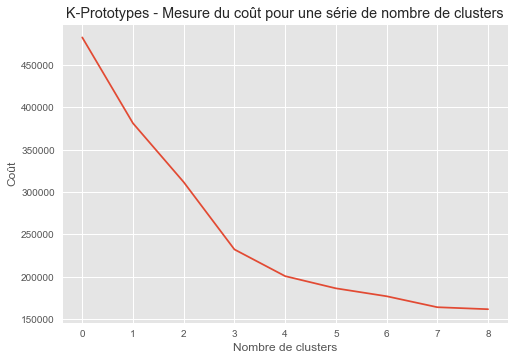

In [245]:
if kpro_cost_ == 1:
    
    cost = []
    
    for num_clusters in list(range(1,10)):
        
        kpro = KPrototypes(n_clusters=num_clusters,
                           init = 'Cao', #'Huang'                           
                           n_init=1,
                           verbose=0,
                           random_state=random_state_)
        
        kpro.fit_predict(X_c, categorical=[3,76])
        cost.append(kpro.cost_)
        
    with open('kpro_cost', 'wb') as fp:
        pickle.dump(cost, fp)
        
elif kpro_cost_ == 0:
    
    with open ('kpro_cost', 'rb') as fp:
        cost = pickle.load(fp)
    
plt.plot(cost)
plt.xlabel('Nombre de clusters')
plt.ylabel('Coût')
plt.title('K-Prototypes - Mesure du coût pour une série de nombre de clusters')
plt.show()

In [246]:
time_calc('Nombre de clusters - k-prototypes','1970.06')
t = time.time()

Durée de l'opération 'Nombre de clusters - k-prototypes': 0.43 s
Durée totale de traitement: 00 h 02 m 19 s


#### Clustering K-Prototypes

In [247]:
if kpro_ == 1:
    
    kpro = KPrototypes(n_clusters=5,
                       init='Cao',
                       n_init=1,
                       verbose=0,
                       random_state=random_state_)    
    
    kpro.fit(X_c, categorical=[3,76]) # 3, 76 avec df_cat      
    dump(kpro, 'kpro.joblib') # On sauvegarde le modèle
    
if kpro_ == 0: # On recharge le modèle      
    
    kpro = load('kpro.joblib')

# Statistiques
print('Dernier coût =',kpro.cost_)
print('Nombre d\'itérations =',kpro.n_iter_)

print('Paramètres')
print('')
pprint(kpro.get_params())

Dernier coût = 200687.81920521837
Nombre d'itérations = 16
Paramètres

{'cat_dissim': <function matching_dissim at 0x000002CF4A72CF78>,
 'gamma': 0.1277866255022374,
 'init': 'Cao',
 'max_iter': 100,
 'n_clusters': 5,
 'n_init': 1,
 'n_jobs': 1,
 'num_dissim': <function euclidean_dissim at 0x000002CF4A748948>,
 'random_state': 42,
 'verbose': 1}


Text(0, 0.5, 'Clusters')

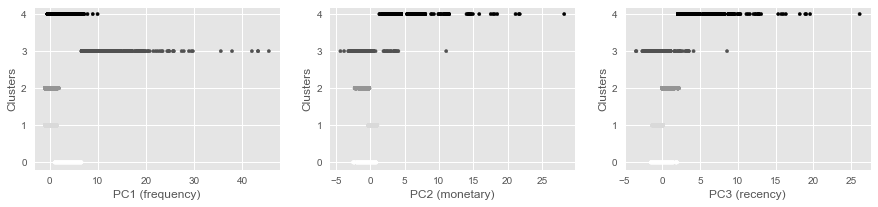

In [248]:
fig = plt.figure(figsize=(15, 3))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.scatter(X_c[:,0], kpro.labels_, c=kpro.labels_, s=10)
ax1.set_xlabel('PC1 (frequency)')
ax1.set_ylabel('Clusters')

ax2.scatter(X_c[:,1], kpro.labels_, c=kpro.labels_, s=10)
ax2.set_xlabel('PC2 (monetary)')
ax2.set_ylabel('Clusters')

ax3.scatter(X_c[:,2], kpro.labels_, c=kpro.labels_, s=10)
ax3.set_xlabel('PC3 (recency)')
ax3.set_ylabel('Clusters')  

In [249]:
# Etiquettes k-prototypes
kpro_l = kpro.labels_

# On ajoute les étiquettes k-prototypes à df_rfm
df_kpro = pd.DataFrame(kpro.labels_)
df_rfm = df_rfm.assign(KPR_group = df_kpro[0].values)

print('Groupes k-prototypes:',df_rfm.sort_values('KPR_group')['KPR_group'].unique().tolist())

Groupes k-prototypes: [0, 1, 2, 3, 4]


In [250]:
time_calc('Clustering - k-protoypes (5 cls)','214.95')
t = time.time()

Durée de l'opération 'Clustering - k-protoypes (5 cls)': 5.47 s
Durée totale de traitement: 00 h 02 m 25 s


#### Statistiques K-Prototypes

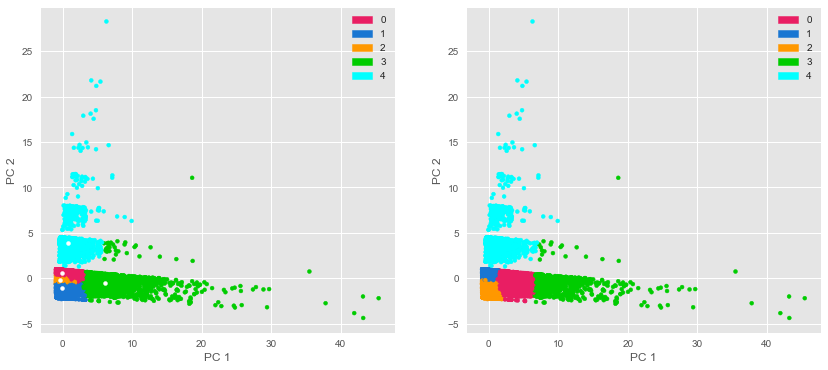

In [251]:
data_c_plot(kmea5_l,kpro_l,kmea5)

In [252]:
k_stats('KPR_group',kpro)

,code couleur,couleur,recency_mean,frequency_mean,monetary_mean,Nombre de clients
KPR_group,,,,,,
0,#E91E63,fuchsia,236.89,1.00,587.96,5846
1,#1976D2,bleu,133.87,1.00,117.38,49581
2,#FF9800,orange,395.51,1.00,118.07,36311
3,#00CC00,vert,250.38,1.03,1785.62,787
4,#00FFFF,bleu (aqua),226.05,2.11,139.44,2893


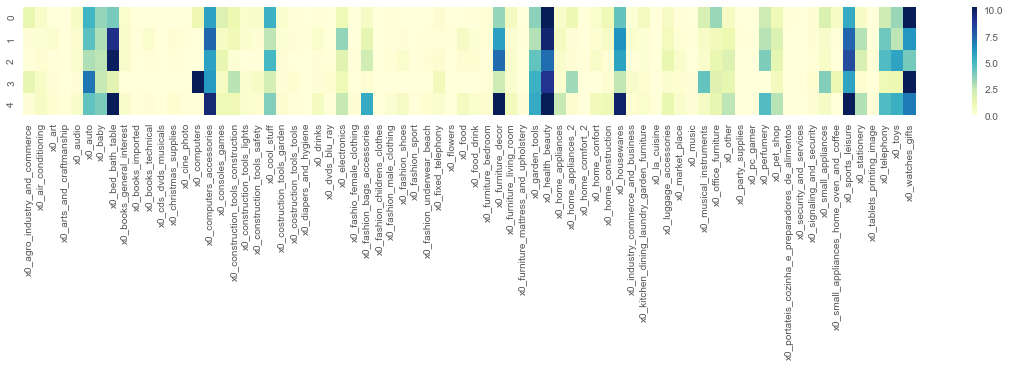

In [253]:
group_cat_heatmap('KPR_group',kpro)

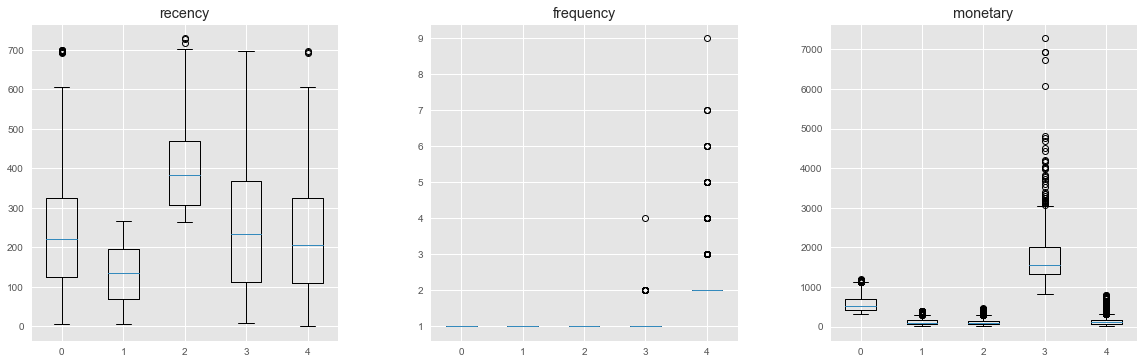

In [254]:
data_boxplot(df_rfm,'KPR_group',1)

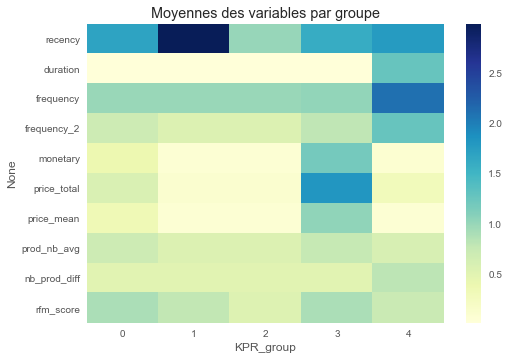

In [255]:
var_mean_heatmap('KPR_group')

In [256]:
time_calc('Statistiques - k-protoypes (5 cls)')
t = time.time()

Durée de l'opération 'Statistiques - k-protoypes (5 cls)': 10.3 s
Durée totale de traitement: 00 h 02 m 35 s


#### Groupes explicites K-Prototypes

In [257]:
df_KPR_group_c_stats = pd.read_excel('KPR_group_c_stats.xlsx')
df_KPR_group_c_stats

,KPR_group,code couleur,couleur,recency_mean,frequency_mean,monetary_mean,Nombre de clients
0,0,#E91E63,fuchsia,236.89,1.00,587.96,5846
1,1,#1976D2,bleu,133.87,1.00,117.38,49581
2,2,#FF9800,orange,395.51,1.00,118.07,36311
3,3,#00CC00,vert,250.38,1.03,1785.62,787
4,4,#00FFFF,bleu (aqua),226.05,2.11,139.44,2893


On explicite les groupes.

In [258]:
list_KPR_group_n = ['KPR Groupe 0',
                    'KPR Groupe 1',
                    'KPR Groupe 2',
                    'KPR Groupe 3',
                    'KPR Groupe 4']

In [259]:
KPR_group_ = df_KPR_group_c_stats.iloc[:,:1].columns.tolist()
df_KPR_group_c_stats_n = df_KPR_group_c_stats
df_KPR_group_c_stats_n['KPR_group_name'] = list_KPR_group_n
df_KPR_group_c_stats_n['KPR_group_str'] = df_KPR_group_c_stats_n[KPR_group_].astype('str')
df_KPR_group_c_stats_n['Nombre de clients_str'] = df_KPR_group_c_stats_n['Nombre de clients'].astype('str')
df_KPR_group_c_stats_n['KPR_group_name'] = '[' + df_KPR_group_c_stats_n['KPR_group_str'] + '] ' + df_KPR_group_c_stats_n['KPR_group_name'] + ' (' + df_KPR_group_c_stats_n['Nombre de clients_str'] + ')'
del df_KPR_group_c_stats_n['KPR_group_str']
del df_KPR_group_c_stats_n['Nombre de clients_str']
df_KPR_group_c_stats_n

,KPR_group,code couleur,couleur,recency_mean,frequency_mean,monetary_mean,Nombre de clients,KPR_group_name
0,0,#E91E63,fuchsia,236.89,1.00,587.96,5846,[0] KPR Groupe 0 (5846)
1,1,#1976D2,bleu,133.87,1.00,117.38,49581,[1] KPR Groupe 1 (49581)
2,2,#FF9800,orange,395.51,1.00,118.07,36311,[2] KPR Groupe 2 (36311)
3,3,#00CC00,vert,250.38,1.03,1785.62,787,[3] KPR Groupe 3 (787)
4,4,#00FFFF,bleu (aqua),226.05,2.11,139.44,2893,[4] KPR Groupe 4 (2893)


In [260]:
time_calc('Groupes explicites - k-protoypes (5 cls)')
t = time.time()

Durée de l'opération 'Groupes explicites - k-protoypes (5 cls)': 0.13 s
Durée totale de traitement: 00 h 02 m 35 s


### DBSCAN

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

In [261]:
from matplotlib import collections
from sklearn.cluster import DBSCAN

#### Clustering DBSCAN

In [262]:
#help(DBSCAN)

In [263]:
if dbs_ == 1:       
    dbs = DBSCAN(eps=0.4, min_samples=25).fit(X)  # 0.3 / 20
    dump(dbs, 'dbs.joblib') # On sauvegarde le modèle
    
if dbs_ == 0:
    dbs = load('dbs.joblib') # On recharge le modèle

pprint(dbs.get_params())

{'algorithm': 'auto',
 'eps': 0.4,
 'leaf_size': 30,
 'metric': 'euclidean',
 'metric_params': None,
 'min_samples': 25,
 'n_jobs': None,
 'p': None}


In [264]:
# Etiquettes DBSCAN
dbs_l = dbs.labels_

# On ajoute les étiquettes DBSCAN à df_rfm
df_dbs = pd.DataFrame(dbs_l)
df_rfm = df_rfm.assign(DBS_group = df_dbs[0].values)

print('Groupes DBSCAN:',df_rfm.sort_values('DBS_group')['DBS_group'].unique().tolist())

Groupes DBSCAN: [-1, 0, 1, 2, 3, 4]


In [265]:
time_calc('Clustering - DBSCAN','25.94')
t = time.time()

Durée de l'opération 'Clustering - DBSCAN': 0.12 s
Durée totale de traitement: 00 h 02 m 35 s


#### Statistiques DBSCAN

In [266]:
df_DBS_group_stats = df_rfm[['recency','frequency','monetary',
                             'DBS_group']].groupby('DBS_group').agg({'recency': 'mean',
                                                                     'frequency': 'mean',
                                                                     'monetary': ['mean','count']})

df_DBS_group_colors = df_dbs.set_index(0).merge(df_colors.set_index('c_index'), 
                        left_index = True, right_index = True, 
                        how = 'inner').reset_index().rename(columns={'index': 'DBS_group'}).groupby('DBS_group').first()

df_DBS_group_c_stats = df_DBS_group_colors.merge(df_DBS_group_stats, left_index = True, right_index = True, how = 'inner')
df_DBS_group_c_stats = df_DBS_group_c_stats.round(2)

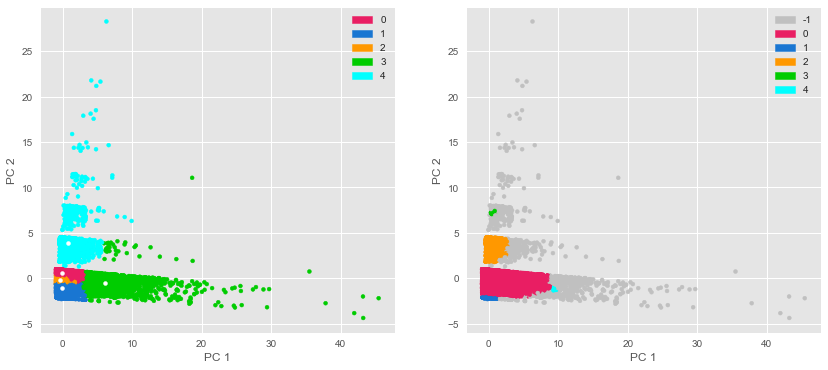

In [267]:
data_c_plot(kmea5_l,dbs_l,kmea5)

In [268]:
k_stats('DBS_group',dbs)

,code couleur,couleur,recency_mean,frequency_mean,monetary_mean,Nombre de clients
DBS_group,,,,,,
-1,#C0C0C0,gris,270.87,1.79,1264.75,851
0,#E91E63,fuchsia,242.44,1.00,151.50,91746
1,#1976D2,bleu,696.80,1.00,125.38,263
2,#FF9800,orange,225.58,2.00,119.06,2500
3,#00CC00,vert,166.35,3.00,67.78,31
4,#00FFFF,bleu (aqua),336.93,1.00,1640.56,27


,Nombre de clients
DBS_group,
-1,851
0,91746
1,263
2,2500
3,31
4,27


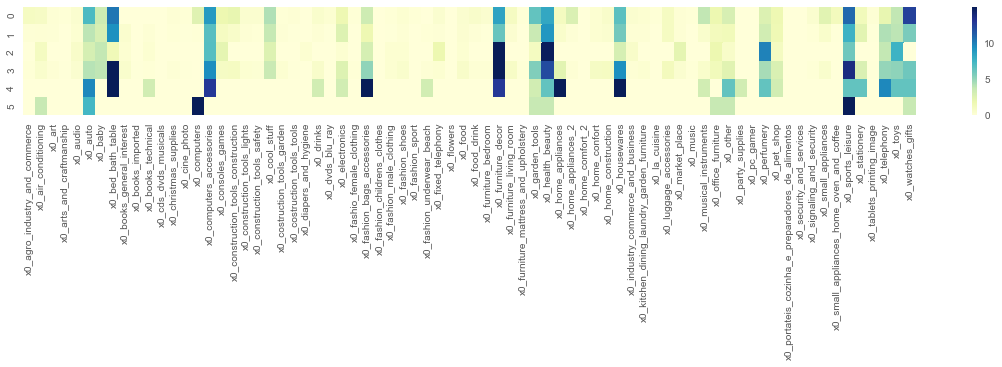

In [269]:
group_cat_heatmap('DBS_group',dbs,1)

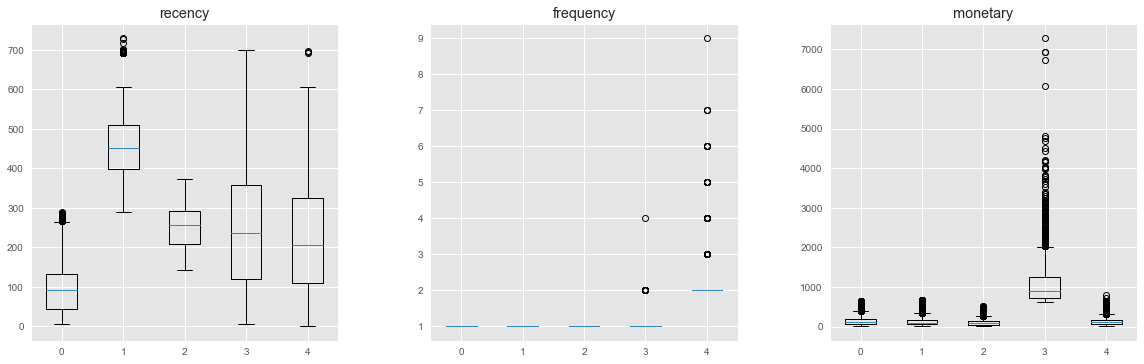

In [270]:
data_boxplot(df_rfm,'KM_group_5',1)

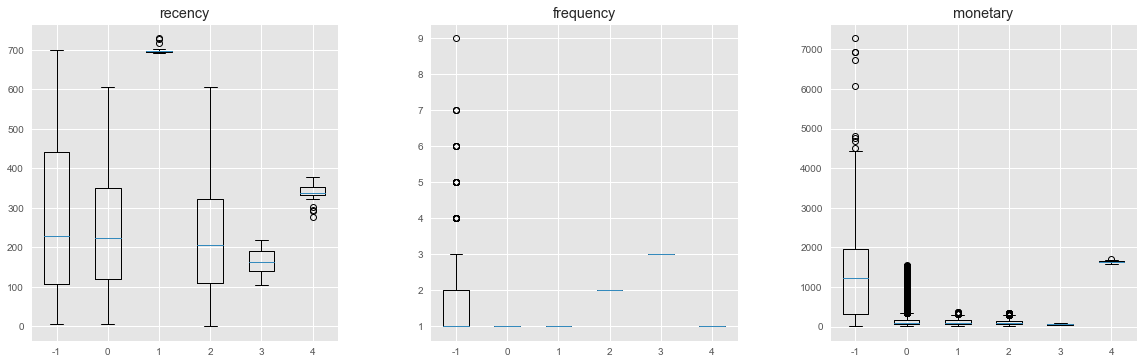

In [271]:
data_boxplot(df_rfm,'DBS_group',1)

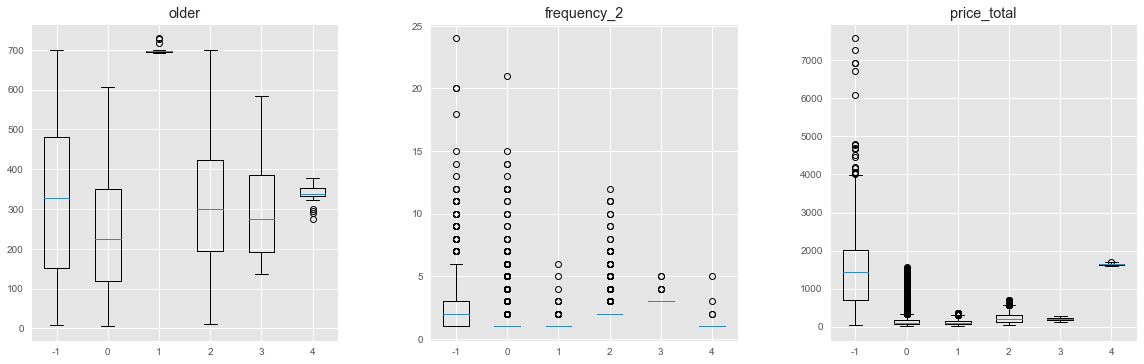

In [272]:
data_boxplot_2(df_rfm,'DBS_group','older','frequency_2','price_total',1)

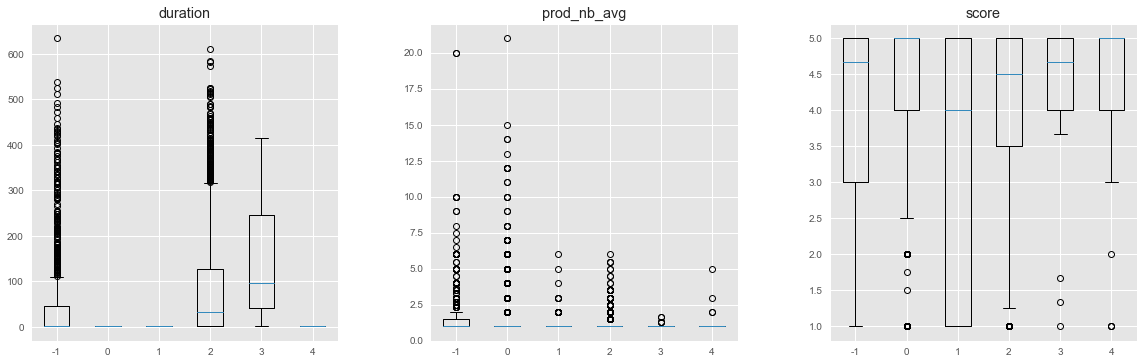

In [273]:
data_boxplot_2(df_rfm,'DBS_group','duration','prod_nb_avg','score',1)

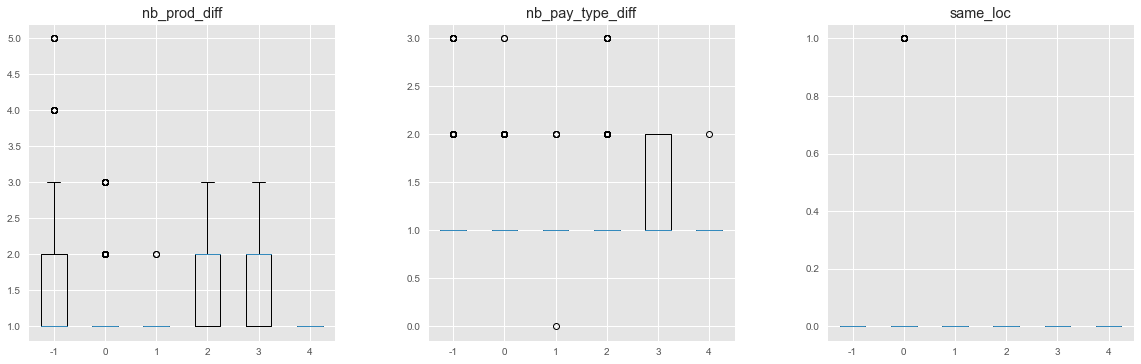

In [274]:
data_boxplot_2(df_rfm,'DBS_group','nb_prod_diff','nb_pay_type_diff','same_loc',1)

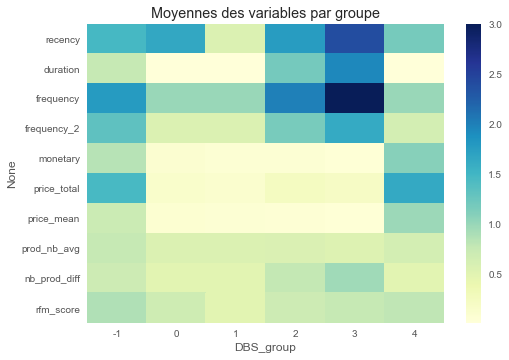

In [275]:
var_mean_heatmap('DBS_group')

In [276]:
time_calc('Statistiques - DBSCAN')
t = time.time()

Durée de l'opération 'Statistiques - DBSCAN': 13.36 s
Durée totale de traitement: 00 h 02 m 49 s


#### Groupes explicites DBSCAN

In [277]:
df_DBS_group_c_stats = pd.read_excel('DBS_group_c_stats.xlsx')
df_DBS_group_c_stats

,DBS_group,code couleur,couleur,recency_mean,frequency_mean,monetary_mean,Nombre de clients
0,-1,#C0C0C0,gris,270.87,1.79,1264.75,851
1,0,#E91E63,fuchsia,242.44,1.00,151.50,91746
2,1,#1976D2,bleu,696.80,1.00,125.38,263
3,2,#FF9800,orange,225.58,2.00,119.06,2500
4,3,#00CC00,vert,166.35,3.00,67.78,31
5,4,#00FFFF,bleu (aqua),336.93,1.00,1640.56,27


On explicite les groupes.

In [278]:
list_DBS_group_n = ['Récent - Occasionnel - Grand CA',
                    'Récent - Ponctuel - Moyen CA',
                    'Inactif - Ponctuel - Moyen CA',
                    'Récent - Récurrent - Moyen CA',
                    'Très récent - Récurrent - Petit CA',
                    'Ancien - Ponctuel - Très grand CA']

In [279]:
DBS_group_ = df_DBS_group_c_stats.iloc[:,:1].columns.tolist()

df_DBS_group_c_stats_n = df_DBS_group_c_stats
df_DBS_group_c_stats_n['DBS_group_name'] = list_DBS_group_n
df_DBS_group_c_stats_n['DBS_group_str'] = df_DBS_group_c_stats_n[DBS_group_].astype('str')
df_DBS_group_c_stats_n['Nombre de clients_str'] = df_DBS_group_c_stats_n['Nombre de clients'].astype('str')
df_DBS_group_c_stats_n['DBS_group_name'] = '[' + df_DBS_group_c_stats_n['DBS_group_str'] + '] ' + df_DBS_group_c_stats_n['DBS_group_name'] + ' (' + df_DBS_group_c_stats_n['Nombre de clients_str'] + ')'
del df_DBS_group_c_stats_n['DBS_group_str']
del df_DBS_group_c_stats_n['Nombre de clients_str']
df_DBS_group_c_stats_n

,DBS_group,code couleur,couleur,recency_mean,frequency_mean,monetary_mean,Nombre de clients,DBS_group_name
0,-1,#C0C0C0,gris,270.87,1.79,1264.75,851,[-1] Récent - Occasionnel - Grand CA (851)
1,0,#E91E63,fuchsia,242.44,1.00,151.50,91746,[0] Récent - Ponctuel - Moyen CA (91746)
2,1,#1976D2,bleu,696.80,1.00,125.38,263,[1] Inactif - Ponctuel - Moyen CA (263)
3,2,#FF9800,orange,225.58,2.00,119.06,2500,[2] Récent - Récurrent - Moyen CA (2500)
4,3,#00CC00,vert,166.35,3.00,67.78,31,[3] Très récent - Récurrent - Petit CA (31)
5,4,#00FFFF,bleu (aqua),336.93,1.00,1640.56,27,[4] Ancien - Ponctuel - Très grand CA (27)


In [280]:
time_calc('Groupes explicites - DBSCAN')
t = time.time()

Durée de l'opération 'Groupes explicites - DBSCAN': 0.1 s
Durée totale de traitement: 00 h 02 m 49 s


In [281]:
df_rfm_copy = df_rfm.copy()

### Partionnement final

In [282]:
df_rfm = df_rfm_copy.copy()

In [283]:
df_rfm.head(1)

,customer_unique_id,start,end,older,recency,duration,frequency,frequency_2,prod_nb_avg,nb_prod_diff,...,segment_x,segment_y,KM_group_3,KM_group_4,KM_group_5,KM_group_6,KM_group_7,KMO_group,KPR_group,DBS_group
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,2018-05-10,116.0,116.0,1.0,1.0,1.0,1.0,1,...,1,1,2,2,0,0,0,0,1,0


In [284]:
list_rfm_f = df_rfm.columns.tolist()

In [285]:
print(segment)
print(segment_name)

segment_x
segment_name_x


**1) Choix du modèle pour K-Means**

In [286]:
k_group_ = 'KM_group_5'

In [287]:
df_rfm_1 = df_rfm.merge(df_segment_c_stats_n[['segment',segment_name]],
                        left_on = segment, right_on = 'segment', how = 'left')

df_rfm_2 = df_rfm_1.merge(df_KM_group_c_stats_n[[k_group_,'KM_group_name']],
                        left_on = k_group_, right_on = k_group_, how = 'left')

df_rfm = df_rfm_2.merge(df_DBS_group_c_stats_n[['DBS_group','DBS_group_name']],
                        left_on = 'DBS_group', right_on = 'DBS_group', how = 'left')

df_rfm[segment] = df_rfm[segment].astype('str')
df_rfm[KM_group_] = df_rfm[KM_group_].astype('str')
df_rfm['DBS_group'] = df_rfm['DBS_group'].astype('str')

**2) Choix des modèles à comparer**

In [288]:
model_1 = k_group_
model_2 = segment # segment ou 'DBS_group'

group_name_1 = 'KM_group_name'
group_name_2 = segment_name # segment_name ou 'DBS_group_name'

In [289]:
df_rfm['GRP_1'] = str(df_rfm[model_1]) + str(df_rfm[model_2])
df_rfm['GRP_2'] = str(df_rfm[model_2]) + str(df_rfm[model_1])
df_rfm['GRP_1_n'] = df_rfm[group_name_1] + " / " + df_rfm[group_name_2]
df_rfm['GRP_2_n'] = df_rfm[group_name_2] + " / " + df_rfm[group_name_1]

df_rfm[model_1] = np.float64(df_rfm[model_1])
df_rfm[model_2] = np.int64(df_rfm[model_2])

In [290]:
df_rfm[['customer_unique_id',model_1,model_2,'GRP_1','GRP_1_n','GRP_2','GRP_2_n']].sort_values('GRP_1').head(2)

,customer_unique_id,KM_group_5,segment_x,GRP_1,GRP_1_n,GRP_2,GRP_2_n
0,0000366f3b9a7992bf8c76cfdf3221e2,0.0,1,0 0\n1 0\n2 1\n3 2...,[0] Ancien - Ponctuel - Petit CA (34060) / [1]...,0 1\n1 3\n2 3\n3 4...,[1] Très récent - Occasionnel - Grand CA (2318...
63616,aa6a8d63220dc100aeb3b8eb301ed741,0.0,1,0 0\n1 0\n2 1\n3 2...,[0] Ancien - Ponctuel - Petit CA (34060) / [1]...,0 1\n1 3\n2 3\n3 4...,[1] Très récent - Occasionnel - Grand CA (2318...


**3) Choix de l'ordre de concaténation (utile pour le tri)**

In [291]:
GRP = 'GRP_1'
GRP_n = 'GRP_1_n'

pd.DataFrame(df_rfm[GRP_n].value_counts()).reset_index().sort_values('index').set_index('index')

,GRP_1_n
index,
[0] Ancien - Ponctuel - Petit CA (34060) / [1] Très récent - Occasionnel - Grand CA (23183),19117
[0] Ancien - Ponctuel - Petit CA (34060) / [2] Récent - Occasionnel - Moyen CA (34199),12863
[0] Ancien - Ponctuel - Petit CA (34060) / [3] Ancien - Occasionnel - Moyen CA (26455),2080
[1] Très récent - Ponctuel - Petit CA (22282) / [2] Récent - Occasionnel - Moyen CA (34199),5583
[1] Très récent - Ponctuel - Petit CA (22282) / [3] Ancien - Occasionnel - Moyen CA (26455),8457
[1] Très récent - Ponctuel - Petit CA (22282) / [4] Ancien - Occasionnel - Petit CA (11560),8242
[2] Récent - Récurrent - Moyen CA (33447) / [1] Très récent - Occasionnel - Grand CA (23183),1719
[2] Récent - Récurrent - Moyen CA (33447) / [2] Récent - Occasionnel - Moyen CA (34199),13477
[2] Récent - Récurrent - Moyen CA (33447) / [3] Ancien - Occasionnel - Moyen CA (26455),15183


**4) Choix des groupes par modèle**

In [292]:
# Modèle 1
group_1 = 2

# Modèle 2
group_2 = 0

In [293]:
list_df_rfm_var = ['customer_unique_id',
                   #'index_x',
                   #'start',
                   #'end',
                   #'prod_nb_avg',
                   #'duration',
                   #'older',
                   'recency',
                   'frequency',
                   'frequency_2',
                   'monetary',
                   #'same_loc',
                   #'score',
                   #'R',
                   #'F',
                   #'M',
                   'RFM',
                   'rfm_score',
                    segment,
                    k_group_,
                   #'KMO_group',
                   #'KPR_group',
                   'DBS_group',
                   #'index_y',
                   #'segment_name',
                   #'KM_group_name',
                    GRP,
                    GRP_n
                  ]

In [294]:
df_rfm_groups = df_rfm[list_df_rfm_var].round()

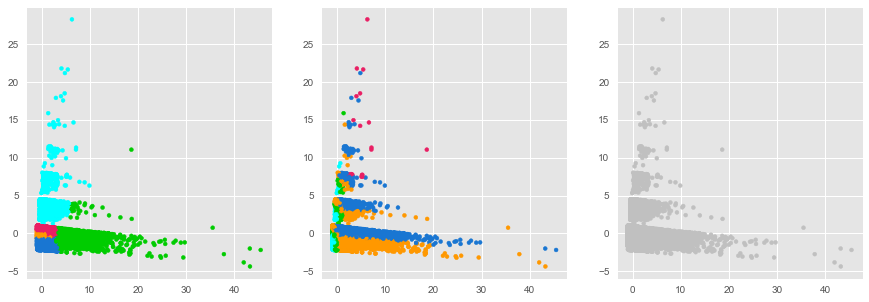

In [295]:
# Couleur par défaut
df_rfm_groups['group_c'] = group_1

# Gris pour tous les points non communs aux deux groupes
df_rfm_groups.loc[df_rfm_groups[model_1] != group_1, 'group_c'] = -1
df_rfm_groups.loc[df_rfm_groups[model_2] != group_2, 'group_c'] = -1

fig = plt.figure(figsize=(15, 5))

s_ = 15

data_l = df_rfm_groups[model_1].values

ax = fig.add_subplot(131)
ax.scatter(X[:,0], X[:,1], c= labels_colors(data_l), s = s_)

data_l = df_rfm_groups[model_2].values

ax = fig.add_subplot(132)
ax.scatter(X[:,0], X[:,1], c= labels_colors(data_l), s = s_)

data_l = df_rfm_groups['group_c'].values

ax = fig.add_subplot(133)
ax.scatter(X[:,0], X[:,1], c= labels_colors(data_l), s = s_)

plt.show()

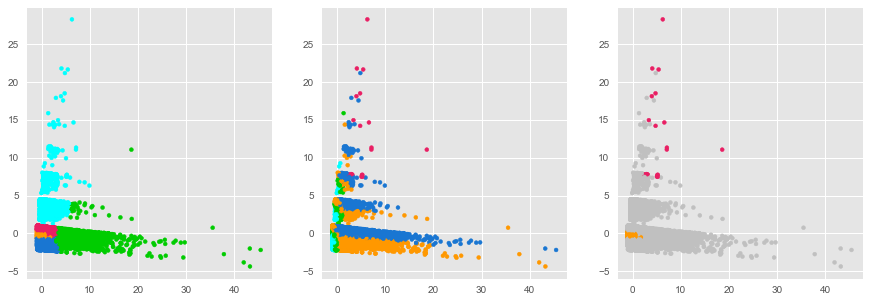

In [296]:
# Couleur par défaut
df_rfm_groups['group_c'] = -1 # Gris

# Couleur du group_1 pour les points du group_1
df_rfm_groups.loc[df_rfm_groups[model_1] == group_1, 'group_c'] = group_1
# Couleur du group_2 pour les points du group_2
df_rfm_groups.loc[df_rfm_groups[model_2] == group_2, 'group_c'] = group_2

fig = plt.figure(figsize=(15, 5))

s_ = 15

data_l = df_rfm_groups[model_1].values

ax = fig.add_subplot(131)
ax.scatter(X[:,0], X[:,1], c= labels_colors(data_l), s = s_)

data_l = df_rfm_groups[model_2].values

ax = fig.add_subplot(132)
ax.scatter(X[:,0], X[:,1], c= labels_colors(data_l), s = s_)

data_l = df_rfm_groups['group_c'].values

ax = fig.add_subplot(133)
ax.scatter(X[:,0], X[:,1], c= labels_colors(data_l), s = s_)

plt.show()

In [297]:
df_rfm_group_ = df_rfm_groups[(df_rfm_groups[model_1] == group_1) & (df_rfm_groups[model_2] == group_2)] # xor ^

df_rfm_a = df_rfm[df_rfm[model_1] == group_1][['customer_unique_id','recency','frequency','monetary']]
df_rfm_b = df_rfm[df_rfm[model_2] == group_2][['customer_unique_id','recency','frequency','monetary']]
df_rfm_c = df_rfm_group_[['customer_unique_id','recency','frequency','monetary']]

df_rfm_a.set_index('customer_unique_id', inplace=True)
df_rfm_b.set_index('customer_unique_id', inplace=True)
df_rfm_c.set_index('customer_unique_id', inplace=True)

df_rfm_abc = df_rfm_a.merge(df_rfm_b, left_index=True, right_index=True, how = 'outer')
df_rfm_abc = df_rfm_abc.merge(df_rfm_c, left_index=True, right_index=True, how = 'outer')

Clients G1: 33447
Clients G2: 21
Clients G1G2: 0


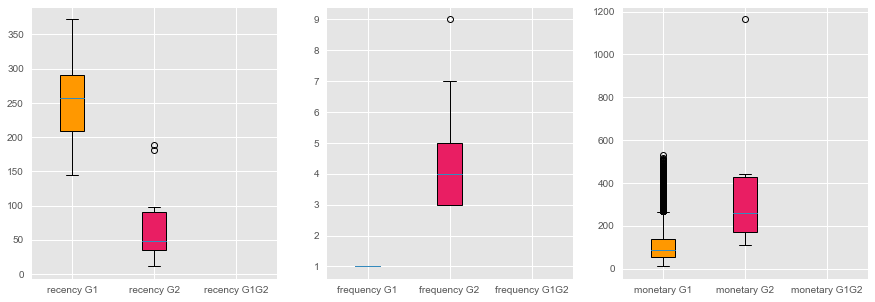

In [298]:
# Distribution RFM
plt.figure(figsize=(15,5))

colors = ['#FF9800', # Groupe 1 #E91E63
          '#E91E63', # Groupe 2 #1976D2
          '#FFFFFF'] # Groupe 1 - Groupe 2

# Distribution R
plt.subplot(1,3,1)

val1 = df_rfm_abc['recency_x'].dropna()
val2 = df_rfm_abc['recency_y'].dropna()
val3 = df_rfm_abc['recency'].dropna()

box_plot_data=[val1,val2,val3]
box=plt.boxplot(box_plot_data,vert=1,patch_artist=True,labels=['recency G1','recency G2','recency G1G2'])


for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

    
# Distribution F
plt.subplot(1,3,2)

val1 = df_rfm_abc['frequency_x'].dropna()
val2 = df_rfm_abc['frequency_y'].dropna()
val3 = df_rfm_abc['frequency'].dropna()

box_plot_data=[val1,val2,val3]
box=plt.boxplot(box_plot_data,vert=1,patch_artist=True,labels=['frequency G1','frequency G2','frequency G1G2'])

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

    
# Distribution M
plt.subplot(1,3,3)

val1 = df_rfm_abc['monetary_x'].dropna()
val2 = df_rfm_abc['monetary_y'].dropna()
val3 = df_rfm_abc['monetary'].dropna()

box_plot_data=[val1,val2,val3]
box=plt.boxplot(box_plot_data,vert=1,patch_artist=True,labels=['monetary G1','monetary G2','monetary G1G2'])

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

print('Clients G1:',df_rfm_a.shape[0])
print('Clients G2:',df_rfm_b.shape[0])
print('Clients G1G2:',df_rfm_group_.shape[0])

plt.show()

### Représentations 3D

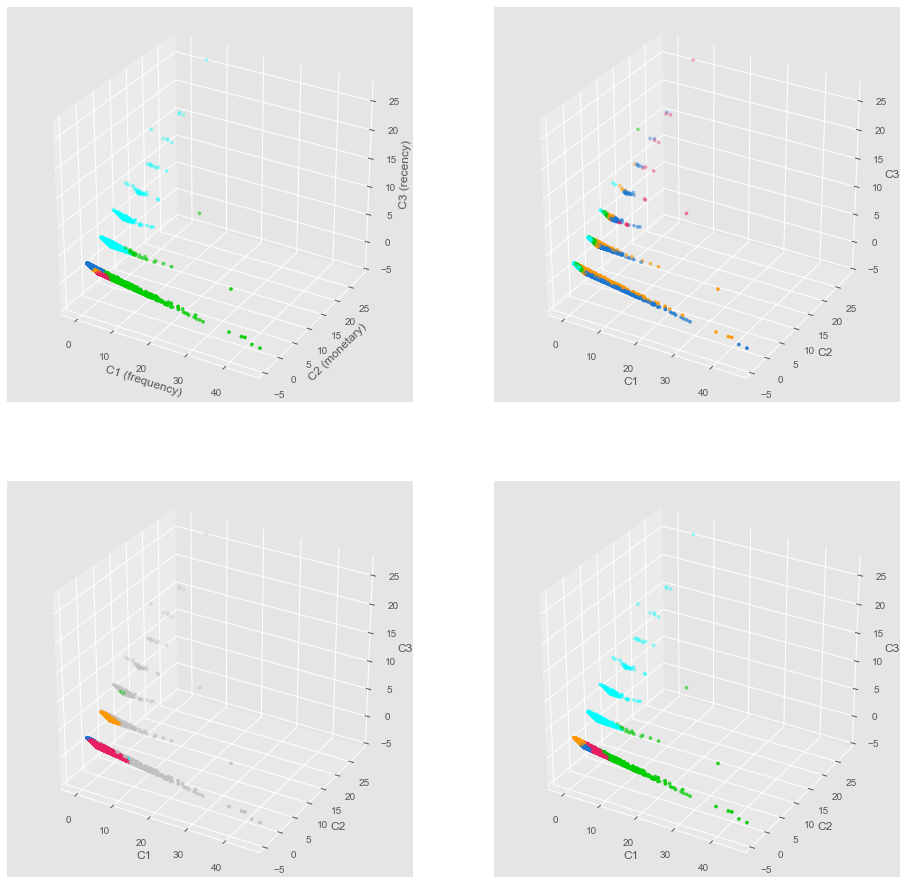

In [299]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
import numpy as np

# Avec valeurs non transformées par ACP
#x = X['recency'].tolist()
#y = X['frequency'].tolist()
#z = X['monetary'].tolist()

x = X[:,0] # frequency
y = X[:,1] # monetary
z = X[:,2] # recency

s_ = 10

fig = plt.figure(figsize=(16, 16))

ax = fig.add_subplot(221, projection='3d')
ax.scatter(x, y, z, marker='o', c = labels_colors(kmea5_l), s = s_)
ax.set_xlabel('C1 (frequency)')
ax.set_ylabel('C2 (monetary)')
ax.set_zlabel('C3 (recency)')

ax = fig.add_subplot(222, projection='3d')
ax.scatter(x, y, z, marker='o', c = labels_colors(segment_l), s = s_)
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_zlabel('C3')

ax = fig.add_subplot(223, projection='3d')
ax.scatter(x, y, z, marker='o', c = labels_colors(dbs.labels_), s = s_)
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_zlabel('C3')

ax = fig.add_subplot(224, projection='3d')
ax.scatter(x, y, z, marker='o', c = labels_colors(kpro.labels_), s = s_)
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_zlabel('C3')

plt.show()

In [300]:
time_calc('3D')
t = time.time()

Durée de l'opération '3D': 18.72 s
Durée totale de traitement: 00 h 03 m 07 s


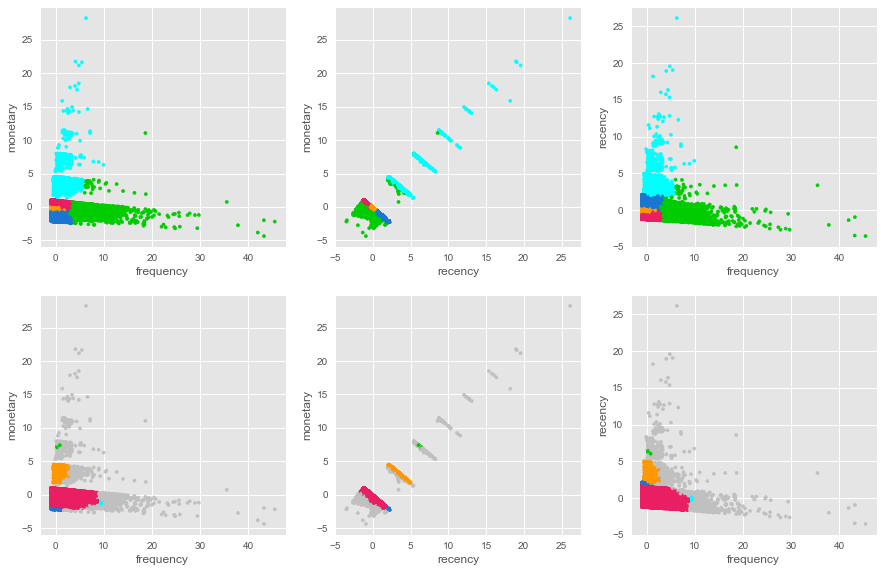

In [301]:
fig = plt.figure(figsize=(15, 15))

x = X[:,0] # frequency
y = X[:,1] # monetary
z = X[:,2] # recency

s_ = 10

### k-means

ax = fig.add_subplot(331)
ax.scatter(x, y, c = labels_colors(kmea5_l), s = s_)

ax.set_xlabel('frequency')
ax.set_ylabel('monetary')

### k-means

ax = fig.add_subplot(332)
ax.scatter(z, y, c = labels_colors(kmea5_l), s = s_)

ax.set_xlabel('recency')
ax.set_ylabel('monetary')

### k-means

ax = fig.add_subplot(333)
ax.scatter(x, z, c = labels_colors(kmea5_l), s = s_)

ax.set_xlabel('frequency')
ax.set_ylabel('recency')

### DBSCAN

ax = fig.add_subplot(334)
ax.scatter(x, y, c = labels_colors(dbs.labels_), s = s_)

ax.set_xlabel('frequency')
ax.set_ylabel('monetary')

### DBSCAN

ax = fig.add_subplot(335)
ax.scatter(z, y, c = labels_colors(dbs.labels_), s = s_)

ax.set_xlabel('recency')
ax.set_ylabel('monetary')

### DBSCAN

ax = fig.add_subplot(336)
ax.scatter(x, z, c = labels_colors(dbs.labels_), s = s_)

ax.set_xlabel('frequency')
ax.set_ylabel('recency')

plt.show()

In [302]:
time_calc('3D éclatée')
t = time.time()

Durée de l'opération '3D éclatée': 10.18 s
Durée totale de traitement: 00 h 03 m 18 s


### Geolocalisation

On récupère, depuix le store, le dataframe contenant les coordonnées géographiques.

In [303]:
%store -r df_geolocation_gr_0

La fonction suivante permet d'afficher les clients par groupes sur une carte.

In [304]:
def clusters_map(k_group_map,k_cluster_1=99,k_cluster_2=99,k_cluster_3=99,k_cluster_4=99,k_cluster_5=99,n=10000):

    # Clients et modèle de clustering
    df_cust_k_group = df_rfm[['customer_unique_id',k_group_map]]
    # Clients inclus dans le groupe k_cluster
    #df_cust_k_group = df_cust_k_group[df_cust_k_group[k_group_map] == k_cluster]

    # Clients uniques avec leur code de geolocalisation
    df_cust_loc_2 = df[['customer_unique_id','customer_zip_code_prefix_gl']].groupby('customer_unique_id').first()
    # Clients uniques avec leur code de geolocalisation et leur groupe
    df_cust_loc_2 = df_cust_loc_2.merge(df_cust_k_group, left_on = 'customer_unique_id', right_on = 'customer_unique_id')

    print('Nombre de clients sans code de geolocalisation:',df_cust_loc_2[['customer_zip_code_prefix_gl']].isna().sum().sum())
    #print('\n',df_cust_loc_2.head())
    print('Nombre de clients total:',df_cust_loc_2.shape[0])

    # Lien avec les coordonnées géographiques
    df_cust_loc_2 = df_cust_loc_2.merge(df_geolocation_gr_0, left_on = 'customer_zip_code_prefix_gl',
                                        right_on = 'geolocation_zip_code_prefix', how = 'right')

    df_cust_loc_2 = df_cust_loc_2[['geolocation_lat','geolocation_lng','customer_unique_id',k_group_map]]

    print('Nombre de clients non géolocalisés:',df_cust_loc_2.dropna().shape[0])

    import folium

    map_osm = folium.Map(location=[-20, -47], zoom_start=4)
    #map_osm = folium.Map(location=[-20, -47], zoom_start=4, zoom_control=True)
    
    radius_ = 1
    
    if k_cluster_1 != 99:

        df_loc_1 = df_cust_loc_2[df_cust_loc_2[k_group_map] == k_cluster_1]
        print('\nClients non géolocalisés groupe %r:' % k_cluster_1,df_loc_1.isna().sum().sum())       
        df_loc_1 = df_loc_1.dropna()

        for ind, geolocation_lat_x, geolocation_lng_x, customer_id in df_loc_1[['geolocation_lat', 'geolocation_lng', 
                                                                                'customer_unique_id']][:n].itertuples():
            map_osm.add_child(folium.RegularPolygonMarker(location=[geolocation_lat_x,geolocation_lng_x],
                                                          color='#E91E63',
                                                          fill_color='#E91E63',
                                                          radius=radius_))

    if k_cluster_2 != 99:

        df_loc_2 = df_cust_loc_2[df_cust_loc_2[k_group_map] == k_cluster_2]
        print('Clients non géolocalisés groupe %r:' % k_cluster_2,df_loc_2.isna().sum().sum())
        df_loc_2 = df_loc_2.dropna()

        for ind, geolocation_lat_x, geolocation_lng_x, customer_id in df_loc_2[['geolocation_lat', 'geolocation_lng', 
                                                                                'customer_unique_id']][:n].itertuples():
            map_osm.add_child(folium.RegularPolygonMarker(location=[geolocation_lat_x,geolocation_lng_x], 
                                                          color='#1976D2',
                                                          fill_color='#1976D2',
                                                          radius=radius_))
            
    if k_cluster_3 != 99:

        df_loc_3 = df_cust_loc_2[df_cust_loc_2[k_group_map] == k_cluster_3]
        print('Clients non géolocalisés groupe %r:' % k_cluster_3,df_loc_3.isna().sum().sum())
        df_loc_3 = df_loc_3.dropna()

        for ind, geolocation_lat_x, geolocation_lng_x, customer_id in df_loc_3[['geolocation_lat', 'geolocation_lng', 
                                                                                'customer_unique_id']][:n].itertuples():
            map_osm.add_child(folium.RegularPolygonMarker(location=[geolocation_lat_x,geolocation_lng_x], 
                                                          color='#FF9800',
                                                          fill_color='#FF9800',
                                                          radius=radius_))
    
    if k_cluster_4 != 99:

        df_loc_4 = df_cust_loc_2[df_cust_loc_2[k_group_map] == k_cluster_4]
        print('Clients non géolocalisés groupe %r:' % k_cluster_4,df_loc_4.isna().sum().sum())
        df_loc_4 = df_loc_4.dropna()

        for ind, geolocation_lat_x, geolocation_lng_x, customer_id in df_loc_4[['geolocation_lat', 'geolocation_lng', 
                                                                                'customer_unique_id']][:n].itertuples():
            map_osm.add_child(folium.RegularPolygonMarker(location=[geolocation_lat_x,geolocation_lng_x], 
                                                          color='#00CC00',
                                                          fill_color='#00CC00',
                                                          radius=radius_))
            
    if k_cluster_5 != 99:

        df_loc_5 = df_cust_loc_2[df_cust_loc_2[k_group_map] == k_cluster_5]
        print('Clients non géolocalisés groupe %r:' % k_cluster_5,df_loc_5.isna().sum().sum())
        df_loc_5 = df_loc_5.dropna()

        for ind, geolocation_lat_x, geolocation_lng_x, customer_id in df_loc_5[['geolocation_lat', 'geolocation_lng', 
                                                                                'customer_unique_id']][:n].itertuples():
            map_osm.add_child(folium.RegularPolygonMarker(location=[geolocation_lat_x,geolocation_lng_x], 
                                                          color='#00FFFF',
                                                          fill_color='#00FFFF',
                                                          radius=radius_))
    return map_osm

In [305]:
#clusters_map('KM_group_5',2,3,4)

In [306]:
time_calc('Geolocalisation')

Durée de l'opération 'Geolocalisation': 0.08 s
Durée totale de traitement: 00 h 03 m 18 s


### Fonction de recherche par groupe

In [307]:
df_rfm = df_rfm[list_rfm_f]

In [308]:
df_rfm.shape

(95418, 31)

In [309]:
def cust_search_gr(model,group,n=5):

    df_rfm_result = df_rfm[df_rfm[model] == group]

    df_rfm_result.columns = ['customer_unique_id',
                             'start',
                             'end',
                             'older',
                             'recency',
                             'duration',
                             'frequency (number of orders)',
                             'frequency_2 (number of products)',
                             'product number average',
                             'number of different products',
                             'number of payment types',
                             'monetary',
                             'average price',
                             'total price',
                             'seller loc = delivery loc',
                             'mean score',
                             'R',
                             'F',
                             'M',
                             'RFM',
                             'rfm_score',
                             'segment_x',
                             'segment_y',
                             'KM_group_3',
                             'KM_group_4',
                             'KM_group_5',
                             'KM_group_6',
                             'KM_group_7',
                             'KMO_group',
                             'KPR_group',
                             'DBS_group']

    
    df_rfm_result = df_rfm_result[['customer_unique_id','recency','frequency (number of orders)','monetary']]
    
    print('Nombre de résultats:',df_rfm_result.shape[0])
    
    return df_rfm_result.head(n)

In [310]:
cust_search_gr(segment,0,25)

Nombre de résultats: 21


,customer_unique_id,recency,frequency (number of orders),monetary
19108,33176de67c05eeed870fd49f234387a0,91.0,3.0,418.003333
21431,394ac4de8f3acb14253c177f0e15bc58,19.0,5.0,149.082000
21490,397b44d5bb99eabf54ea9c2b41ebb905,78.0,4.0,439.132500
23301,3e43e6105506432c953e165fb2acf44c,188.0,9.0,130.296667
23451,3ea4185126195c34ed9949d8e406d570,47.0,3.0,268.876667
29189,4e1cce07cd5937c69dacac3c8b13d965,35.0,3.0,431.533333
29773,4facc2e6fbc2bffab2fea92d2b4aa7e4,21.0,4.0,440.187500
35373,5e8f38a9a1c023f3db718edcf926a2db,181.0,5.0,222.836000
37319,63cfc61cee11cbe306bff5857d00bfe4,98.0,6.0,137.720000
37531,6469f99c1f9dfae7733b25662e7f1782,67.0,7.0,108.404286


### Fonction de recherche par client

In [311]:
def cust_search(customer_unique_id):

    df_rfm_result = df_rfm[df_rfm['customer_unique_id'] == customer_unique_id]

    df_rfm_result.columns = ['customer_unique_id',
                             'start',
                             'end',
                             'older',
                             'recency',
                             'duration',
                             'frequency (number of orders)',
                             'frequency_2 (number of products)',
                             'product number average',
                             'number of different products',
                             'number of payment types',
                             'monetary',
                             'average price',
                             'total price',
                             'seller loc = delivery loc',
                             'mean score',
                             'R',
                             'F',
                             'M',
                             'RFM',
                             'rfm_score',
                             'segment_x',
                             'segment_y',
                             'KM_group_3',
                             'KM_group_4',
                             'KM_group_5',
                             'KM_group_6',
                             'KM_group_7',
                             'KMO_group',
                             'KPR_group',
                             'DBS_group']

    return df_rfm_result.T

Ci-dessous les personas obtenus en réduisant au ninimum le nombre de points proches des centroïdes.

On obtient 5 clients, chacun représentatif du centre des groupes respectifs.

On peut visualier l'ensemble des informations disponibles sur un client en utilisant la fonction de recherche.


**Persona 0**: 9cefe42d341c88e20dfc3b05756e79a4

**Persona 1**: 19937f711def2da1ca3a162b2f9bedeb

**Persona 2**: 93d21068a4b6b2beb2c3cc9d44f948c0

**Persona 3**: 910ef561b28c67973b74ce21e0d252ea

**Persona 4**: 961173ac0d5857ae5bf61f00543b8847

In [312]:
# Persona 0
cust_search('9cefe42d341c88e20dfc3b05756e79a4')

,58574
customer_unique_id,9cefe42d341c88e20dfc3b05756e79a4
start,2017-05-26 00:00:00
end,2017-05-26 00:00:00
older,465
recency,465
duration,1
frequency (number of orders),1
frequency_2 (number of products),1
product number average,1
number of different products,1


In [313]:
# Persona 1
#cust_search('19937f711def2da1ca3a162b2f9bedeb')

In [314]:
# Persona 2
#cust_search('93d21068a4b6b2beb2c3cc9d44f948c0')

In [315]:
# Persona 3
#cust_search('910ef561b28c67973b74ce21e0d252ea')

In [316]:
# Persona 4
#cust_search('961173ac0d5857ae5bf61f00543b8847')

In [317]:
time_calc('Fonction recherche par client')

Durée de l'opération 'Fonction recherche par client': 0.31 s
Durée totale de traitement: 00 h 03 m 18 s


**Opération spéciale**

Suppresssion d'un client pour illustrer l'intersection du ***Segment RFM 0*** avec le ***cluster 2 de K-Means 5***.

In [318]:
cust_search('c8460e4251689ba205045f3ea17884a1')

,74750
customer_unique_id,c8460e4251689ba205045f3ea17884a1
start,2018-08-07 00:00:00
end,2018-08-08 00:00:00
older,27
recency,26
duration,2
frequency (number of orders),4
frequency_2 (number of products),24
product number average,6
number of different products,1


In [319]:
df_rfm.shape

(95418, 31)

**Clients du Segment RFM 0**

In [320]:
#clusters_map(segment,0)

In [321]:
df_rfm.head(1)

,customer_unique_id,start,end,older,recency,duration,frequency,frequency_2,prod_nb_avg,nb_prod_diff,...,segment_x,segment_y,KM_group_3,KM_group_4,KM_group_5,KM_group_6,KM_group_7,KMO_group,KPR_group,DBS_group
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,2018-05-10,116.0,116.0,1.0,1.0,1.0,1.0,1,...,1,1,2,2,0.0,0,0,0,1,0


In [322]:
df_rfm.shape

(95418, 31)

In [323]:
df_rfm_copy = df_rfm.copy()

**Sélection d'un client du Segment RFM 0**

In [324]:
# Isoler des clients
df_rfm = df_rfm_copy.copy()
df_rfm = df_rfm[df_rfm['customer_unique_id'] == 'c8460e4251689ba205045f3ea17884a1']
df_rfm.shape

(1, 31)

In [325]:
df_rfm.head()

,customer_unique_id,start,end,older,recency,duration,frequency,frequency_2,prod_nb_avg,nb_prod_diff,...,segment_x,segment_y,KM_group_3,KM_group_4,KM_group_5,KM_group_6,KM_group_7,KMO_group,KPR_group,DBS_group
74750,c8460e4251689ba205045f3ea17884a1,2018-08-07,2018-08-08,27.0,26.0,2.0,4.0,24.0,6.0,1,...,0,0,0,3,3.0,5,5,0,3,-1


**Suppression d'un client du Segment RFM 0**

In [326]:
# Supprimer des clients
df_rfm = df_rfm_copy.copy()
df_rfm.set_index('customer_unique_id', inplace=True)
list_cust_uid_to_rem = [
                        'c8460e4251689ba205045f3ea17884a1',
                       ]

df_rfm = df_rfm.drop(list_cust_uid_to_rem)
df_rfm.reset_index(inplace=True)
df_rfm.shape

(95417, 31)

In [327]:
#clusters_map(segment,0)

### Temps de traitements

In [328]:
time_calc('Partionnement final','',1)

Durée de l'opération 'Partionnement final': 0.64 s
Durée totale de traitement: 00 h 03 m 19 s

Durée des opérations
--------------------
                                          Opération  Durée Temps réel
0                                    Initialisation   0.19           
1                                     Variables RFM   1.45           
2                  Filtrage des individus (clients)   0.11           
3                                Statistiques - RFM   2.90           
4                                Segmentation - RFM   3.99           
5                    Segmentation stratégique - RFM   1.75           
6                        Jeu de données final - RFM   0.28           
7                       Initialisation - Clustering   1.54           
8                       Standardisation des données   0.09           
9                Analyse en Composantes Principales   4.20           
10                            Paramètres graphiques   0.90           
11                 Mesu